## <center>  PROJECT - 8. Прогнозирование стоимости домов, для агентства недвижимости.

### Постановка задачи
**Описание проекта**

* Агентство недвижимости столкнулось с проблемой: риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

**Бизнес-задача**
* Повысить прибыль агентства недвижимости за счет рекомендованной сратегии для  риелторов, которая повлияит на качества их работы при продаже объектов недвижимости.

**Техническая задача**
* Разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок на продажу объектов недвижимости.

**Что необходимо сделать**
* Pазработать сервис для предсказания стоимости домов на основе истории предложений.

***Датасет для работы -*** https://drive.google.com/file/d/11-ZNNIdcQ7TbT8Y0nsQ3Q0eiYQP__NIW/view.

**Этапы проекта:**
1. Обработка данных:
 * пропуски, дубликаты, выбросы
 * сгенерировать новые признаки с использованием внешних источников.

2. Анализ данных.

3. Определить факторы, влияющие на стоимость недвижимости.

3. Подбор моделей ML, для прогнозирования стоимости недвижимости, отобрать лучшую по целевой метрике.

4. Pазработать сервис.

5. Выводы.

In [ ]:
# Устанавливаем отсутствующе библиотеки
!pip install sweetviz
!pip install category_encoders
!pip install optuna
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np

import sweetviz as sv

import seaborn as sns
import matplotlib.pyplot as plt

import re
import requests
from bs4 import BeautifulSoup

import category_encoders as ce
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from catboost import Pool, CatBoostRegressor
import optuna
import pickle

import warnings
warnings.filterwarnings('ignore')

DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Project_8_Final/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # , force_remount=True)

Mounted at /content/drive


In [ ]:
# Прочитаем данные
df = pd.read_csv(DATA_DIR+'data/data.csv')
df.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


## 2. Знакомство с данными:

**- status —** статус продажи;

**- private pool —** собственный бассейн;

**- propertyType —** тип объекта недвижимости;

**- street —** адрес объекта;

**- baths —** количество ванных комнат;

**- homeFacts —** сведения о строительстве объекта *(содержит несколько типов сведений, влияющих на оценку объекта);*

**- fireplace —** наличие камина;

**- city —** город;

**- schools —** сведения о школах в районе;

**- sqft —** площадь в футах;

**- zipcode —** почтовый индекс;

**- beds —** количество спален;

**- state —** штат;

**- stories —** количество этажей;

**- mls-id и MlsId —** идентификатор - *MLS - (Multiple Listing Service);*

**- PrivatePool —** собственный бассейн

**- target —** цена объекта недвижимости *(целевой признак).*

### Информация структуры данных.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

### Описательная статистика

In [ ]:
df.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103114,377151,377185,336608,377185,285903,377185,226469,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1652,2026,297365,25405,4549,1184,39,347,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


### Проведем  EDA с первичной визуализации данных с помощью библиотеки *SweetViz*

In [1]:
report = sv.analyze(df)
# report.show_html(scale=None) # (scale=0.95)
report.show_notebook(scale=1)

### Cмотрим на пропущенныe значения

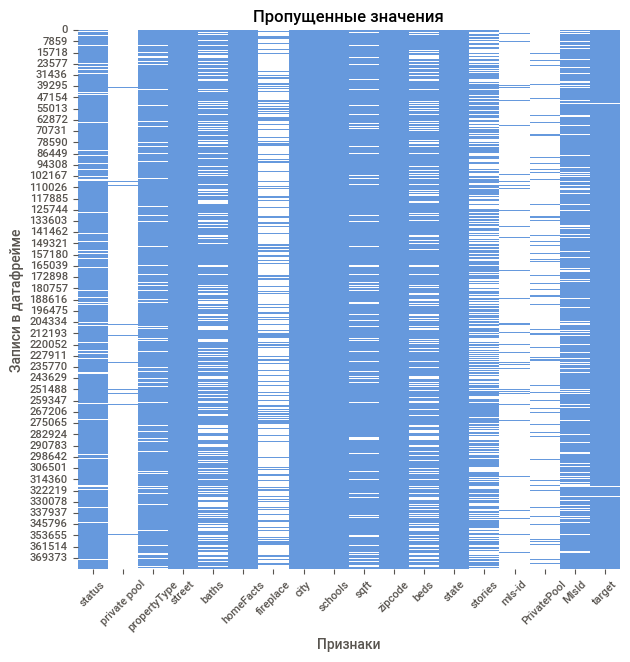

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
heatmap = sns.heatmap(
    data = df.isnull(),
    cmap = sns.color_palette(['#69d', 'white']),
    cbar = False
);
heatmap.set_title('Пропущенные значения');
heatmap.set_xlabel('Признаки');
heatmap.set_ylabel('Записи в датафрейме');
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45);

### Предварительные выводы:
1. В данных много пропусков:
**- Признак - *private pool* 99% и *PrivatePool* 89% -**  пропусков, признаки удаляем.

**- Признак fireplace -**  `73%` - много пустых значений. В случае нехватки данных для обучения модели, можно попробовать сгенерировать новые признаки с использованием внешних источников, - **но пока удалим его.**

**- Признак системы мультилистинга - msl-id -** 93% -  много пропусков,
его дубль - Признак **MlsId -**  18% пропусков и много уникальных значений.

**MsId** - это **Id** объекта в системе, в нём соединены:
* город нахождения объекта,
* штат
* почтовый индекс.

Эти данные есть в отдельных признаках, их удаляем.

**- Целевой признак - target -** содержит менее 1% пустых значений (2 481 запись). Эти записи не позволят нам обучить модель, поэтому от них сразу можно избавиться.

2. Количество дубликатов  **50** - удаляем.

3. Признаки с высоким процентом уникальных значений - неинформативные данные:
**- street - 89%. - Признак** - интересен для отображения точки на карте, но не для предсказания. Распределение по штатам в этом смысле более информативно.

Признак **street -** содержит почти 40 тыс. - одинаковых названий, это не только улица, но и номер дома  и одинаковые названия указывают, на один и тот же объект, являются дубликатами.

Например, это может быть объявление о продаже дома в 2020 году, и о продаже участка в 2018 году, когда дом еще не был построен, или  когда дом снесли.

В эти 40 тыс. - входят записи, где адрес не значится, например: **Undisclosed Address** - таких объявлений - около 2 тыс.

Для целей предсказания неважно, входит ли один и тот же объект (в качестве земельного участка и в качестве дома) дважды в датафрейм, у них разные характеристики и разная цена, в - **целевом признаке -** модель выучит закономерности для того и другого типа.

То же касается и массовой застройки и отсутствующих адресов: поскольку мы не планируем кодировать адреса, а будем опираться на другие признаки, то от дубликатов и пропущенных значений в - **признаке - street -**  избавимся вместе с самим признаком, как только необходимость в нем пропадет.

**- homeFacts - 85%. -** Из этого признака попробуем выделить сведения об объектах: год постройки и реконструкции, начичие отопления и кондиционирования, парковки, размер участка и стоимости за квадратный фут, его не будем  удалять. Займемся им в разделе EDA.

**- schools - 79%.** Из этого признака тоже в разделе EDA выделим информацию о школах, соседствующих с объектом недвижимости и лишь затем удалим.

**- city - содержит 2009 - уникальных названий городов.** - Среди них есть,
 написанные в верхнем регистре, которые можно объединить с обычным написанием, но количество велико, а ценность невысока. В разных городах одного штата (с одинаковым климатом) цены, скорее всего, будут схожи.

Отличия могут быть заметны при сравнении крупных городов *(Нью-Йорк, Лос-Анжелес, Майами), или столиц штатов*.

В данном разделе мы  избавимся от пустых значений (их немного), а в разделе **EDA** выделим - **признак - столица штата.**

**- zipcode -** много уникальных значений, этот признак пригодится нам при обработке  **признака - city,** - после чего  удалим его.

### 3. Предобработка и очистка данных

Предобработаем каждый из признаков в отдельности. Простого преобразования из типа **object в числовые типы** - не получится совершить даже для признаков, которые описывают числовые характеристики (число ванных, этажей, площадь дома), в виду их неоднородности.

In [ ]:
# Действия по результатам первичного анализа
print('Размерность датафрейма до предобработки:', df.shape)
rows = df.shape[0]
cols = df.shape[1]

df.drop(['mls-id', 'MlsId', 'fireplace'], axis=1, inplace=True) # удаляем ненужные признаки
df.dropna(axis=0, subset='target', inplace=True) # удаляем строки с пропусками в целевом признаке
df.dropna(axis=0, subset='city', inplace=True) # удаляем строки с пропусками в признаке города
df.drop_duplicates(inplace=True) # удаляем полные дубликаты

print('Размерность датафрейма после предобработки:', df.shape)
print(f'Удалены {rows-df.shape[0]} строки и {cols-df.shape[1]} столбца')

Размерность датафрейма до предобработки: (377185, 18)
Размерность датафрейма после предобработки: (374532, 15)
Удалены 2653 строки и 3 столбца


#### 3.1 Обработка признака - **status**

In [ ]:
# Выделим основные категории, которые имеют долю свыше 1%
status = df['status'].value_counts(normalize=True)*100
display('Доли типов собственности в датафрейме (%):', round(status[status > 1],2))

'Доли типов собственности в датафрейме (%):'

,proportion
status,
for sale,46.54
Active,31.35
For sale,12.96
foreclosure,1.69
New construction,1.63
Pending,1.40


Итак, две главные группы жилья по статусу - это: **Active** и **For Sale**. Скорее всего, суть их одинакова, поэтому мы объединим их.

В пятерку также вошли: **Foreclosure** - продажа недвижимости, вернувшейся к кредитору из-за неуплаты ипотеки (отличается от традиционной продажи, сюда же отнесем статус - **Auction**); **New construction** (также обозначается просто как **New**) и **Pending** - все возможные случаи, в которых оформление сделки началось, но приостановилось (сюда же отнесем все вариации статуса **Contingency**).

К жилью со статусом **New** прибавим жилье со статусом **Coming soon <дата сдачи>**, которое еще не сдано, но уже продается.

Записи с жильем под аренду **Rent** (в количестве 412) мы удалим, потому что целевой признак для такого жилья указан за месяц и не поможет нам в предсказании.

Таким образом, список групп будет следующим:

* Active,
* Foreclosure,
* Pending,
* New.

Причем начнем мы формирование групп с малочисленных, поскольку их ключевые слова часто стоят в паре с более значительными, например: **Active - Auction**. Для того, чтобы в данном примере отнести такую недвижимость к статусу **Foreclosure**, необходимо начать с поиска слова **Auction**, а не **Active**.

Всем остальным статустам, а также пустым значениям статуса присвоим категорию **Other**.

Для решения задачи создадим функцию.

In [ ]:
# Функция объединения похожих по сути значений в признаке
def find_fill(fill_value: str,
              find_value: list,
              feature: str,
              df: pd.DataFrame = df) -> pd.DataFrame:
    """Функция объединяет в одну группу fill_value похожие по сути
    значения find_value в признаке feature. Функция получает эти
    данные на вход вместе с датафреймом, затем отыскивает каждое
    значение в признаке и сохраняет индексы с таким значением,
    а затем заменяет их все на одно общее название. И возвращает
    обновленный датафрейм.

    Args:
        fill_value (str): общее название группы
        find_value (list): похожие по сути значение для объединения
        feature (str): названия признака, где происходит поиск
        df (pd.DataFrame, optional): датафрейм, по умолчанию = df

    Returns:
        pd.DataFrame: обновленный датафрейм
    """

    # Создаем множество для хранения индексов строк
    ind = set()
    # Запускаем цикл по всем значениям признака, которые нужно найти в ячейках
    for value in find_value:
        # Добавляем ко множеству индексы всех строк с искомым значением value
        ind.update(df[df[feature].str.contains(value, case=False) == True].index)
    # Заменяем все значения по найденным индексам на общее значение
    df.loc[list(ind), feature] = fill_value

    del ind # очищаем память

    # Возвращаем обновленный датафрейм
    return df


In [ ]:
# Создадим словарь из часто встречающихся cтатусов продажи;
# в качестве значений укажем типы для группировки
status_type = {
    'Foreclosure': ['auction', 'foreclo'],
    'Pending': ['continge', 'pend'],
    'New': ['new', 'coming'],
    'Active': ['active', 'sale']
}

# Организуем цикл по всем элементам словаря статусов продажи.
# В написанную фукцию будем распаковывать ключ и значения словаря
# для первых двух параметров, затем название признака и сам датафрейм
for s in status_type.items():
    df = find_fill(*s, 'status', df)

# Добавим к статусу Pending некоторые записи вручную. Они зашифрованы
# одной или несколькими буквами, поэтому требуют применения метода fullmatch
# Создаем список для хранения индексов строк
ind = []
ind.extend(list(df[df['status'].str.fullmatch('C') == True].index))
ind.extend(list(df[df['status'].str.fullmatch('P') == True].index))
ind.extend(list(df[df['status'].str.fullmatch(r'P[s,f,i]') == True].index))
df.loc[ind, 'status'] = 'Pending'

# Удалем объявления со статусом аренды
ind = df[df['status'].str.contains('rent', case=False) == True].index
df.drop(ind, axis=0, inplace=True)

# Всем оставшимся категориям жилья присвоим статус Other
mask = df['status'].isin(status_type.keys()) # сформируем маску из 4-х основных статусов
df.loc[df[~mask].index, 'status'] = 'Other' # всем остальным статусам присвоим Other

del status_type, ind, mask # удалим переменные

#### 3.2 Обработка признака - **private pool**
Как мы видели на этапе знакомсnва с данными, в датафрейме присутсвуют два дублирующих друг друга признака с одинаковым названием, но разным написанием. Предположим, что значения в этих признаках дополняют друг друга. Проверим, сколько останется пропусков, если объединить эти два признака.

In [ ]:
# Создадим фильтры по пустым значениям и выведем результат анализа
mask1 = df['private pool'].isna() == True
mask2 = df['PrivatePool'].isna() == True
share = round(df[mask1 & mask2].shape[0] / df.shape[0] * 100, 2)
print(f'Доля пустых значений о бассейнах: {share}%')

del mask1, mask2, share

Доля пустых значений о бассейнах: 88.19%


После объединения,  доля пропущенных значений 88.19%. Признак удаляем.

In [ ]:
# Удаляем эти неинформативные признаки
df.drop(['private pool', 'PrivatePool'], axis=1, inplace=True)

#### 3.3 Обработка признака **stories** - этап-1
Мы разбили обработку признака с количеством этажей на два этапа:
первый этап поставили до обработки признака **propertyType** в связи с тем, что в последнем иногда содержится количество этажей, которое отсутствует в признаке **stories**.

Поэтому целью этапа-1 является перенесение информации о количестве этажей из **propertyType** в **stories**.

На этапе-2 мы займемся обработкой значений, которые будут находиться в признаке **stories**, включая пустые.

In [ ]:
# Функция для выделения числа этажей
def story_num(s: str) -> str:
    """Функция принимает на вход строку и выделяет из нее
    количество этажей. Возвращает это количество или NaN,
    если оно не было в строке.

    Функция возвращает число этажей в формате строки, т.к.
    часто встречаются буквенные обозначения: "One Story".

    Например (исх. строка -> результат работы функции):
    - '1 Story' -> '1'
    - 'Detached, Two Story' -> 'Two'
    - 'Low-Rise (1-3 Stories)' -> '3'
    - 'Historical -> NaN

    Args:
        s (str): строка с количеством этажей из признака propertyType

    Returns:
        str: количество этажей в формате строки
    """

    if s is np.NaN:
        result = np.NaN  # если строка пустая, сохраним NaN
    else:
        result = re.findall(r'(\w+)\+*\s[Sstor]', s) # выделяем число этажей
        if len(result) > 0:
            result = result[0] # если этаж был во входной строке, сохраняем его в формате строки
        else:
            result = np.NaN # если этажа не было, вернем NaN

    # Возвращаем результат в виде строки или float, если это NaN
    return result

In [ ]:
# Сохраняем часть датафрейма, где вместо типа жилья указаны этажи (7.7+ тыс. объектов)
df_story = df[df['propertyType'].str.contains('stor', case=False) == True]
# Из этой таблицы выбираем те, у которых пустой признак stories, сохраняем индексы (7.6+ тыс.)
story_ind = df_story[df_story['stories'].isna() == True].index
# В главном датафрейме по сохраненному индексу заполняем пропуски в признаке stories
# Используем для этого написанную функцию
df.loc[story_ind, 'stories'] = df.loc[story_ind, 'propertyType'].apply(lambda s: story_num(s))

del df_story, story_ind # удаляем ненужные переменные

Кроме числа этажей в признаке **propertyType** - также иногда содержится указание на размер объекта недвижимости:
* Low Rise (жилье от 1 до 3 этажей),
*  Mid Rise (4-7 этажей),
* High Rise (от 8 этажей и выше).

Воспользуемся этим для заполнения пропущенных значений в признаке **stories.**

Hапишем **функцию,** которую применим для каждой разновидности объектов.

In [ ]:
# Функция для заполнения пустых значений в признаке на основе другого признака
def find_fillna(source_feature: str,
                target_feature: str,
                find_value: str,
                fill_value: str,
                df: pd.DataFrame = df) -> pd.DataFrame:
    """Функция получает на вход название признака source_feature,
    в котором требуется искать find_value, затем в признаке
    target_feature отыскивает пустые значения и заполняет их
    с помощью fill_value. Все изменения производятся в переданном
    в функцию датафрейме, который и возвращается обновленным.

    Args:
        source_feature (str): признак, где производится поиск значения find_value
        target_feature (str): признак, где заполняются пустые значения
        find_value (str): значение для поиска в source_feature
        fill_value (str): значение для заполнения пропусков в target_feature
        df (pd.DataFrame, optional): датафрейм, по умолчанию = df

    Returns:
        pd.DataFrame: обновленный датафрейм
    """

    #  Сохраняем часть датафрейма, где в признаке source_feature указано find_value
    df_story = df[df[source_feature].str.contains(find_value, case=False) == True]
    # Из этой таблицы выбираем те строки, в которых пустой признак target_feature
    story_ind = df_story[df_story[target_feature].isna() == True].index
    # В главном датафрейме заполняем пропуски в признаке target_feature на значение fill_value
    df.loc[story_ind, target_feature] = fill_value

    del df_story, story_ind # освобождаем память

    # Возвращаем обновленный датафрейм
    return df

In [ ]:
# Применим написанную выше функцию для каждого из трех видов высоты объекта
df = find_fillna(
    source_feature = 'propertyType',
    target_feature = 'stories',
    find_value = 'Low.Rise',
    fill_value = 'Low Rise (1-3 Stories)',
    df = df
)

df = find_fillna(
    source_feature = 'propertyType',
    target_feature = 'stories',
    find_value = 'Mid.Rise',
    fill_value = 'Mid Rise (4-7 Stories)',
    df = df
)

df = find_fillna(
    source_feature = 'propertyType',
    target_feature = 'stories',
    find_value = 'High.Rise',
    fill_value = 'High Rise (8+ Stories)',
    df = df
)

### 3.4 Обработка признака **propertyType**
Bыделим несколько главных типов жилья, на этапе знакомства с данными, больше половины представляют собой отдельно стоящие дома для одной семьи **Single family** - такой тип является наиболее распространенным типом жилья в США.

К этому типу отнесем все схожие по типу направления:
* Cape Cod,
* Colonial,
* Farmhouse и проч.

Нам важен лишь факт отдельно стоящего жилища для одной семьи. Разбиение на стили будет актуальным, если обученная модель будет показывать неудовлетворительные результаты предсказания цены, и нам нужно будет сгенерировать больше данных для обучения.

По аналогии выделим жилье для нескольких семей **Multifamily:** это может быть как отдельно стоящий дом, так и часть в комплексе **Townhouse** (об этом - ниже).

По аналогии в отдельную категорию вынесем **Townhouse** - дома для одной семьи, которые одной стеной примыкают к другому дому. Они дешевле и распространены в городах, где застройка плотнее. Очевидно, близость соседей означает меньший комфорт и, следовательно, может влиять на цену.

Перейдем к квартирам - **Condo.** Их насчитывается свыше 51 тыс. в датафрейме. Похожим по типу считается жилье **Apartment**, которое якобы можно только снимать, но не купить, однако в нашей базе для таких квартир цены указаны именно на покупку, а не за аренду. К тому же, их насчитывается 813, поэтому для упрощения объединим их с типом **Condo.** Cюда же добавим квартиры в жилищных кооперативах, промаркированных **Coop** - *не путать с "Co-op*, - которые, судя по другим тегам в описании объекта, относятся скорее к **Townhouse.**

Еще одной группой станут **пустые участки земли,** которые имеют тип **lot / land.** Обозначим их - **Land.**

Все остальные объекты, которые не войдут в перечисленные 5 групп типов недвижимости, мы отнесём к самому популярному типу - **Single famile** *(в датафрейме встречаются и гаражные постройки).*

Используем написанную **функцию - find_fill(),** которая поможет нам отыскивать типы жилья и заменять их на название группы. После ее применения остатки вручную отнесем к первой группе.

In [ ]:
# Создадим словарь из часто встречающихся и хорошо разделяемых по смыслу
# типов недвижимости; в качестве значений укажем типы для группировки
proper_type = {
    'Single family': ['single', 'bunga', 'cluster', 'colon', 'cape',
                      'contemp', 'cottage', 'craft', 'farm', 'federal',
                      'french', 'feder', 'florida', 'garden', 'historic',
                      'mediter', 'mobile', 'other', 'ranch', 'spanish',
                      'split', 'tradit', 'transit', 'tudor', 'victor',
                      'Low.Rise', '1 Sto', 'One Sto', '2 Sto', 'Two Sto'],
    'Multifamily': ['multi'],
    'Townhouse': ['town', 'co-op'],
    'Condo': ['condo', 'apart', 'coop', 'Mid.Rise', 'High.Rise'],
    'Land': ['land', 'lot']
}

# Организуем цикл по всем элементам словаря типов недвижимости
# В фукцию find_fill() будем распаковывать ключ и значения словаря
# для первых двух параметров, затем название признака и сам датафрейм
for p in proper_type.items():
    df = find_fill(*p, 'propertyType', df)

# Оставшиеся малочисленные типы недвижимости заменим на Single family
# Для этого сначала сохраним ключи словаря в список
main_types = list(proper_type.keys())

# Создадим маски по основным типам объектов
mask1 = df['propertyType'] == main_types[0]
mask2 = df['propertyType'] == main_types[1]
mask3 = df['propertyType'] == main_types[2]
mask4 = df['propertyType'] == main_types[3]
mask5 = df['propertyType'] == main_types[4]

# Выберем индексы записей из датафрейма, которые не относятся к 5 типам
left_ind = df[~mask1 & ~mask2 & ~mask3 & ~mask4 & ~mask5].index

# Присвоим им всем (36,4 тыс.) самый популярный тип - Single family
df.loc[left_ind, 'propertyType'] = main_types[0]

In [ ]:
# Проверим, что все типы недвижимости рассортированы по пяти группам
# и посмотрим на их соотношения
barplot = sns.barplot(
    data = df['propertyType'].value_counts().to_frame().reset_index(),
    y='propertyType',
    x='index',
);
barplot.set_title('Распределение объектов по основным типам собственности');
barplot.set_xlabel('Типы жилья');
barplot.set_ylabel('Количество объектов');

### 3.5 Обработка признака **stories** - этап-2
На предыдущем этапе удалось выделить информацию о количестве этажей и уменьшить долю пропусков в этом признаке с 40% до 37%

In [ ]:
# Проверим, что доля пустых значений уменьшилась с 40%
print('Оставшаяся доля пустых значений в признаке stories {:2.2%}'\
      .format(df['stories'].isna().sum() / df.shape[0]))

Оставшаяся доля пустых значений в признаке stories 37.32%


Теперь заполним пропуски с помощю данных, которые мы сохранили в признаке **propertyType**

Число этажей разделим на группы по следующему принципу:
* Single famely - Low Rise (1-3 Stories)
* Nultifamely - Low Rise (1-3 Stories)
* Townhouse - Low Rise (1-3 Stories)
* Condo - Low Rise (1-3 Stories), Mid Rise (4-7 Stories), High Rise (8+ Stories)
* Land - (0 Stories)
Ориентируемся что, только квартиры располагаются в диапазоне этажей. Возможно это оказывает влияние на цену, поэтому сохраним такое деление на этажи.

Отдельно обработаем все записи для типа недвижимости **Condo** и если есть в датафрейме указание на этаж квартиры, то сохраним егоЭ отнеся к соответствующей категории.

Если ячейка пустая, то присвоим наиболее часто встречающуюся этажную категорию - это **Low Rise - (1-3 Stories)**

После работы с квартирами всем остальным типам объектов присвоим выбранные категории, вне зависимости от того, что хранится в ячейках признака **Stories**

**Примечание:** *от первоначальной идеи присваивать всeм объетам типа **Land** - ноль этажей - пришлось отказаться, так как такая мера сильно снижала **Целевую метрику**.*

In [ ]:
# Составим список категорий этажей
story_list = ['Low Rise (1-3 Stories)', 'Mid Rise (4-7 Stories)',
              'High Rise (8+ Stories)', '0 Stories']

# Обновим ранее созданый словаь, присвоив типам недвижимости
# наиболее рапространенную категорию этажей для этой недвижимости
for t in main_types:
    if t == 'Land':
        proper_type[t] = story_list[3] # для Land - 0 Stories
    else:
        proper_type[t] = story_list[0] # для остальных - Low Rise

In [ ]:
# Функция обработки этажей для типа недвижимости Condo
def convert_condo_story(s: object) -> str:
    """Функция получает на вход значение ячейки признака stories и
    обрабатывает его:
    - если в ячейке содержится строка с числом, то функция преобразовывает
    его к типу float и проводит сравнение с тремя этажными сегментами
    и возвращает название одного из сегментов (для пустого значения NaN
    присваивается наиболее распространенное - Low Rise);
    - если в ячейке содержится строка с текстом и при обрабоке возникает
    ошибка, функция перехватывает ее и работает далее с текстом:
    она проверяет, есть ли в строке указание на этажный сегмент, и если
    есть, то возвращает его, а если нет, то возвращает Low Rise.

    Args:
        s (object): значение ячейки: float для NaN или строка

    Returns:
        str: строка с одним из трех этажных сегментов
    """

    try: # если в ячейке - только число, то преобразуем его во float
        if 0 <= float(s) <=3:
            result = story_list[0] # для этажей с 0 по 3 - Low Rise
        elif 4 <= float(s) <=7:
            result = story_list[1] # для этажей с 4 по 7 - Mid Rise
        elif 8 <= float(s):
            result = story_list[2] # для этажей свыше 7 - High Rise
        else:
            result = story_list[0] # для NaN присвоим Low Rise
    except: # если в ячейке - текст, то сохраним существующие этажи
        if s.find('Low') != -1:
            result = story_list[0] # для Low Rise
        elif s.find('Mid') != -1:
            result = story_list[1] # для Mid Rise
        elif s.find('High') != -1:
            result = story_list[2] # для High Rise
        else:
            result = story_list[0] # или присвоим распространенный Low Rise

    # Возвращаем результат
    return result

In [ ]:
# Отфильтруем датафрейм по типу недвижимости - Condo
ind = df[df['propertyType'] == 'Condo'].index
# С помощью написанной функции преобразуем значения
df.loc[ind, 'stories'] = df.loc[ind, 'stories'].apply(lambda x: convert_condo_story(x))
# Убедимся, что все значения подпадают под одну из трех категорий
display('Категории этажей для квартир:', df.loc[ind, 'stories'].value_counts())

'Категории этажей для квартир:'

,count
stories,
Low Rise (1-3 Stories),38505
High Rise (8+ Stories),7271
Mid Rise (4-7 Stories),3294


In [ ]:
# Теперь заполним значения для всех остальных типов недвижимости
for p in proper_type:
    if p == 'Condo': # если тип недвижимости - квартира, ...
        continue     # пропускаем его, т.к. он уже обработан
    # Отфильтруем датафрейм по типу недвижимости
    ind = df[df['propertyType'] == p].index
    # Присвоим категорию этажности всем объектам данного типа
    df.loc[ind, 'stories'] = proper_type[p]

# Убедимся, что пустых значений в признаке не осталось
print('Пустых значений в признаке stories: ', df['stories'].isna().sum())

Пустых значений в признаке stories:  0


In [ ]:
# Посмотрим на распределение объектов в зависимости от числа этажей
barplot = sns.barplot(
    data = df['stories'].value_counts().to_frame().reset_index(),
    y = 'stories',
    x = 'index',
    palette='hls'
);
barplot.set_title('Распределение объектов по числу этажей');
barplot.set_xlabel('Число этажей');
barplot.set_ylabel('Количество объектов');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);

del ind # очистим память

### 3.6. Обработка признака **baths**
Выделим из ячейки типа **object** количество ванных комнат и сохраним в формате **float** - (в датафрейме часто встречаются дробные значения ванных комнат, например: 3.5, 1.75. Возможно, это ошибка, или способ закодировать не полноценную ванную комнату с раковиной и большой ванной, а комнату с раковиной и душевой кабиной или раковиной и туалетом - гостевой туалет).
Предположение подтвердилось материалом по ссылке - https://therealtyfirms.com/half-bath-quarter-bath-three-quarter-bath/.

Так же присутствуют и явно аномальные значения, которые превышают тысячи. Поскольку они имеют в остальных разрядах нули, можем предположить, что это опечатка, и нули отбросить. Например: 3500.00 примем за 3.5 ванных комнаты.

Напишем **функцию преобразования** и применим ее к столбцу **baths.**

In [ ]:
# Напишем функцию для выделения числа ванных из строки
def bath_num(b: str) -> float:
    """Функция принимает на вход строку и выделяет из нее
    количество ванных комнат в формате float.
    Возвращает это количество или NaN, если оно не было в строке.

    Функция возвращает float без округления, т.к. дробные значения
    могут означать не полные ванные комнаты, а, например, ванную
    с душевой кабиной, или только туалет.

    Например (исх. строка -> результат работы функции):
    - '4 ba' -> 4.0
    - '3.5 Baths' -> 3.5
    - '1,500' -> 1500
    - NaN -> NaN
    - '~' -> NaN

    Args:
        b (str): строка с количеством ванных комнат

    Returns:
        float: количество ванных комнат или NaN
    """

    if b is np.NaN:
        result = np.NaN # если строка пустая, сохраним NaN
    else:
        result = re.findall(r'\d+\.*,*\d*', b) # выделяем число ванных
        if len(result) > 0:
            result = result[0] # если оно содержалось в строке, оно - на 1-м месте списка
            result = float(result.replace(',', '')) # убираем запятую-разделитель тысяч и приводим к float
            if result >= 1000: # устраняем опечатку
                result = result / 1000
        else:
            result = np.NaN # если в строке не было числа комнтат, сохраним NaN

    return result

# Применяем написанную функцию и преобразуем признак baths
df['baths'] = df['baths'].apply(lambda b: bath_num(b))

Мы сохранили в формате float количество ванных комнат и исправили опечатки (3500 ванных в место 3.5), но обнаружили аномалии, когда количество разнообразных ванных комнат исчисляется десятками.
Посмотрим на выбросы в диаграме

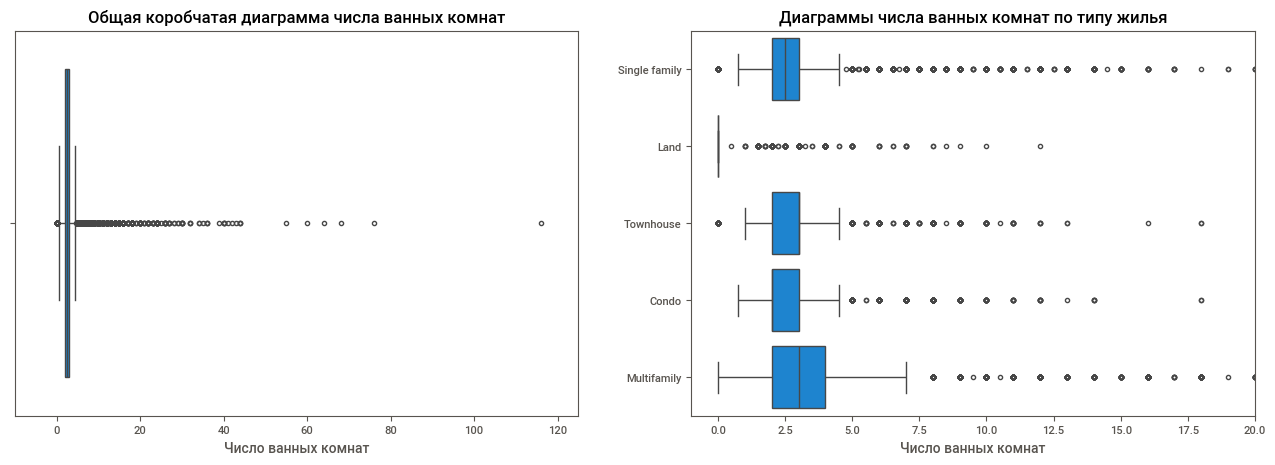

In [ ]:
# Построим две коробчатые диаграммы признака baths
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Общую диаграмму признака
boxplot = sns.boxplot(
    data = df,
    x = 'baths',
    ax = axes[0]
);
boxplot.set(xlim=(-10,125)); # ограничим диапазон, т.к. есть выбросы = 750
boxplot.set_title('Общая коробчатая диаграмма числа ванных комнат');
boxplot.set_xlabel('Число ванных комнат');

# И диаграмму с разбивкой на типы жилья
boxplot = sns.boxplot(
    data = df,
    x = 'baths',
    y = 'propertyType',
    ax = axes[1]
);
boxplot.set(xlim=(-1,20)); # ограничим диапазон, т.к. есть выбросы = 750
boxplot.set_title('Диаграммы числа ванных комнат по типу жилья');
boxplot.set_xlabel('Число ванных комнат');
boxplot.set_ylabel('');

Скорее всего, в доме для одной семьи количество ванных не превышает 1-3 единиц. В многосемейных домах, это количество можно умножить на число семей. В этом смысле левая диаграмма для всего признака малоинформативна, поэтому посмотрим на правую, где диаграмма разбита по типу жилья. Можно заметить, что медиана для каждого типа находится в диапазоне 2-3 (за исключением земельного участка Land, где нет построек и не может быть ванных комнат).

Попробуем определить выбросы методом **Тьюки**, но сначала проверим, распределены ли наши данные нормально. Воспользуемся тестом **Шапиро-Уилка.**

In [ ]:
# Установим уровень значимости и подготовим сообщения о результатах
alpha = 0.05
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# Проведем тест для признака ванных комнат
_, p = shapiro(df['baths'])
print('*** Результаты теста Шапиро-Уилка ***')
print('p = %.3f' % p)

# Интерпретируем результаты
if p > alpha:
	print(H0)
else:
	print(Ha)

*** Результаты теста Шапиро-Уилка ***
p = nan
Данные не распределены нормально (мы отвергаем H0)


По результатам теста мы можем воспользоваться методом **Тьюки** и выявить выбросы в количестве ванных комнат. Воспользуемся для этого написанной функцией.

In [ ]:
# Функция определения выбросов по методу Тьюки
def outliers_iqr(data: pd.DataFrame,
                 feature: str) -> tuple:
    """Функция определяет выбросы по методу Тьюки. Для этого она
    получает на вход датафрейм с выбросами и название признака,
    а возвращает кортеж из двух датафреймов: выбросы и очищенные
    данные.

    Args:
        data (pd.DataFrame): датафрейм с выбросами
        feature (str): название признака для очистки

    Returns:
        tuple: кортеж из датафреймов (выбросы и очищенные данные)
    """
    # Вычисляем квартили и межквартильное расстояние
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1

    # Определяем границы диапазона
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)

    # Определяем выбросы и очищенные записи
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]

    # Возвращем результат в виде кортежа датафреймов
    return outliers, cleaned

In [ ]:
# Применим написанную функцию и выведем результаты ее работы на экран
outliers, cleaned = outliers_iqr(df, 'baths')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print('Процент выбросов в исходном датафрейме: {:2.2%}'.format(outliers.shape[0]/df.shape[0]))
display('ТОП-5 по количеству ванных комнат среди выбросов:',
    outliers['baths'].value_counts().nlargest(5))

Число выбросов по методу Тьюки: 23498
Результирующее число записей: 242406
Процент выбросов в исходном датафрейме: 6.28%


'ТОП-5 по количеству ванных комнат среди выбросов:'

,count
baths,
5.0,9435
6.0,4290
0.0,3911
7.0,2072
8.0,1158


Метод Тьюки посчитал выбросами объекты недвижимости, где количество ванных комнат равно или выше 5. Так же к выбросам он отнёс и нуливое значение ванных комнат. Возможной причиной является то, что данные не распределяны нормально - в датафрейме большое количество аномальных значений свыше 10-20, а ниже нуля количество значений не опукается. По этому удалять 6% датафрейма не будем.

Подумаем логически: На пустых участках ванных комнат быть не может, но на такой тип собственности приходиться большее число **нулевых**. Количество ванных комнат редко превышает количество сплен и их число ванных комнат, увидем ниже в коде, не превысит 10.

Ориентируясь на многосемейные дома на правой диаграмме, посчитаем за выбросы все объекы, где число ванных комнат больше 7. Проверим процент таких записей в датафрейме и, если он окажется не большим, то удалим эти выбросы.

In [ ]:
# Проверим количество объектов, у которых ванных больше, чем 7
baths_7_plus = df[df['baths'] > 7].index
print(f'Свыше 7 ванных комнат насчитывается в {len(baths_7_plus)} объектах')
print('Это составляет лишь {:2.2%} всего датафрейма'.format(len(baths_7_plus)/df.shape[0]))

# Удаляем эти записи и очищаем память
df.drop(baths_7_plus, axis=0, inplace=True)
del baths_7_plus

Свыше 7 ванных комнат насчитывается в 3075 объектах
Это составляет лишь 0.82% всего датафрейма


Таким образом, без существенной потери данных, избавились от выбросов, к которым отнесли свыше 7 ванных комнат.
Переходим к заполнению пропусков.

Проще всего можно было бы воспользоваться методом **filna()** - для всего признака с использованием медианного значения 2.25. Однако зная, что для разных объектов и медианное значение будет разным. Поэтому для заполнения пропущенных значений используем медианну для каждого из типа недвижимости. Это будет более трудоёмко, но более точно.  

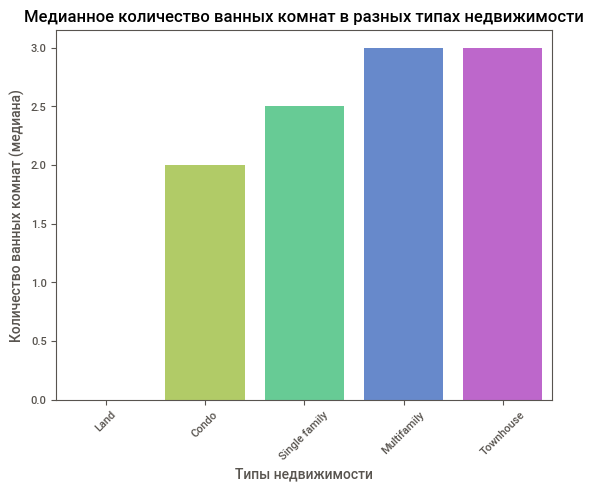

In [ ]:
# Вычислим медианное значение ванных комнат для разных типов недвижимости
proper_bath_med = df.groupby('propertyType')['baths'].agg('median').sort_values()

# Отобразим медианы в виде диаграммы
barplot = sns.barplot(
    data = proper_bath_med.to_frame().reset_index(),
    y = 'baths',
    x = 'propertyType',
    palette = 'hls'
);
barplot.set_title('Медианное количество ванных комнат в разных типах недвижимости');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Количество ванных комнат (медиана)');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);

К пропускам можно отнести нулевое количество ванных комнат в домах (в нашем понимании - не может быть дома или квартиры без ванной или туалета). Посмотрим на их количество.

In [ ]:
display('Нулевое количество ванных комнат в различных типах жилья:',
        df[df['baths'] == 0].groupby('propertyType')['baths'].count())

'Нулевое количество ванных комнат в различных типах жилья:'

,baths
propertyType,
Land,3707
Multifamily,32
Single family,148
Townhouse,24


Для типа недвижимости **Land** - отсутсвие ванной нормально, и отклонением будет считаться число, отличное от нуля (с этим раберёмся позже). На это указывае медиана.

Заполним пропуски и заменим нулевые значения на медианы по типу недвижемости.

(В цикле нулевые значения для **Land**, заменим на нулевую медианну для **Land**)

In [ ]:
# Запускаем цикл по всем типам недвижимости
for p in proper_bath_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = df['baths'].isna() == True # маска по пропускам в baths
    mask3 = df['baths'] == 0 # маска по нулевым значениям
    ind = df[mask1 & (mask2 | mask3)]['baths'].index # сохраняем индекс
    df.loc[ind, 'baths'] = proper_bath_med[p] # приcваиваем медиану

# Проверяем, что все пропуски заполнены
print('Осталось пропусков в признаке baths:', df['baths'].isna().sum())
# Проверяем, что нулевое количество ванных осталось только в Land
display('Нулевое количество ванных комнат в различных типах жилья:',
        df[df['baths'] == 0].groupby('propertyType')['baths'].count())

del mask1, mask2, mask3, ind, proper_bath_med # очистим память

Осталось пропусков в признаке baths: 0


'Нулевое количество ванных комнат в различных типах жилья:'

,baths
propertyType,
Land,30777


Осталось поправить значения, которые выбиваются из принятой концепции обозначения ванных комнат с помощью четвертей.
Например: 1.1, 3.2

Таких во всём датафрейме не болше - 100 и десятичная часть не превышает 2.
Поэтому отбросим всё после точки.

In [ ]:
ind = df[df['baths'] % 0.25 != 0]['baths'].index
df.loc[ind, 'baths'] = df.loc[ind, 'baths'].round()
print(f'Произведено {len(ind)} замен')

Произведено 80 замен


### 3.7 Обработка признака **city**
Данный признак будет нужен в разделе **EDA** при проектировании других признаков, поэтому обработаем его:
* заменим пустые строки, а так же значение **other** - на название городов (для этого воспользуемся признаком почтового кода **zipcode**)
* разделим написание **city** - с именем города (например: **commercecity**)
* заменим распространённые сокращения на полные названия (**pt -> port**)
* заменим редко встречающиеся в датафрейме названия городов на более распространённые (**e. new york -> brooklyn**)

В признаке содержится чуть больше 2000 уникальных значений, но и среди них встречаются повторения из за ошибок в написанииб сокращений или разного регистра. Поэтому первым шагом приведём все названия к нижнему регистру.  

In [ ]:
# Приводим к нижему регистру
df['city'] = df['city'].str.lower()

#### Обработка пустых названий и **other**

In [ ]:
# Создадим датафрейм для подбора подходящего названия города по индексу
zip_city_df = df.groupby(['zipcode', 'city'])['city'].count()

# Отберем все города, где вместо названия содержится слово other
ind = []
ind.extend(df[df['city'].str.contains('other') == True].index)
ind.extend(df[df['city'] == ' '].index)
print('Исправлено записей, где вместо названий городов либо other, либо два пробела:',
      len(ind))

# Заменим на наиболее подходящее название города
df.loc[ind, 'city']\
= df.loc[ind, ['zipcode']]\
.applymap(lambda x: zip_city_df[x].sort_values(ascending=False).index[0]).squeeze()

# Для записей, для которых не удалось подобрать название города по индексу,
# оставим other, чтобы не терять данные для обучения
ind = df[df['city'].str.contains('other') == True].index
print(f'Не удалось заменить other в {len(ind)} записях.')
df.loc[ind, 'city'] = 'other'

Исправлено записей, где вместо названий городов либо other, либо два пробела: 78
Не удалось заменить other в 3 записях.


### Обработка слитного написания **city**

In [ ]:
# Отберем все города, где слово city написано слитно
ind = df[df['city'].str.contains(r'\wcity') == True].index
print('Исправлено записей, где city написано слитно:', len(ind))

# Заменим на наиболее подходящее название города
p = re.compile('(\w+)city') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: p.findall(x)[0] + ' city').squeeze()

Исправлено записей, где city написано слитно: 67


### Обработка сокращений
* st -> saint
* pt -> port
* ft -> fort
* mt -> mount
* twp -> township

In [ ]:
# Отберем все города, где есть сокращение pt/pt.
ind = df[df['city'].str.match('(pt\.*)\s+', case=False) == True].index
print('Исправлено записей с сокращениями pt/pt.:', len(ind))

# Заменим на развернутое port
p = re.compile('(pt\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'port ' + x[p.match(x).end():]).squeeze()

Исправлено записей с сокращениями pt/pt.: 242


In [ ]:
# Отберем все города, где есть сокращение ft/ft.
ind = df[df['city'].str.match('(ft\.*)\s+', case=False) == True].index
print('Исправлено записей с сокращениями ft/ft.:', len(ind))

# Заменим на развернутое fort
p = re.compile('(ft\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'fort ' + x[p.match(x).end():]).squeeze()

Исправлено записей с сокращениями ft/ft.: 32


In [ ]:
# Отберем все города, где есть сокращение ft/ft.
ind = df[df['city'].str.match('(ft\.*)\s+', case=False) == True].index
print('Исправлено записей с сокращениями ft/ft.:', len(ind))

# Заменим на развернутое fort
p = re.compile('(ft\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'fort ' + x[p.match(x).end():]).squeeze()

Исправлено записей с сокращениями ft/ft.: 0


In [ ]:
# Отберем все города, где есть сокращение mt/mt.
ind = df[df['city'].str.match('(mt\.*)\s+', case=False) == True].index
print('Исправлено записей с сокращениями mt/mt.:', len(ind))

# Заменим на развернутое mount
p = re.compile('(mt\.*)\s+') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: 'mount ' + x[p.match(x).end():]).squeeze()

Исправлено записей с сокращениями mt/mt.: 4


In [ ]:
# Отберем все города, где есть сокращение twp/twp.
ind = df[df['city'].str.contains('\s+(twp\.?)', case=False) == True].index
print('Исправлено записей с сокращениями twp/twp.:', len(ind))

# Заменим на развернутое township
p = re.compile('\s+(twp\.?)') # создадим объект regex для поиска
df.loc[ind, 'city'] = df.loc[ind, ['city']]\
    .applymap(lambda x: x[:p.search(x).start()] + ' township').squeeze()

Исправлено записей с сокращениями twp/twp.: 50


#### Обработка остальных редко встречающихся названий

In [ ]:
# Заменим сокращенные/редкие названия городов на полные
df.loc[df[df['city'] == 'new york city'].index, 'city'] = 'new york'
df.loc[df[df['city'] == 'e. new york'].index, 'city'] = 'brooklyn'
df.loc[df[df['city'] == 'point charlotte'].index, 'city'] = 'port charlotte'
df.loc[df[df['city'] == 'p c beach'].index, 'city'] = 'panama city beach'
df.loc[df[df['city'] == 'west panama city beach'].index, 'city'] = 'panama city beach'
df.loc[df[df['city'] == 'city beach'].index, 'city'] = 'panama city beach'
df.loc[df[df['city'] == 'piney pt village'].index, 'city'] = 'piney point village'
df.loc[df[df['city'] == 'city center'].index, 'city'] = 'las vegas'
df.loc[df[df['city'] == 'pete beach'].index, 'city'] = 'saint pete beach'
df.loc[df[df['city'] == 'atlaanta'].index, 'city'] = 'atlanta'
df.loc[df[df['city'] == 'n miami beach'].index, 'city'] = 'miami beach'

# Выведем результат работы
print('Осталось уникальных значений городов:', df['city'].nunique())

# Удаляем ненужные более признак индекса и очищаем память
df.drop('zipcode', axis=1, inplace=True)
del zip_city_df, ind, p

Осталось уникальных значений городов: 1868


Сократили количество уникальных названий городов на 150 (это ~ 7%).

Для целей проекта, выполненной предобработки данного признака будет достаточно.

Удалили ненужный более признак **zipcode.**

### 3.8 Обработка признака - **sqft**
На этом этапе преобразуем признак **sqft** - числовой и не будем удалять пустые значения (их немного более 10%). С помощью этого признака (**sqft** - цена за квадратный фут) который создадим в разделе **EDA** , есть возможность восстановить некоторые пропущенные значения.

In [ ]:
# Функция для выделения площади жилья
def sqft_num(s: str) -> float:
    """Функция принимает на вход строку и выделяет из нее
    количество квадратных футов. Возвращает это количество или NaN,
    если оно не было в строке.

    Args:
        s (str): строка с количеством квадратных футов из признака sqft

    Returns:
        float: количество квадратных футов
    """

    if (s is np.NaN) or (s is None):
        result = np.NaN  # если строка пустая, сохраним NaN
    else:
        result = re.findall(r'(\d+)', s) # выделяем квадратные футы
        if len(result) > 0:
            result = result[0] # если они найдены, сохраняем их
        else:
            result = np.NaN # если не найдены, вернем NaN

    # Возвращаем результат в виде float
    return result

In [ ]:
# Сперва избавимся от запятых, отделяющих иногда тысячные разряды
df['sqft'] = df['sqft'].str.replace(',', '')

# Затем воспользуемся написанной функцией, чтобы выделить квадратные футы
df['sqft'] = df['sqft'].apply(sqft_num).astype(float)

# Заменяем нулевые значения на пропуски
ind = df[df['sqft'] == 0].index
df.loc[ind, 'sqft'] = np.NaN
del ind

### 3.9 Обработка признака **beds**
Это признак содержит количество спальных комнат или в виде цифры\числа, или в формате **<n Beds/bd>** где **n** - число спален. Все остальные записи, или пустые, или не содержат нужной информации. Встречаются записи, в которых в место спальных комнат, записана площадь в футах, или в акрах. При этом она всегда превызает значение в признаке **sqft**  и вероятно является площадью самого участка, а не самой недвижимость, а значит не имеет для нас значения.

Не смотря на то, что количество количество пропущенных значений **(n.NaN)** - как зафиксировали на этапе знакомства с данными равно 90825 (или 24% отдатафрейма), то в месте с неинформативными записями превышает 109 тыс. (или 29%), будем считать, что порог 30% не превышен, можно заменить пустые значения (которыми обозначим в том числе не актуальные записи).

Но сначала избавимся от выбросов.

In [ ]:
# Функция для выделения числа спален в признаке
def beds_num(s: str) -> float:
    """Функция принимает на вход строку и выделяет из нее
    количество спальных комнат. Возвращает это количество или NaN,
    если оно не было найдено в строке.

    Например (исх. строка -> результат работы функции):
    - '3 Beds' -> 3
    - '10 beds' -> 10
    - '3 bd' -> 3
    - '11 bd' -> 11
    - '15.0 bd' -> 15
    - '-- bd' -> nan
    - '8' -> 8
    - '8.0' -> 8
    - '12' -> 12
    - '12.0' -> 12
    - '10 bath' -> nan
    - 'Bed 14' -> nan

    Args:
        s (str): строка с количеством спален

    Returns:
        float: количество спален
    """

    if s is np.NaN:
        result = np.NaN  # если строка пустая, сохраним NaN
    elif s.isdigit():
        result = s # если в строке только число спален без точки, оставляем строку
    else:
        result = re.findall(r'(\d+)\s+[Bb]ed', s) # выделяем число спален из формата 10 Beds
        if len(result) > 0:
            result = result[0]
        else:
            result = re.findall(r'(\d+)\.*\d*\s+bd', s) # выделяем число спален из формата 3.0 bd
            if len(result) > 0:
                result = result[0]
            else:
                result = re.findall(r'(\d+)\.', s) # выделяем число спален из формата 10.0
                if len(result) > 0:
                    result = result[0]
                else:
                    result = np.NaN # если спален нет, а только текст, то - np.NaN

    # Возвращаем число спален в формате float
    return float(result)

# Применяем написанную функцию для выделения числа спален
df['beds'] = df['beds'].apply(beds_num)

# Проверяем долю пустых значений
print('Доля пустых значений в признаке beds: {:2.2%}'.format(df['beds'].isna().sum()/df.shape[0]))

Доля пустых значений в признаке beds: 29.43%


### Проверим, что данные распределены нормально и воспользуемся **методом Тьюки**, что бы выявить выбросы в данных  

In [ ]:
# Установим уровень значимости и подготовим сообщения о результатах
alpha = 0.05
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# Проведем тест для признака спальных комнат
_, p = shapiro(df['beds'])
print('*** Результаты теста Шапиро-Уилка ***')
print('p = %.3f' % p)

# Интерпретируем результаты
if p > alpha:
	print(H0)
else:
	print(Ha)

*** Результаты теста Шапиро-Уилка ***
p = nan
Данные не распределены нормально (мы отвергаем H0)


In [ ]:
# Воспользуемся ранее написанной функцией для определения выбросов
outliers, cleaned = outliers_iqr(df, 'beds')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print('Процент выбросов в исходном датафрейме: {:2.2%}'.format(outliers.shape[0]/df.shape[0]))
display('ТОП-5 по количеству спален среди выбросов:',
    outliers['beds'].value_counts().nlargest(5))

Число выбросов по методу Тьюки: 17702
Результирующее число записей: 244158
Процент выбросов в исходном датафрейме: 4.77%


'ТОП-5 по количеству спален среди выбросов:'

,count
beds,
1.0,6395
6.0,5793
0.0,2275
7.0,1368
8.0,935



Метод Тьюки отнес к выбросам ноль спален и одну спальню, а также свыше 5.

 Ниже, когда рассчитаем медианы, это будет обоснованно.

Как правило, число спален находится в некоей зависимости от числа ванных комнат. Наше предположение выше состояло в том, что число ванных комнат не превышает число спален. Проверим, вычислив это отношение и взяв медиану.

In [ ]:
print('Отношение числа спален к числу ванных:', (df.beds / df.baths).median())

Отношение числа спален к числу ванных: 1.25


Предположение подтвердилось.

Имея обработанный признак **baths** мы можем не просто заменять пропуски и нули на медиану, но и сверяться с вычисленным значением **beds.**

**Нижнию границу выбросов** снизим до - **0:** спальних комнат нет на пустых участках земли и в строениях, не являющихся домами, но отнесенными нами к группе **Sigle family**, и 1 спальня комната может быть в недорогом односемейном доме.

**Определим верхнюю границу выбросов:**
Посколько для ванных комнат мы ограничили данные чилом 7, следовательно спалених комнат в таком случае может быть: **7 * 1.25 = 8.75.**  Округлим до 9. Тогда будем считать выбросами все записи, в которых число спален превышает 9.

Проверим их число, удалим и посчитаем медиану для каждого типа недвижимости.

In [ ]:
# Проверим количество объектов, у которых спален больше 9
beds_9_plus = df[df['beds'] > 9].index
print(f'Свыше 9 спален насчитывается в {len(beds_9_plus)} объектах')
print('Это составляет лишь {:2.2%} всего датафрейма'.format(len(beds_9_plus)/df.shape[0]))

# Удаляем эти записи и очищаем память
df.drop(beds_9_plus, axis=0, inplace=True)
del beds_9_plus

Свыше 9 спален насчитывается в 564 объектах
Это составляет лишь 0.15% всего датафрейма


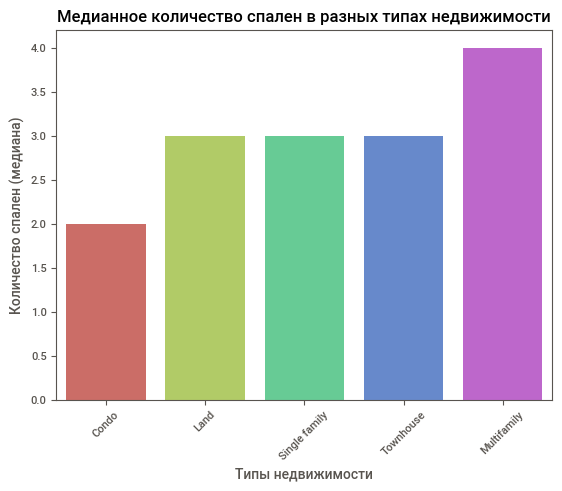

In [ ]:
# Вычислим медианное значение спален для разных типов недвижимости
proper_bed_med = df.groupby('propertyType')['beds'].agg('median').sort_values()

# Отобразим медианы в виде диаграммы
barplot = sns.barplot(
    data = proper_bed_med.to_frame().reset_index(),
    y = 'beds',
    x = 'propertyType',
    palette = 'hls'
);
barplot.set_title('Медианное количество спален в разных типах недвижимости');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Количество спален (медиана)');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);

В начале работы над проектом было не логично, что у пустых участков **Land** (где нет строений) почемуто есть спальни. Поэтому для таких записей прсваивали признаку **beds** 0 и заменили медианну на 0. На этапе решения задачи регрессии и прогнозирования совместимости, столкнулись с большой ошибкой и низким значением целевой метрики. Тогда было принято решение не обнулять ванные и спльные комнаты у типа недвижимости **Land**.

Объяснение этому может быть следующее: не смотря на пустой участок, предпологается постройка на этом участке конкретных домов с типовым количеством ванных и спальних комнат, которые указаны в объяилении. Так покупатель может расчитывать на определённое количество спальных и ванных комнат.

В подтверждении о проделанной работы, закоментиравалли и не удалили участки кода, где ранее производилось обнуление.

#### Заполним пропуски и заменим нули. Наши действия:
1. сгрупируем данные по типу недвижимости,
2. вычислим коэффициент отношения спален к ванным для каждого типа недвижимости (он может отличаться от общего 1.25),
3. в качестве замены пустому значению или нулю, используем неибольшее из двух: медианну или число ванны комнат умноженное на вычисленный коэффициент.  

In [ ]:
# Участок кода, гда вначале мы обнуляли спальни у всех объектов Land...
#df.loc[df[df['propertyType'] == 'Land'].index, 'beds'] = 0
# и заменяли значение медианы с 3 на 0
#proper_bed_med['Land'] = 0.0

# Запускаем цикл по всем типам недвижимости
for p in proper_bed_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = df['beds'].isna() == True # маска по пропускам в beds
    mask3 = df['beds'] == 0 # маска по нулям в beds
    ind = df[mask1 & (mask2 | mask3)]['beds'].index # сохраняем индекс
    coef = (df[mask1].beds / df[mask1].baths).median() # вычисляем коэффициент
    # Присваиваем или медиану, или число ванных*коэф. - что больше
    # (причем важно сравнивать именно в таком порядке, чтобы не получить nan)
    df.loc[ind, 'beds'] = df.loc[ind, 'beds']\
                          .apply(lambda x: max(proper_bed_med[p], x*coef))

# Проверяем, что все пропуски заполнены
print('Осталось пропусков в признаке beds:', df['beds'].isna().sum())
# Проверяем, что нулевое количество спален не осталось ни в одном типе жилья
display('Нулевое количество спален в различных типах жилья:',
        df[df['beds'] == 0].groupby('propertyType')['beds'].count())

del mask1, mask2, mask3, ind, coef, proper_bed_med # очистим память

Осталось пропусков в признаке beds: 0


'Нулевое количество спален в различных типах жилья:'

,beds
propertyType,


### 3.10 Обработка признак **state**
На этапе **EDA** - возникла неоходимость обработки признака - **state**. Действуя в парадигме **CRISP-DM**, перенесём манипуляции над признаком  в раздел предобработки в целях сохранения прозрачности и последовательности процесса.

В признаке обнаружились несуществующие названия штатов. Соберём их в таблицу с количеством записей и способом устранения ошибок.

| Ошибка | Записей| Устранение |
|---|---:|---|
| F1 | 1 | Заменить на FL |
| DC | 4513 | Заменить на WA|
| BA | 1 | Удалить |
| OS | 1 | Удалить |
| OT | 1 | Удалить |

In [ ]:
# Заменим неверные аббревиатуры шатов
df.loc[df[df['state'] == 'Fl'].index, 'state'] = 'FL'
df.loc[df[df['state'] == 'DC'].index, 'state'] = 'WA'

# По остальным сохраним индекс и удалим записи по индексам
ind = []
ind.extend(df[df['state'] == 'BA'].index)
ind.extend(df[df['state'] == 'OS'].index)
ind.extend(df[df['state'] == 'OT'].index)
df.drop(ind, axis=0, inplace=True)

del ind # очистим память

### 3.11 Обработка признака **target**
Целевой признак стоимости объукта недвижимости оценивается в долларах США.

Очистим его от:
* символа валюты - ($),
* разделителя разрядов(запятой),
* знака плюс (+) в конце,
*  прведём к типу **int**

Далее проверим на наличие выбросов и снова сгруппируем данные по типу недвижимости.  

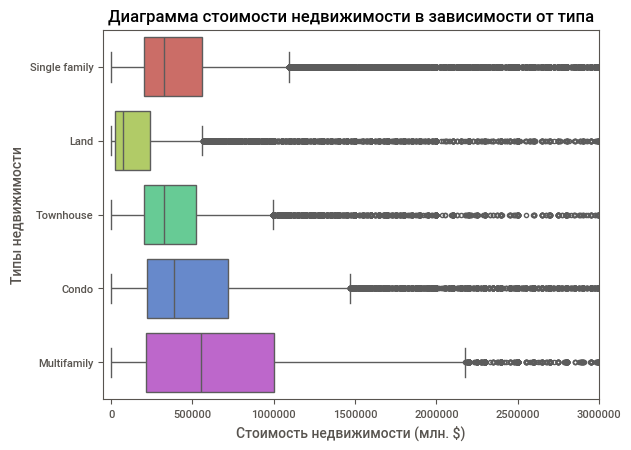

In [ ]:
# Очищаем признак target
df['target'] = df['target'].str.replace('$', '', regex=False)
df['target'] = df['target'].str.replace(',', '', regex=False)
df['target'] = df['target'].str.replace('+', '', regex=False).astype(int)

# Построим диаграмму целевого признака с разбивкой на типы жилья
boxplot = sns.boxplot(
    data = df,
    x = 'target',
    y = 'propertyType',
    palette = 'hls'
);
boxplot.set(xlim=(-50000,3000000)); # ограничим диапазон из-за выбросов
boxplot.set_title('Диаграмма стоимости недвижимости в зависимости от типа');
boxplot.set_xlabel('Стоимость недвижимости (млн. $)');
boxplot.set_ylabel('Типы недвижимости');

На диаграмме видно, что распределение стоимости недвижимости в группах далеко от нормального (Тест Шапиро-Уилка - это подтверждает), поэтому применение теста Тьюки не актуально.

Попробуем пролагорифмироиать признак.

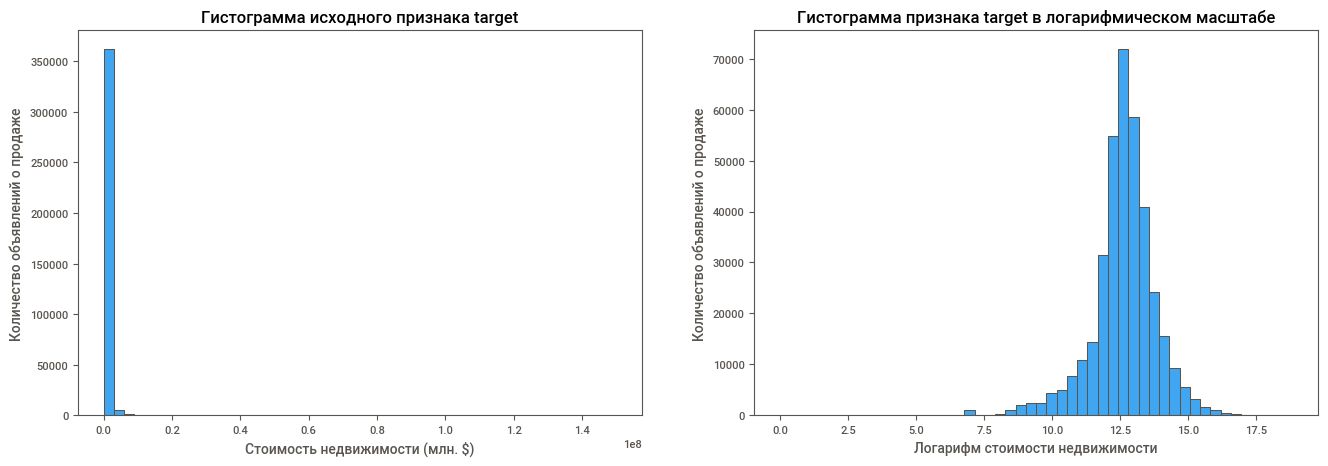

In [ ]:
# Построим две гистограммы признака target: без логарифмирования и с таковым
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Гистограмма исходного признака
histplot = sns.histplot(
    data = df['target'],
    bins = 50,
    ax = axes[0]
);
histplot.set_title('Гистограмма исходного признака target');
histplot.set_xlabel('Стоимость недвижимости (млн. $)');
histplot.set_ylabel('Количество объявлений о продаже');

# Гистограмма признака в логарифмическом масштабе
log_target = np.log(df['target']) # min(target) > 0, поэтому смело берем log
histplot = sns.histplot(
    data = log_target,
    bins=50,
    ax=axes[1]
);
histplot.set_title('Гистограмма признака target в логарифмическом масштабе');
histplot.set_xlabel('Логарифм стоимости недвижимости');
histplot.set_ylabel('Количество объявлений о продаже');

Благодаря логарифмированию удалось привести распределение признаков практически к нормальному.

Для выявления выбросов воспользуемся z-отклонений (трёч сигм). При этом в первых итерациях отходили от распространённых трёх стандартных отклонений (в сторону их увеличения) в виду того, что объекты с максимальной стоимостью в датафрейме (с выше 100 мил. $) существуют - это большие земельные участки и дорогие дома, которые можно увидеть на Googl Maps по адресу из признака **strit**, также расширяли левую границу, посколько наблюдали большое колличество не дорогих объектов недвижимости разных типов.

Но на этапе пргнозирования столкнулись с низким значением целевой метрики, в результате чего нам пришлось усилить критерии определения выбросов и в итоге сузить границы отклонений с 3 до 2.

Напишем функцию для определения выбросов, которая пригодиться и в разделе **EDA**. Построим гистограммы, на которых отобразим границы выбросов для каждого типа недвижимости.

In [ ]:
# Функция определения выбросов по методу z-отклонений (трех сигм)
def outliers_z_score(df: pd.DataFrame,
                     feature: str,
                     log_scale: bool = True,
                     left: int = 3,
                     right: int = 3) -> tuple:
    """Функция определяет выбросы среди наблюдений по методу
    z-отклонения, или трех сигм (количество сигм регулируется
    в вызывающем операторе).

    Args:
        df (pd.DataFrame): исходный датафрейм
        feature (str): признак, в котором определяем выбросы
        log_scale (bool): переход к лог. масштабу, по умолчанию = True
        left (int): кол-во сигм для нижней границы, по умолчанию = 3
        right (int): кол-во сигм для верхней границы, по умолчанию = 3

    Returns:
        tuple (pd.DataFrame): датафреймы с выбросами и очищенный
    """

    # Если требуется переход к логарифмическому масштабу
    if log_scale:
        if df[feature].min() > 0: # если значения признака больше 0
            x = np.log(df[feature])
        else:
            x = np.log(df[feature]+1) # иначе добавляем единицу
    else:
        x = df[feature]

    # Вычисляем мат.ожидание и стандарт. отклонение
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma

    # Определяем выбросы и очищенные данные
    outliers = df[(x < lower_bound) | (x > upper_bound)]
    cleaned = df[(x > lower_bound) & (x < upper_bound)]

    # Возвращаем кортеж из pd.DataFrame
    return outliers, cleaned

In [ ]:
# Создадим списки типов недвижимости ...
property_list = list(df['propertyType'].unique())
# и границ метода z-отклонений для них
boundaries = [(2,2), (2,2), (2,2), (2,2), (2,2)] # первоначальные границы были 3+
# Объединим их в словарь
prop_bound = dict(zip(property_list, boundaries))
# Подготовим список названий цветов для гистограмм
hist_colors = ['blue', 'orange', 'green', 'red', 'purple']

# Добавим признак выброса в датафрейм и установим нули
df['outliers'] = 0

# В цикле вычислим выбросы для каждого типа недвижимости
for i, p_type in enumerate(prop_bound):
    # Определяем выборосы с помощью написанной функции
    outliers, cleaned = outliers_z_score(df = df[df['propertyType'] == p_type],
                                         feature = 'target',
                                         log_scale = True,
                                         left = prop_bound[p_type][0],
                                         right = prop_bound[p_type][1])

    print(f'Число выбросов по методу z-отклонений для {p_type}: {outliers.shape[0]}')
    print(f'Результирующее число записей для {p_type}: {cleaned.shape[0]}\n')
    # Установим флаг выброса в признаке
    df.loc[outliers.index, 'outliers'] = 1
# Подведем итог
print(f'Всего по методу z-отклонений выявлено {df.outliers.sum()} выбросов.')

Число выбросов по методу z-отклонений для Single family: 14394
Результирующее число записей для Single family: 238289

Число выбросов по методу z-отклонений для Land: 985
Результирующее число записей для Land: 30333

Число выбросов по методу z-отклонений для Townhouse: 1278
Результирующее число записей для Townhouse: 24945

Число выбросов по методу z-отклонений для Condo: 2343
Результирующее число записей для Condo: 46606

Число выбросов по методу z-отклонений для Multifamily: 523
Результирующее число записей для Multifamily: 10782

Всего по методу z-отклонений выявлено 19523 выбросов.


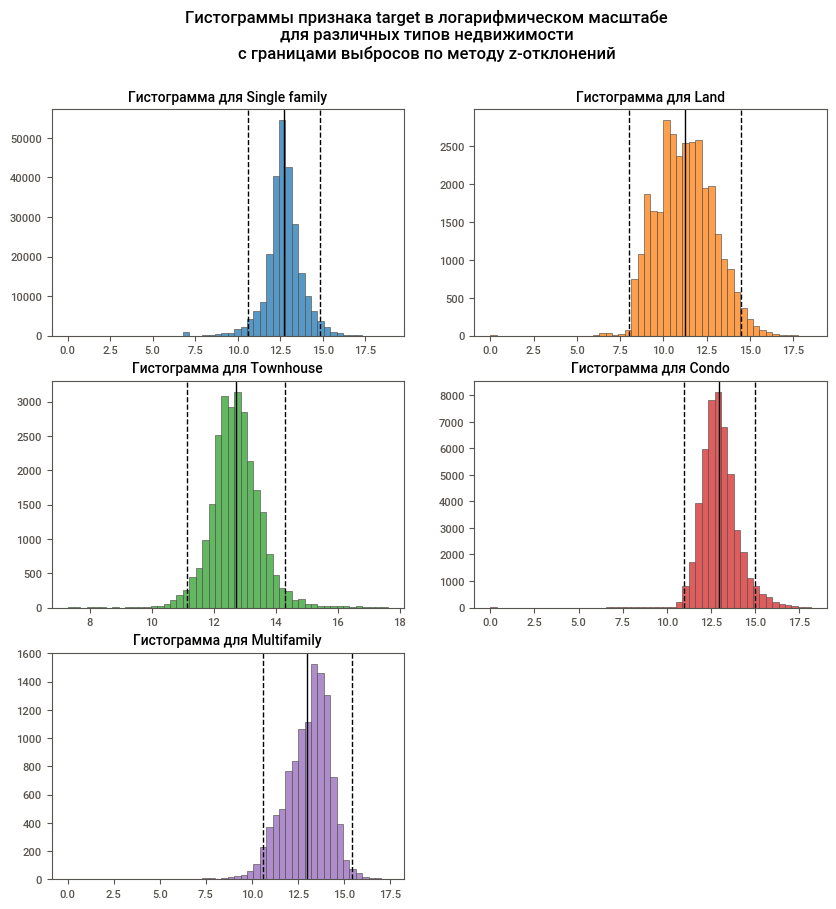

In [ ]:
# Следом построим гистограммы для каждого типа с границами выбросов
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
fig.suptitle('Гистограммы признака target в логарифмическом масштабе\n'+\
             'для различных типов недвижимости\n'+\
             'с границами выбросов по методу z-отклонений', fontsize=12);

# Снова воспользуемся циклом
for i, p_type in enumerate(prop_bound):
    # Переводим признак в логарифмическую шкалу
    if df[df['propertyType'] == p_type]['target'].min() > 0:
        log_target = np.log(df[df['propertyType'] == p_type]['target'])
    else:
        log_target = np.log(df[df['propertyType'] == p_type]['target']+1)

    # Вычисляем границы выбросов
    upper_bound = log_target.mean() + prop_bound[p_type][1] * log_target.std()
    lower_bound = log_target.mean() - prop_bound[p_type][0] * log_target.std()

    # Строим гистрограмму для каждого типа недвижимости
    histplot = sns.histplot(
        data = log_target,
        bins = 50,
        ax = axes[divmod(i, 2)],
        color = 'tab:' + hist_colors[i]
    );
    histplot.axvline(log_target.mean(), color='k', lw=1)
    histplot.axvline(upper_bound, color='k', ls='--', lw=1)
    histplot.axvline(lower_bound, color='k', ls='--', lw=1)
    histplot.set_title(f'Гистограмма для {p_type}', fontsize=10);
    histplot.set_xlabel('');
    histplot.set_ylabel('');
fig.delaxes(axes[2, 1]); # удалим неиспользуемое поле

На гистограммах наименее нормальные распределения имеют типы недвижимости **Land** and **Multifamely**.

Гистограмма ненормальности для земельных участков связанна с их различными размерами.

В группе малосемейных домов наблюдается левосторонняя ассиметрия из за большого числа домов по цене ниже моды. Наиболее популярный сегмени на гистограмме обозначен тремя столбцами начиная с модыБ в след закоторыми число объектов резко падает.

На всех гистограмма видно хвосты и аномальные всплески от центра. Все эти записи вносили болшую ошибку в прогноз, поэтому так сильно сузили границы отклонений (до 2).

В итге отобрали почти 19.5 тыс. выбросов и пометили их специальным флагом в признаке **outliers**. В разделе **EDA** в первую очередь попробуем скоректирова стоимости эти объектов с помощью десериализованного признака цены за квадратный фут. Если это не поможет, то окончательно удалим их из датафрейма.

Перед дальнейшей обработкой датафрейма посмотрим на распределение стоимости объектов по штатам.

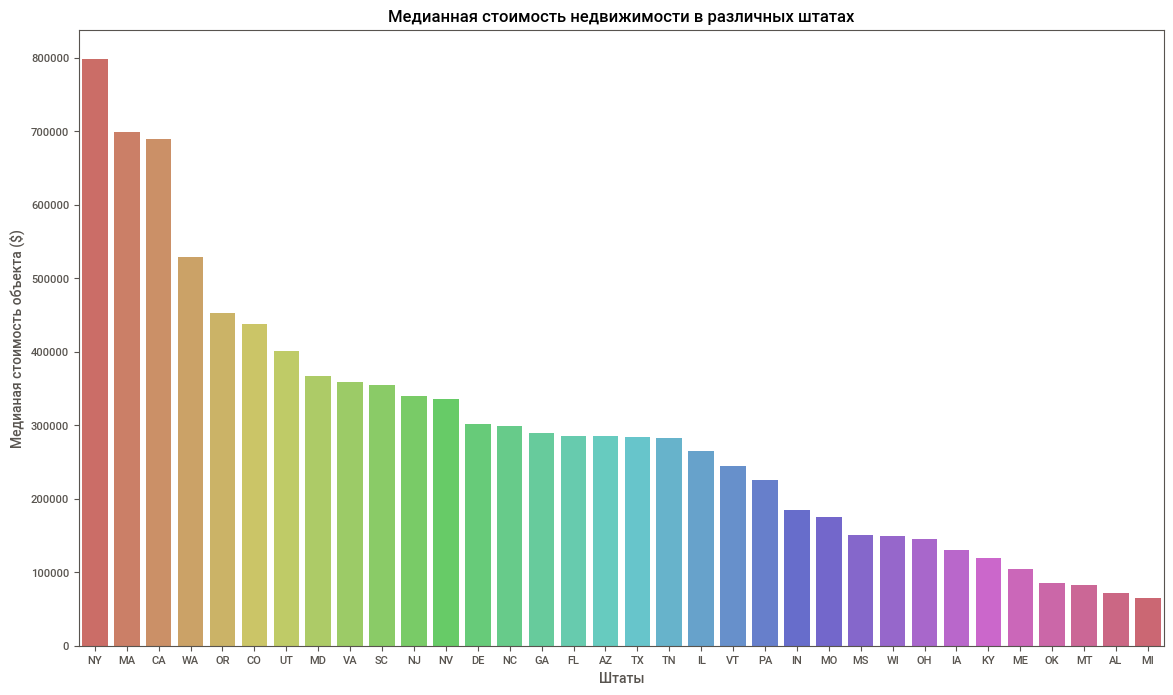

In [ ]:
# Сгруппируем объекты по штатам и посчитаем медиану
state_target_gr = df.groupby('state')['target'].median()
state_target_gr = state_target_gr.to_frame(name='median').reset_index()
state_target_gr = state_target_gr.sort_values(by='median', ascending=False)

# Построим график зависимости стоимости от штата
fig = plt.figure(figsize=(14, 8))
barplot = sns.barplot(
    state_target_gr,
    x = 'state',
    y = 'median',
    palette ='hls'
);
barplot.set_title('Медианная стоимость недвижимости в различных штатах');
barplot.set_xlabel('Штаты');
barplot.set_ylabel('Медианая стоимость объекта ($)');

Самая дорогая недвижимость в штате Нью-Йорк, затем Массачуссец и Калифорния. Флорида, с развитой инфраструктурой курортных и яхтенных зон находиться в середине графика, это не ожиданно.

Самые дешовые объекты в Мичигане, Алабаме и Монтане.

Распределение по штатам яркое, в отличии от принадлежности объектов недвижимости городам. Можно сказать, что стоимость изменяется пловно (при сортировке).

Это подтверждает наши основания в разделе **EDA** при обработке признаков отопления и кондицианирования, групперовать объекты именно по штатам, а не по городам.

Можно было бы посмотреть на зависимость стомости объектов от его площадей, но это сделаем после удаления выбросов в признаках **sqft** и **target** в разделе **EDA**, поэтому сейчас диаграмма будет не информативна.

Перехдим к **baseline-решению**

### 4. Базовое решение задачи предсказания **Basline modeling**
Предобработка и очистка данных завершенна - построим **baseline-решение**. Используем два решения:
* модель обратной регрессии, на её примере увидем результат дальнейшей обработки данных в разделе **EDA**,
* модель **CatBoostRegressor**, с параметрами по умолчанию, чтобы продемонстрировать высокий результат после предварительной обработки данных.

Перед обучением моделей отбросим необработанные признаки - **strit, homeFacts, city, schools** и закодируем оставшиеся категориальные.

Избавиммся от пропущенных заначений в признаке **sqft** (которые обработаем в следующем разделе). Их доля составляет 11% и это не должно повлиять на результат.

Для оценки качества моделирования на протяжения всего проекта, будем использовать три метрики качества:
* **MAE** - среднюю абсолютную ошибку, что бы понимать, на сколько тысяч долларов ошиблась модель,
* **MAPE** - среднюю обсолютную ошибку в процентах, поскольку стоимость жилья - вещь относительная,
* **R2** - коэфициент детерминации, что бы понимать, на сколько хорошо модель улавливае закономерности - целевая метрика.  

In [ ]:
# Избавимся от текстовых признаков
df_baseline = df.drop(['street', 'homeFacts', 'city', 'schools'], axis=1)
# Избавимся от пропущенных значений
df_baseline = df_baseline.dropna()

# Избавимся от выбросов, найденных при обработке "target"
ind = df_baseline[df_baseline['outliers'] == 1].index
df_baseline = df_baseline.drop(ind, axis=0)
del ind

# Отобразим кол-во уникальных значений для выбора метода кодировки
display('Количество уникальных значений в категориальных признаках:',
        df_baseline.select_dtypes(include='object').nunique())

'Количество уникальных значений в категориальных признаках:'

,0
status,5
propertyType,5
state,33
stories,4


Для приизнака **state**  используем **Binary Encoder** (число уникальных значений выше 15), для отальных **OneHotEncoder**

In [ ]:
# Создаем список признаков для одиночного кодирования
oh_cols = ['status', 'propertyType', 'stories']
# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.OneHotEncoder(cols=oh_cols, use_cat_names=True)
encoded_data = encoder.fit_transform(df_baseline[oh_cols])
# Присоединяем к датафрейму закодированные признаки
df_baseline = pd.concat([df_baseline, encoded_data], axis=1)

# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.BinaryEncoder(cols=['state'])
encoded_data = encoder.fit_transform(df_baseline[['state']])
# Присоединяем к датафрейму закодированные признаки
df_baseline = pd.concat([df_baseline, encoded_data], axis=1)

# Удалим исходные признаки и выведем размер датафрейма
df_baseline = df_baseline.drop(['status', 'propertyType', 'stories', 'state'], axis=1)
print('Размер получившегося датафрейма:', df_baseline.shape)

Размер получившегося датафрейма: (305224, 25)


In [ ]:
# Подготовим выборки
X = df_baseline.drop('target', axis=1)
y = df_baseline['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

# Проверим размерности
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(213656, 24) (91568, 24) (213656,) (91568,)


In [ ]:
# Функция для расчета метрик и вывода на экран
def show_metrics(y_train: pd.Series,
                 y_train_pred: pd.Series,
                 y_test: pd.Series,
                 y_test_pred: pd.Series,
                 precision: int = 2,
                 show: bool = True) -> tuple:
    """Функция выводит на экран значения метрик MAE, MAPE и R2
    с заданной точностью, а также возвращает их.

    Args:
        y_train (pd.Series): тренировочный вектор ответов
        y_train_pred (pd.Series): тренировочный предсказанный вектор
        y_test (pd.Series): тестовый вектор ответов
        y_test_pred (pd.Series): тестовый предсказанный вектор
        precision (int): точность округления, по умолчанию = 2
        show (bool): флаг вывода на экран, по умолчанию = True

    Returns:
        tuple (float): кортеж из 6 метрик на случай необходимости
    """

    # Вычислим метрики и выведем их на экран
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)*100
    r2_train = r2_score(y_train, y_train_pred)

    mae_test = mean_absolute_error(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)*100
    r2_test = r2_score(y_test, y_test_pred)

    if show: # если флаг вывода на экран установлен
        print('MAE на тренировочоной выборке:', round(mae_train, precision))
        print('MAPE на тренировочной выборке:', round(mape_train, precision))
        print('r2 на тренировочоной выборке:', round(r2_train,2))

        print('\nMAE на тестовой выборке:', round(mae_test, precision))
        print('MAPE на тестовой выборке:', round(mape_test, precision))
        print('r2 на тестовой выборке:', round(r2_test,2))

    # Вернем вычисленные метрики
    return mae_train, mape_train, r2_train, mae_test, mape_test, r2_test

In [ ]:
# Обучим модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Выполним предсказание
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# И выведем результаты
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

MAE на тренировочоной выборке: 247260.4
MAPE на тренировочной выборке: 84.0
r2 на тренировочоной выборке: 0.25

MAE на тестовой выборке: 249292.8
MAPE на тестовой выборке: 84.66
r2 на тестовой выборке: 0.25


In [ ]:
# Обучим модель CatBoostRegressor
# Подготовим выборки в формате класса Pool
train_pool = Pool(X_train,
                  y_train)
test_pool = Pool(X_test)

# Создаем модель с параметрами по умолчанию
model = CatBoostRegressor(random_state = 42,
                          verbose = False)

# Обучаем модель
model.fit(train_pool)

# Делаем предсказание
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

MAE на тренировочоной выборке: 168579.74
MAPE на тренировочной выборке: 50.31
r2 на тренировочоной выборке: 0.59

MAE на тестовой выборке: 173372.56
MAPE на тестовой выборке: 51.68
r2 на тестовой выборке: 0.57


In [ ]:
# Очистим память
del df_baseline, X, y, X_train, X_test, y_train, y_test,\
    train_pool, test_pool, model, y_train_pred, y_test_pred

#### Выводы по **baseline modeling**
1. Модель **LinearRegression** на тестовых данных показала не удовлетворительны результаты, ошибка 284 тыс.$, или 84%, коэффициент детерминации = 0.25 (наилутшее значение = 1). Это означает, что модель не уловила закономерностей в данных. Позже будет видно на сколько большее значение влияет на качественную обработку данных и EDA при улутшении показателей этой модели.

2. Модель **CatBoostRegressor** показала гораздо лутшие результаты, ошибка в 173 тыс.$, или 51% на тестовых данных,  **R2** = 0.57 (хорошими считается показания выше 0.5). Это говорит о качестве модели, с базовыми настройками улавливать связи в данных. Далее будем сравниватть наши показатели и с этой оценкой.

### 5. Разведовательный анализ данных (Data Preparation - EDA).
В этом разделе займёмс десериализацией признаков **homeFacts** и **schools** которые дополнят датафрейм и закончим обработку других признаков, которые частично очистили в **разделе 3**.

Так же выдвинем гипотизы о взаимосвязи признаков и подтвердим, или опровергнем их с применением визуализации.

#### 5.1. Обработка признака **homeFacts**
В этом признаке содержится сериализованный словарь данных об объекте недвижимости
* Year duilt - год постройки
* Remodeled year - год обновления
* Heating - вид отопления
* Cooling - вид охлождения
* Parking - наличие парковки
* Lotsize - размер участка
* Price/sqft - цена за квадратный фут

Напишем функцию, которая будет предобрабатывать строку находящуюся в ячейке и десериализовывать её, возвращая 7 перечисленных значений. Эти значения будем записывать  в 7 одноимённых признаков в дататафрейме, которые для этого  создадим. Обработкой сохранённых значений займёмся на следующем шаге.

In [ ]:
# Функция десериализации строки со словарем значений
def deserialize_home(s: str) -> pd.Series:
    """Функция возвращат значения словаря, который находится
    в сериализованном виде в строке s.

    Args:
        s (str): строка с сериализованным словарем

    Returns:
        pd.Series: список из значений словаря в виде объекта Series
    """

    # Десериализуем строку в словарь и сразу сохраним его единственое значение
    # json.loads() не подошел, т.к. в признаке неодинаковое использование
    # одинарных кавычек, поэтому используем eval()
    result = eval(s)['atAGlanceFacts']

    # В единственном значении словаря хранится список из 7 элементов,
    # каждый из которых представлен двумя словарями: factValue и factLabel
    # С помощью дополнения списка сохраним в список только factValue
    # и вернем их, а там уже присвоим 7-ми признакам
    return pd.Series([r['factValue'] for r in result])

In [ ]:
# Воспользуемся написанной функций, чтобы создать новые признаки из homeFacts
df[['yearBuilt', 'remodeledYear', 'heating', 'cooling',
    'parking', 'lotsize', 'price_sqft']] = df['homeFacts'].apply(deserialize_home)

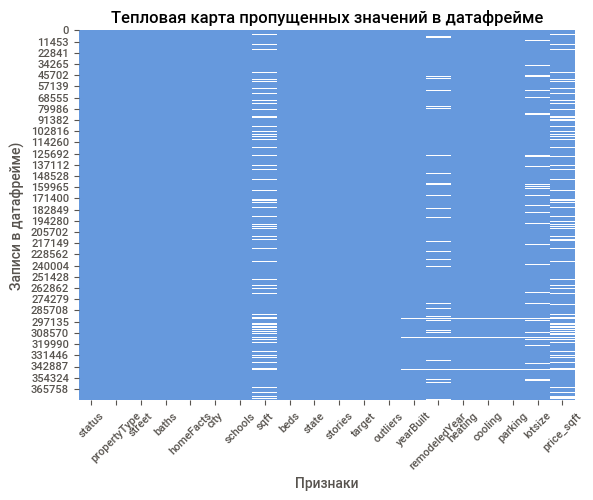

In [ ]:
# Построим тепловую карту пропущенных значений в датафрейме
heatmap = sns.heatmap(
    data = df.isnull(),
    cmap = sns.color_palette(['#69d', 'white']),
    cbar = False
);
heatmap.set_title('Тепловая карта пропущенных значений в датафрейме');
heatmap.set_xlabel('Признаки');
heatmap.set_ylabel('Записи в датафрейме)');
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45);

В десериализованных данных содержаться пропуски, придёться их обработать

### 5.2 Обработка признаков **yearBuilt** и **remodeledYear**
Вычислим возраст здания или участка. Для этого возьмём наибольшее из двух значений (год постройки или год обновления) и сравним с текущим годом 2024.
Сперва, придется объединить эти два признака, заполнить пустые значения.

In [ ]:
# Посчитаем пропущенные значения в новых признаках (NaN + пустые ячейки)
yb_na = df['yearBuilt'].isna().sum()
yb_na += df[df['yearBuilt'] == ''].shape[0]
yb_na_share = round(yb_na / df.shape[0] * 100, 2)

yr_na = df['remodeledYear'].isna().sum()
yr_na += df[df['remodeledYear'] == ''].shape[0]
yr_na_share = round(yr_na / df.shape[0] * 100, 2)

print(f'Количество пустых ячеек в yearBuilt - {yb_na}, что составляет {yb_na_share}%.')
print(f'Количество пустых ячеек в remodeledYear - {yr_na}, что составляет {yr_na_share}%.')

Количество пустых ячеек в yearBuilt - 61745, что составляет 16.67%.
Количество пустых ячеек в remodeledYear - 222321, что составляет 60.01%.


In [ ]:
# Функция объединения признаков yearBuilt и remodeledYear
def year_compare(b, r):
    """Функция получает на вход значение года из двух ячеек,
    сравнивает их друг с другом и возвращает наибольшее из двух.
    Предусмотрена обработка значений типа None и np.NaN: если
    только одно из переданных значение имеет данный тип, то
    возвращается второе. Если же оба значения не содержат год,
    то возвращается None с целью последующего заполнения.

    Args:
        b (str | NoneType): значение признака yearBuilt
        r (str | NoneType): значение признака remodeledYear

    Returns:
        str | NoneType: наибольший год из двух, либо None
    """

    if (b == np.NaN) or (b == None) or (b == ''): # если в b - нет года
        if (r is np.NaN) or (r == None) or (r == ''): # и в r - нет года
            result = None # то вернем - None
        elif r.isdigit(): # если  в r - есть год
            result = r # то вернем r
        else:
            result = None # иначе вернем None (маловероятный сценарий)
    elif b.isdigit(): # если же в b - есть год
        if (r == np.NaN) or (r == None) or (r == ''): # в r - нет года
            result = b # то вернем b
        elif r.isdigit(): # если в r - тоже есть год
            if int(b) >= int(r): # сравним, если b больше или равен r
                result = b # то вернем b
            else:
                result = r # иначе - r
        else:
            result = None # если r - не None, и не год, то вернем - b
    else:
        result = None # если ни одно не год и не None, то вернем None (маловероятный сценарий)

    #Возвращаем результат работы функции (в виде строки)
    return result

# Создадим признак, объединяющий - yearBuilt, remodeledYear - с помощью функции - year_compare
df['lastYear'] = df[['yearBuilt', 'remodeledYear']].apply(lambda x: year_compare(*x), axis=1)

In [ ]:
# Вычислим медианное значение года постройки или обновления для разных типов недвижимости
proper_year_med = df.groupby('propertyType')['lastYear'].median().sort_values()

# Отобразим медианы в виде диаграммы
barplot = sns.barplot(
    data = proper_year_med.to_frame().reset_index(),
    y = 'lastYear',
    x = 'propertyType',
    palette = 'hls'
);
barplot.set_title('Медианное значение года постройки/обновления недвижимости');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Год постройки/обновления (медиана)');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);
barplot.set(ylim=(1920,2020)); # ограничение диапазона по вертикали для наглядности

На диаграмме видно, что давно построиными и не оновляющими, являются многосемейные дома. Которые возможно были распространнены в своё время и отживают его.

Частные дома строились и раньше, но в нашей базе находятся именно такие участки и с таким годом.

Далее можно проследить эволюцию. Примерно одинаково развивались односемейные и частные дома в небольших городах, пригородах и квартиры в крупных городах. Затем возникли новые проекты типов жилья - **Townhouse**. Вероятно, что  с таким развитием связанны годы постройки и обновления соответствующих типов жилья в датафрейме.

Используем эти медианные значения, для заполнения пропусков в признаке, а затем создадим новый **age** - куда сохраним возраст жилья или участка.

In [ ]:
# Запускаем цикл по всем типам недвижимости и заполняем пропуски медианой
for p in proper_year_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = df['lastYear'].isna() == True # маска по пропускам в lastYear
    ind = df[mask1 & mask2]['lastYear'].index # сохраняем индекс
    df.loc[ind, 'lastYear'] = proper_year_med[p] # приcваиваем медиану

# Приводим к типу int, потому что даты как таковой в признаке нет
df['lastYear'] = df['lastYear'].astype(int)

# Проверяем, что все пропуски заполнены
print('Осталось пропусков в признаке lastYear:', df['lastYear'].isna().sum())

Проверим на выбросы в признаке года постройки/обновления, на основе коробчатой диограммы.

Text(0, 0.5, 'Типы недвижимости')

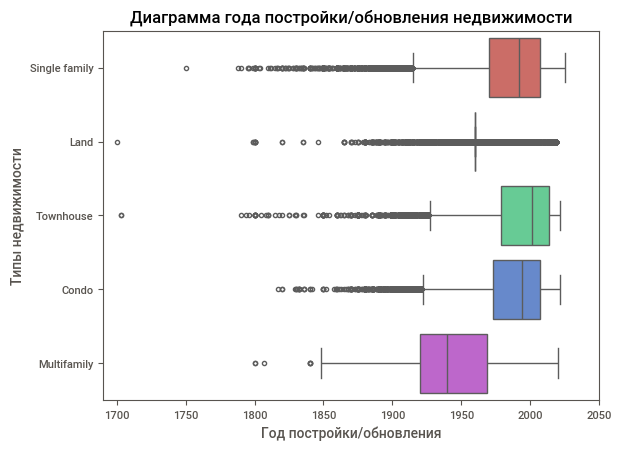

In [ ]:
# Построим коробчатую диаграмму признака lastYear
boxplot = sns.boxplot(
    data=df,
    x='lastYear',
    y='propertyType',
    palette = 'hls'
);
boxplot.set(xlim=(1690,2050));
boxplot.set_title('Диаграмма года постройки/обновления недвижимости');
boxplot.set_xlabel('Год постройки/обновления');
boxplot.set_ylabel('Типы недвижимости')

Исходя из диаграммы, примем за выбросы все даты до 1700 года и после 2020 года. Заменим их на медианны и сгенерируем новый признак возраста.

In [ ]:
# Запускаем цикл по всем типам недвижимости и заменяем выбросы медианой
for p in proper_year_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = (df['lastYear'] < 1700) | (df['lastYear'] > 2022) # маска по выбросам
    ind = df[mask1 & mask2]['lastYear'].index # сохраняем индекс
    df.loc[ind, 'lastYear'] = proper_year_med[p] # приcваиваем медиану

# Генерируем признак возраста
df['age'] = 2023 - df['lastYear']

# Удаляем ненужные более признаки
df.drop(['yearBuilt', 'remodeledYear', 'lastYear'], axis=1, inplace=True)

# Очистим память
del proper_year_med, p, mask1, mask2, ind

### 5.3. Обработка признаков - **heating, cooling, parking**
Начнём с провеки пустых значений.

In [ ]:
# Создадим список из трех десериализованных признаков, с которыми будем работать одновременно
hcp_list = ['heating', 'cooling', 'parking']

# Проверим пропуски в них
for f in hcp_list:
  print(f'В признаке {f} найдено {df[f].isna().sum()} пропуска,\
  это {round(df[f].isna().sum()/df.shape[0]*100,2)}% датафрейма.')

В признаке heating найдено 3422 пропуска,  это 0.92% датафрейма.
В признаке cooling найдено 3422 пропуска,  это 0.92% датафрейма.
В признаке parking найдено 3422 пропуска,  это 0.92% датафрейма.


На первый взгляд пропусков мало, но при детальном исследовании этих признаков выявлено содержание большого количества повторяющихся значений:
* пустых строк
* нулей
* значений 'No Data'
* значений типа None Type

Отнести их к котегории пропущенных будет не верно потому, что их процент в датафрейме сразу увеличиться до 30-50%

В действительности мы имеем дело с удобствами в жилище: наличие/отсутствие отопления (любого вида), кондиционирования и парковки. В этой связи условимся так трактовать часто встречающиеся значения:

* пропуск, отсутствие информации: NaN, None (как тип NoneType без кавычек), 'No Data',
* отсутствие удобства в доме: ' ' (пустая строка в кавычках), '0', 'None' (вручную вписанное значение в кавычках),
* наличие удобства: все остальные разнообразные значения, не вошедшие в предыдущие две группы.

Напишем функцию, которая реализует соответствующее преобразование и применим ее к трем признакам. А затем сразу перепроверим количество отсутствующих значений.

In [ ]:
# Функция для приведения всех значений признаков к трем категориям
def three_state_feat(s: str) -> str:
    """Функция получает на вход значение из признака и относит
    его к одной из трех категорий: пропуск, отсутствие
    удобства (отопления/кондиционирования/парковки) или
    его наличие. Возвращает одну из трех категорий в виде строки.

    Args:
        s (str | NoneType): значение признака (heating, cooling, parking)

    Returns:
        str: одна из трех категорий
    """

    if (s is None) or (s is np.NaN) or (s == 'No Data'):
        result = 'missing' # категория пропуска
    elif (s == '') or (s == 'None') or (s == '0'):
        result = 'No' # удобство отсутствует
    else:
        result = 'Yes' # иначе удобство есть в наличии

    # Возвращаем результат
    return result

# Применим написанную функцию к трем признакам
for f in hcp_list:
    df[f] = df[f].apply(three_state_feat)

# Проверим отсутствующие значения в признаках после обработки
for f in hcp_list:
  mis = df[df[f] == 'missing'].shape[0]
  print(f'В признаке {f} найдено {mis} отсутствующих значений,\
  это {round(mis/df.shape[0]*100,2)}% датафрейма.')

В признаке heating найдено 11743 отсутствующих значений,  это 3.17% датафрейма.
В признаке cooling найдено 13735 отсутствующих значений,  это 3.71% датафрейма.
В признаке parking найдено 16310 отсутствующих значений,  это 4.4% датафрейма.


В итоге, количество пропущенных значений выросло, заполним их.

Наличие или отсутствие отопления в домах распределилось 70/30, так же с кондиционированием, а с парковками распределение 50/50.

Логично предположить, что в домах расположенных в тёплых широтах отопление менее востребованно чем кондиционирование. В северных широтах противополжно. Разумно будет сгруперовать записи по штатам.

Парковочное место имеется в каждом частном доме, а крупных городах редко. Следовательно для признака **parking** - больше подходит групировка по названию города.

Но начнём с групировки по признаку **state** - и проверим предположения. Для того, что бы проследить связь с климатом, к таблицам добавим скаченные из интернета данные по среднегодовым температурам по штатам. Чтобы упростить работу , будем пользоваться климатическим рейтингом штатов, от самого жаркого до сомого холодного.  

**Пояснения по парсингу данных о температуре:**
* Температура в градусах по Френгейту и  Цельсия, а так же рейтинг штата по этим значениям хранятся в тегах **td** - от куда мы их заберём.
* Далее из полученного списка сформируем датафрейм, сохранив в его столбцы названия штатов, температуру в градусах Цельсия и рейтинг.
* Подобным образом будем действовать при формировании связующего датафрейма с названиями и аббревиатурами штатов.

**Наши действия:**
1. Парсим данные о температурах.
2. Объединяем с кросс-таблицами по признакам и иллюстрируем.
3. Выявляем закономерности.

In [ ]:
# Определяем адрес страницы с температурами в штатах и выполняем GET-запрос
url = 'https://www.currentresults.com/Weather/US/average-annual-state-temperatures.php'
response = requests.get(url)
if response.status_code != 200:
    print(f'Ошибка парсинга сайта {url}: {response.status_code}')
# Создаём объект BeautifulSoup, указывая html-парсер
page = BeautifulSoup(response.text, 'html.parser')
# Ищем на странице все строки с данными о температуре по штатам
raw_data = page.find_all('td')
# Из строк формируем список в формате: штат, F, C, рейтинг
temperatures = [r_d.text for r_d in raw_data]

# Фомируем датафрем из названий штатов, средних температур и рейтинга
temp_df = pd.DataFrame(list(zip(temperatures[::4],
                                temperatures[2::4],
                                temperatures[3::4])),
                       columns = ['state_name', 'temp', 'rank'])
# Приведем рейтинг к типу int
temp_df['rank'] = temp_df['rank'].astype(int)


# Теперь проделаем то же самое с целью поиска связки "штат - аббревиатура"
# Определяем адрес страницы с сокращениями штатов и выполняем GET-запрос
url = 'https://www.faa.gov/air_traffic/publications/atpubs/cnt_html/appendix_a.html'

response = requests.get(url)
if response.status_code != 200:
    print(f'Ошибка парсинга сайта {url}: {response.status_code}')
# Создаём объект BeautifulSoup, указывая html-парсер
page = BeautifulSoup(response.text, 'html.parser')
# Ищем на странице все строки с названием и аббревиатурой штата
raw_data = page.find_all('td')
# Из строк формируем список в формате: штат, аббревиатура
states_abb = [r_d.text for r_d in raw_data]

# Фомируем датафрем из названий штатов и их аббревиатур
abb_df = pd.DataFrame(list(zip(states_abb[0::2],states_abb[1::2])),
                       columns = ['state_name', 'state'])
# Удаляем лишние символы в начале каждой ячейки
abb_df['state_name'] = abb_df['state_name'].str.strip()
abb_df['state'] = abb_df['state'].str.strip()

# Объединяем два датафрейма
state_temp_df = pd.merge(
    abb_df,
    temp_df,
    on = 'state_name'
).set_index('state')
state_temp_df.head()

# Посмотрим, что у нас получилось
display('Рейтинг штатов по среднегодовым температурам:', state_temp_df.head())

# Очистим память
del url, response, page, raw_data, temperatures, states_abb, temp_df, abb_df

'Рейтинг штатов по среднегодовым температурам:'

,state_name,temp,rank
state,,,
AL,Alabama,17.1,7
KY,Kentucky,13.1,15
OH,Ohio,10.4,26
AK,Alaska,-3.0,50
LA,Louisiana,19.1,3


In [ ]:
# Функция для создания кросс-таблицы и ее иллюстрации
def cross_diag(feat: str,
               df: pd.DataFrame = df,
               state_temp_df: pd.DataFrame = state_temp_df):
    """Функция строит кросс-таблицу для конкретного признака
    по всем штатам в датафрейме и дополняет ее температурным
    рейтингом штата. Таблица отражает, в каком проценте случаев
    в домах есть удобство (отопление/кондиционирование),
    нет удобстав или информация недоступна.

    Args:
        feat (str): исследуемый признак
        df (pd.DataFrame): исходный датафрейм, по умолчанию = df
        state_temp_df (pd.DataFrame): датафрейм температурного рейтинга

    Returns:
        Функция ничего не возвращает, т.к. выводит диаграммы на экран.
    """

    # Сперва создаем кросс-таблицу с процентами
    # отсутствия и наличия удобства, а также
    # пропущенных значений
    cross = pd.crosstab(
        index = df['state'],
        columns = df[feat],
        normalize = 'index'
    ).sort_values(by='Yes', ascending=False)*100

    # Присоединим датафрейм с рейтингом штатов по температуре
    cross = cross.join(state_temp_df)

    # Создадим словари для подстановки в заголовоки
    word = {'heating': 'отопления',
            'cooling': 'кондиционирования',
            'parking': 'парковок'}
    subtitle = {0: 'Отсутствует в доме',
                1: 'Есть в доме',
                2: 'Данные пропущены'}

    # Выведем на экран диаграммы, иллюстрирующие признак
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))
    fig.suptitle(f'Диаграммы наличия {word[feat]} по штатам', fontsize=18)

    # В цикле строим диаграммы по первым трем столбцам кросс-таблицы
    for i, c in enumerate(cross.columns[0:3]):
        stripplot = sns.stripplot(
            data = cross,
            x = c,
            y = cross.index,
            hue = 'rank',
            palette = 'coolwarm_r',
            size = 10,
            linewidth = 1,
            edgecolor = 'w',
            orient = 'h',
            ax = axes[i],
            legend = False
        );
        stripplot.set(xlim=(-3, 103), xlabel='%', ylabel='',
                      title = subtitle[i]);
        if i == 2:
            stripplot.set(xlim=(-1, 12));
        stripplot.xaxis.grid(False);
        stripplot.yaxis.grid(True);
    sns.despine(fig, left=True, bottom=True);

    del cross, word, subtitle, fig, axes # очищаем память

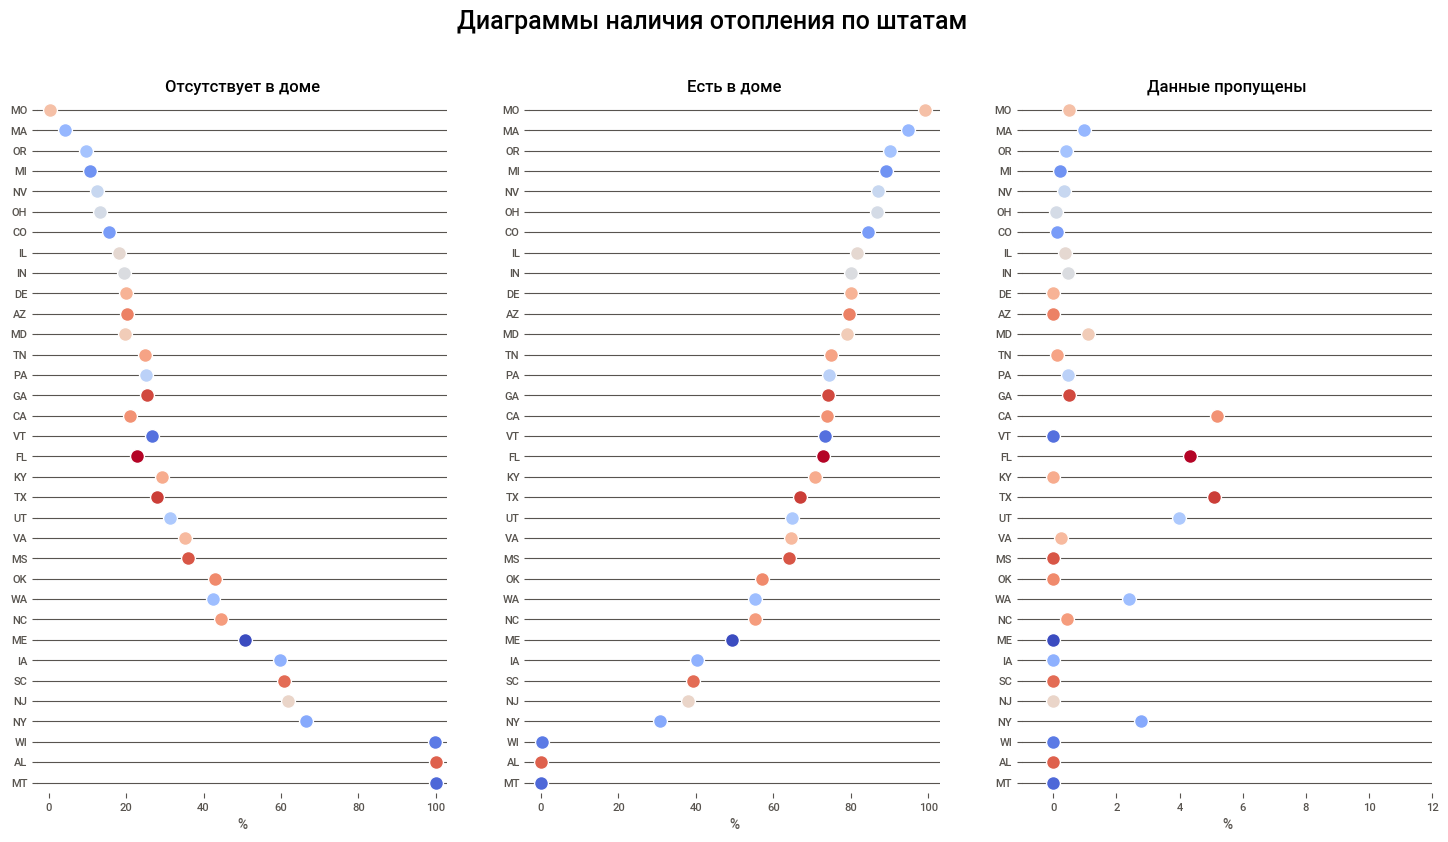

In [ ]:
# Построим диаграммы илюстрирующие наличие/отсутствие отопления
# в зависимости от штата, с помощью написанной выше функции
cross_diag('heating')

Цветовая легенда означает рейтинг штата по среднегодовой температуре - от тёмносинего цвета (сомый холодный штат - **Miane (ME)** в датафрейме), до тёмнокрасного цвета (самый жаркий штат **Florida (FL)**).

Гипотиза состояла в том, что в жарких штатах отопление встречалось реже чем в холодных. На диаграмме это - сосредоточение красных точек в левой чости диаграммы - **Есть в доме**. Следовательно для штатов расположенных в холдных широтах, расположение красных точек в правой части диаграммы. Для диаграммы **Отсутствуют в доме** - противоположные показатели.

Такую закономерность можно выявить например **Отсутствуют в доме** в 20% - голубые и бледнокрасные точки, это означает, что в холодных штатах примерно в 20% домов нет отопления.

По наличию отопления на диаграмме **Есть в доме** - в средней части расположились жаркие штаты - от 60% до *80%. Не смотря на комфортную среднегодовую температуру бывают периуды когда есть необходимость отапливать дом. Другой возможный фактор - это обеспеченные владельцы, для которых наличие отопления не обременительно (камины).

Интересно, что на проавой диаграмме **Данные пропущены** - наибольшее количество записей от 4% до 6% приходиться почти на жаркие штаты. Возможно не верно отнесли значение **None (без кавычек, тип NoneType**) - к пропуску, тогда как в действительности, он обозначал отсутствие отопления в доме?

Пока можносделать вывод, что расположение дома в более жарком штате не означает, что отопление в нём отсутствует. Или противоположно - обязательно присутствует в домах в более холодных штатах.

Рассмотрим наличие/отсутствие кондиционирования.

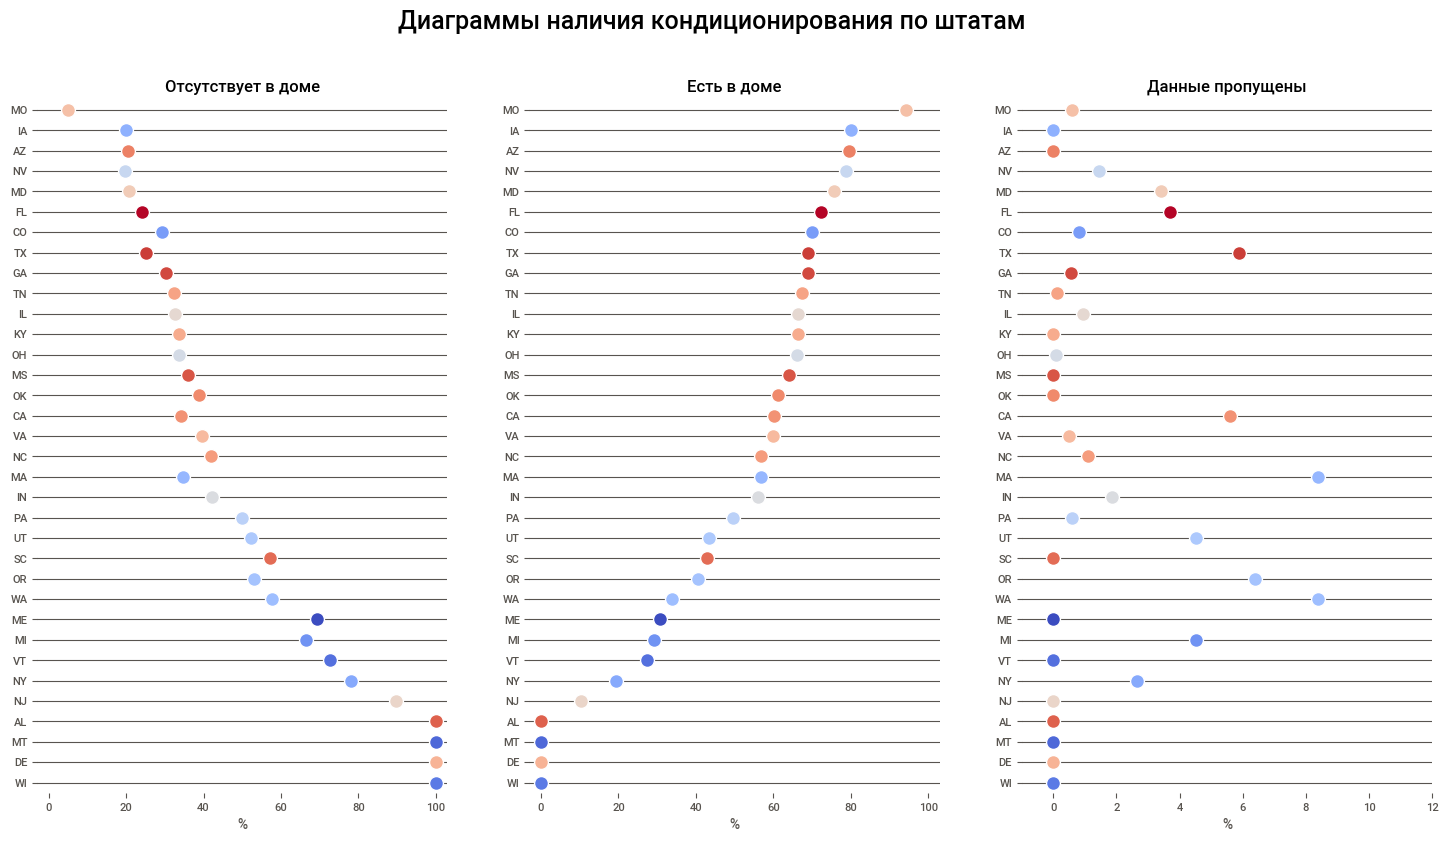

In [ ]:
# Построим диаграмм илюстрирующие наличие/отсутствие кондиционирования
# в зависимости от штата
cross_diag('cooling')

С кондиционированием картина более ясная, на диаграмме **Отсутсвуют в доме** - интервал от 40% до 80% домов представлен холодными штатами.

На диаграмме **Есть в доме** - кондиционирование в жарких штатах находится в диапозоне от 60% до 80%.

На диаграмме **Данные пропущены** - так же, как и на предыдущей диаграме высокие значения от 4% до 9% - представлены большей частью холодными штатами, что значение **None** - можно трактовать как отсутствие кондиционирования. Но поскольку описания значений признаков нет, то оставим предположения и посмотрим на признак - **parking**.

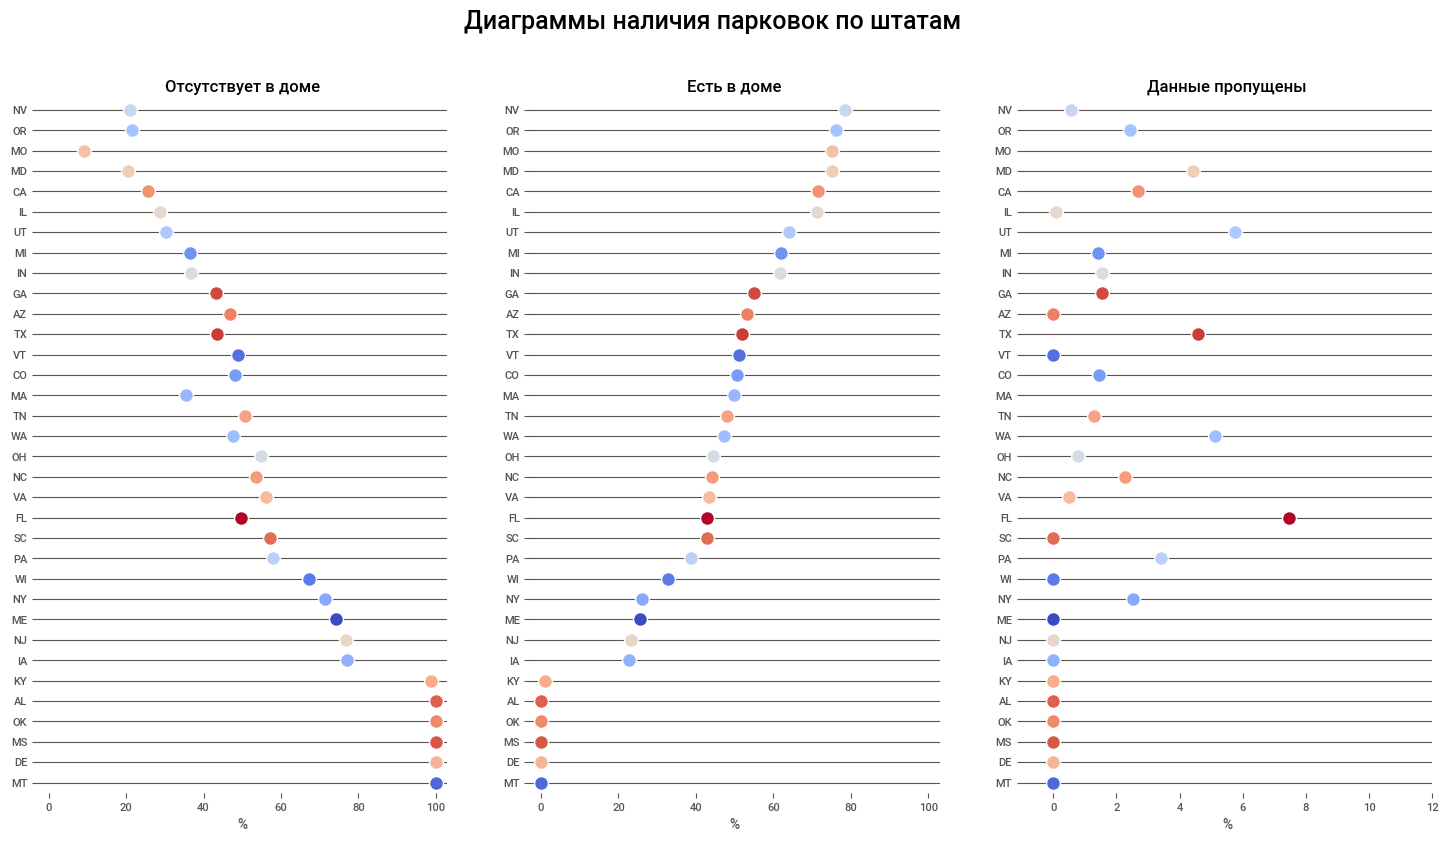

In [ ]:
# Построим диаграммы илюстрирующие наличие/отсутствие парковочных мест
# в зависимости от штата
cross_diag('parking')

По признаку **parking** - не просматривается тренда в зависимости от расположения недвижимости в жарком или холодном штате.

Правильным предположением является группировка по городам, т.к. именно размер города и его застройка (частные дома или многоквартирные здания) определяют ситуацию с парковочными местами.

Данный шаг с построением диаграмм, нужен для решения, как заполниять пустые значения. Но как быть с 4% пропусков в признаке отопления для штата Флориды, если в 72% оно установленно, а в 23% - нет?

Можно предположить, что дополнттельное оборудование увеличтвает стоимость дома. Если дом с пропущенным значением по своей цене ближе к тем 72% где отопление установленно, то логично будет пропущенное значение заменить на положительное значение в диаграмме **Есть в доме** (Yes - в датафрейме). Если же дом по цене ближе к тем, где нет отопления, значит в его признаке поставим отрицательное значение в диаграмме **Отсутствует в доме** (No - в датафрейме).

На следующем шаге, сгрупируем все записи по признаку штата, признаку типа недвижимости (потому, что в односемейном доме может быть парковка, а в квартире нет) и заполняемому признаку (**heating** или **cooling**). Затем будем вычитать стоимость дома с пропущенным значением признака из медиан образованных групп. Наименьшая по модулю разница и определит, какое для конкретного типа жилья в конретном штате записать вместо пропуска.

In [ ]:
# Функция заполнения пропусков  heating и cooling
def fill_heat_cool(state: pd.Series,
                   p_type: pd.Series,
                   target: pd.Series,
                   state_gr: pd.DataFrame):
    """Функция получает на вход три признака: штат,
    тип собственности, цену дома, которую сравнивает
    с медианой сгрупированного датафрейма и возвращает
    вектор значений для заполнения признака
    с пропусками heating или cooling.

    Args:
        state (pd.Series): признак штата
        p_type (pd.Series): признак типа собственности
        terget (pd.Series): признак целевой - цена дома
        state_gr (pd.DataFrame): датафрейм с медианами

    Returns:
        pd.Series: вектор заполненных значений.
    """
    # Вычисляем разницу с медианами по штату, типу собственности
    # и значению наличия/отсутствия удобства, сортируем по возрастанию
    # от самой меньшей разницы по модулю,
    # сохраняем Series в result
    result = abs(state_gr[state][p_type] - target).nsmallest()

    try:
        if result.index[0] == 'missing': # если минимальная разница - с "missing"
            result = result.index[1] # то берем второй элемент Seires
        elif result.index[0] in ['Yes', 'No']: # если на первом месте "Yes" или "No"
            result = result.index[0] # то присваиваем их
        else:
            result = np.NaN # иначе присваиваем NaN для поиска ошибки
    except: # обработка непредвиденной ошибки индексации
        result = np.NaN

    # Возвращаем результат
    return result

In [ ]:
# Сгрупируем данные по штатам, типам и заполняемому приззнаку, вычислим медиану цены
state_heat_gr = df.groupby(['state', 'propertyType', 'heating'])['target'].median()
state_cool_gr = df.groupby(['state', 'propertyType', 'cooling'])['target'].median()

# Сохраним индексы записей, в которых пропущенны значения
ind_heat = df[df['heating'] == 'missing'].index
ind_cool = df[df['cooling'] == 'missing'].index

# Заполняем пустые значения в признаке heating
df.loc[ind_heat, 'heating']\
    = df.loc[ind_heat, ['state', 'propertyType', 'target']]\
    .apply(lambda x: fill_heat_cool(*x, state_heat_gr), axis=1)

# Заполняем пустые значения в признаке cooling
df.loc[ind_cool, 'cooling']\
    = df.loc[ind_cool, ['state', 'propertyType', 'target']]\
    .apply(lambda x: fill_heat_cool(*x, state_cool_gr), axis=1)

# Проверяем , что все пропуски заполнены
print('Количество пропусков в признаке heating:',
    df['heating'].isna().sum() + df[df['heating'] == 'missing'].shape[0])
print('Количество пропусков в признаке cooling:',
    df['cooling'].isna().sum() + df[df['cooling'] == 'missing'].shape[0])

# Очищаем память
del state_heat_gr, state_cool_gr, ind_heat, ind_cool

Количество пропусков в признаке heating: 0
Количество пропусков в признаке cooling: 0


Пропуски в признаках **heating** и **cooling** заполнены на основании группировки по штатам.

Для заполнения пропусков в признаке **prking** воспользуемся группировкой по городам. Илюстрация малоэфективна, так как штатов в датафрейме 34, а городов 1.8 тыс.

In [ ]:
# Функция для заполнения пропусков в признаке parking
def fill_parking(city: pd.Series,
                 p_type: pd.Series,
                 target: pd.Series,
                 city_gr: pd.DataFrame,
                 df: pd.DataFrame):
    """Функция получает на вход три признака: город, тип собственности,
    цену дома, которые сравнивает с медианной сгруппированного датафрейма
    и возвращает вектор значений для заполнения признака с пропусками parking

    Args:
        city (pd.Series): прзнак горада
        p_type (pd.Series): признак типа собственности
        terget (pd.Series): признак целевой - цена дома
        city_gr (pd.DataFrame): датафрейм с медианами

    Returns:
        pd.Series: вектор заполненых значений
    """
    # Вычисляем разницу с медианами по городу, типу собственности,
    # и значению наличию/отсутствию удобства, сортируем по возрастанию
    # от самой меньшей разницы по модулю, сохраняем Series в result
    result = abs(city_gr[city][p_type] - target).nsmallest()

    try:
        if result.index[0] == 'missing': # если минимальная разница - с "missing"
            result = result.index[1] # то берем второй элемент Seires, если он есть
        elif result.index[0] in ['Yes', 'No']: # если на первом месте "Yes" или "No"
            result = result.index[0] # то присваиваем их
        else:
            result = np.NaN # иначе присваиваем NaN для поиска ошибки
    except: # если в result было единственное значение - missing, возникнет ошибка индексации
        result = df[df['city'] == city].parking.mode()[0] # присваиваем моду по городу
        if result == 'missing':
            result = np.NaN # если во всем городе - только missing, заменяем на NaN

    # Возвращаем результат
    return result

In [ ]:
# Сгруппируем данные по городам, типам и заполняемому признаку, вычислим медиану цены
city_park_gr = df.groupby(['city', 'propertyType', 'parking'])['target'].median()

# Сохраним индексы записей, в которых пропущены значения
ind_park = df[df['parking'] == 'missing'].index

# Заполняем пропущенные значения в признаке parking
df.loc[ind_park, 'parking']\
    = df.loc[ind_park, ['city', 'propertyType', 'target']]\
    .apply(lambda x: fill_parking(*x, city_park_gr, df), axis=1)

# Удаляем возможные оставшиеся пропуски
# (порядка 17 городов не имеют информации о парковках)
nan_left = df['parking'].isna().sum()
if nan_left != 0:
    print(f'{nan_left} пропусков не удалось заполнить. Удалим их.')
    df.dropna(axis=0, subset='parking', inplace=True) # удаляем строки с пропусками

# Проверяем, что все пропуски заполнены
print('Количество пропусков в признаке parking:',
    df['parking'].isna().sum() + df[df['parking'] == 'missing'].shape[0])

# Очищаем память
del city_park_gr, ind_park, nan_left

19 пропусков не удалось заполнить. Удалим их.
Количество пропусков в признаке parking: 0


### 5.4. Обработка признака **lotsize**
Этот признак иногда содержит размер участка. Очистим его, оставив только цифры, затем попробуем использовать для заполнения пропущенных значений в признаке - **sqft**.

Сразу заметим, что в признаке **lotsize** часто встречаются площади в актах. Акр равен 43ю5 тыс. квадратных футов. Минимальное значение в признаке - 26 акров, что превышает 1 мил. квадратных футов, таких объектов нет в датафтейме. Значит не предоставляется возможным установить, к чему относится эта площадь - но однозначно не к продаваемой недвижимости. Поэтому все ячейки содержащие **acr** заменим на **No Data** - для простоты последующей обработки.

In [ ]:
# В начале избавимся от запятых и точек, отделяющих тысячные разряды
df['lotsize'] = df['lotsize'].str.replace('.', '')
df['lotsize'] = df['lotsize'].str.replace(',', '')

# Избавимся от всех величин площадей в акрах
ind = df[df['lotsize'].str.contains('acr', case=False) == True].index
df.loc[ind, 'lotsize'] = 'No Data'

# Воспользуемся написанной ранее функцией, чтобы выделить квадратные футы
df['lotsize'] = df['lotsize'].apply(sqft_num).astype(float)

In [ ]:
# Задаем маски непустых и ненулевых значений
m1 = df.sqft.isna() == False
m2 = df.sqft != 0
m3 = df.lotsize.isna() == False
m4 = df.lotsize != 0

# Сохраняем индексы таких записей и выводим размерность
ind = df[m1 & m2 & m3 & m4].index
print('Записей с непустым sqft и lotsize:', len(ind))

Записей с непустым sqft и lotsize: 178556


In [ ]:
#  Создадим признак отношения и заполним его, где возможно
df['sqft_ratio'] = 0
df.loc[ind, 'sqft_ratio'] = df.loc[ind, 'lotsize'] / df.loc[ind, 'sqft']

# Сгруппируем коэффициент отношения по типу недвижимости и вычислим медиану
ratio_gr = df.loc[ind].groupby('propertyType')['sqft_ratio'].median()
display('Отношение lotsize к sqft среди непустых значений:', ratio_gr.round(2))

'Отношение lotsize к sqft среди непустых значений:'

,sqft_ratio
propertyType,
Condo,1.00
Land,2.97
Multifamily,1.74
Single family,3.59
Townhouse,1.02


Ожидаемо, что размер участка земли **Land** - больше площади дома **sqft**, который можно на нём построить, поэтому медианный коэфициент - 2.97.

Почти в половину меньше коэфициент у односемейных домов.Возможно он появился из за дорогих домов, имеющих большую территорию (построенных на таких участках как **Land**)

Наименьший коэфициент у квартир **Condo** и **Townhouse**, которые распологаются в городах на небольших участках земли.

Однако, в число записей которые можно заполнить вычисленным значением, входят большей частью в записи помеченные как выбросы при обработке **target**, это означает, что большая часть заполненных значений будет удалена, а вычисленные значения иногда получаются неочными (по сравнению с делением **target** на **price_sqft** , дальше это увидим), поэтому от идеи использования этого признака придётся отказаться.

In [ ]:
# Удаляем ненуженые признаки
df = df.drop(['lotsize', 'sqft_ratio'], axis=1)

# Очищаем память
del ratio_gr, ind, m1, m2, m3, m4

### 5.5. Обработка признака **price_sqft**
Очистим вначале признак от текста, сохраним только цифры - цену за квадратный фут.

Нули заменим на np.NaN - для удобства дальнейшей работы. Так же удалим (обозначим как np.NaN) такие значения, которые соввпадают со стоимость все недвижимостью.

Затем вычислим площадь недвижимости, разделив ее стоимость **target** на цену за квадратный фут **price_sqft** и сохраним в признак - **true_sqft**. Из этого признака заменим пропуски в признаке - **sqft**.

In [ ]:
# Избавимся от знака $, запятых и точек, отделяюих тысячные разряды
df['price_sqft'] = df['price_sqft'].str.replace('$', '')
df['price_sqft'] = df['price_sqft'].str.replace(',', '')
df['price_sqft'] = df['price_sqft'].str.replace('.', '')

# Наконец воспользуемся написанной ранее функцией, чтобы выделить цену за квадратный фут
df['price_sqft'] = df['price_sqft'].apply(sqft_num).astype(float)

# Обозначим как пропуск цены, равные стоимости участка, а также все нули
ind = list(df[df['price_sqft'] == df['target']].index)
ind.extend(list(df[df['price_sqft'] == 0].index))
df.loc[ind, 'price_sqft'] = np.NaN

In [ ]:
# Задаем маски пустых и нулевых значений
m1 = df.sqft.isna() == True
m2 = df.price_sqft.isna() == True

print('Непустые значения price_sqft:', df[~m2].shape[0])
print('Пустые значения sqft:', df[m1].shape[0])
print('Пересечение непустых price_sqft и пустых sqft:', df[m1&~m2].shape[0])

Непустые значения price_sqft: 307207
Пустые значения sqft: 52443
Пересечение непустых price_sqft и пустых sqft: 1246


In [ ]:
# Сохраняем индексы записей с непустыми ячейками price_sqft
ind = df[~m2].index
# Вычисляем площадь дома, а также разницу с признаком sqft
df.loc[ind, 'true_sqft'] = (df.loc[ind, 'target'] / df.loc[ind, 'price_sqft']).astype(int)
df.loc[ind, 'sqft_dif'] = abs(df.loc[ind, 'sqft'] - df.loc[ind, 'true_sqft'])

# Сохраняем индексы пересечения
ind = df[m1&~m2].index
# Заполняем пропуски в sqft с помощью вычисленных значений
df.loc[ind, 'sqft'] = df.loc[ind, 'true_sqft']

Десериализованный признак **price_sqft** - не помог в заполнении пропусков в признаке - **sqft** (всего 1246 записей из 52443), но это было не известно.

### 5.6. Фльтрация записей по признакам **sqft** и **price_sqft**.
Пора избавится от выбросов и пустых значений в ключевом признаке - **sqft**.

С этой целью проверим на выбросы с помощью метода z-отклонений два признака:
* **sqft**
* **price_sqft**

Определённые выбросы пометим флагами в соответствующих новых признаках.

Таким образа совместно с созданным ранее столбцом выбросов **outliers** для целевого признака **target** отсеем такие объявления, которые выбиваются из общей массы по одной из этих независимых характеристик (независимых потому, что в датафрейме значения сохранённые в этих признаках могут быть не связанны).

Также посмотрим, ка распределена ошибка расчётной площади с имевшейся в датафрейме (новый признак **sqft_dif**).

In [ ]:
# Функция вывода гистограммы распределения признака
def draw_hist(df: pd.DataFrame,
              feat: str,
              left: int,
              right: int,
              log_scale: bool = True,
              bins: int = 50):
    """Функция выводит на дисплей гистограмму распределения признака
    (при необходимости в логарифмическом маштабе), отрисовывает
    нижнюю и верхрхнюю границы отклонений.

    Args:
        df (pd.DataFrame): исходный датафрейм
        feat (str): иллюстрируемый признак
        left (int): количество сигм для нижней границы
        rigth (int): количество сигм для верхней границы
        log_scale (bool: optional): преход к лог. масштабу, по умолчанию = True
        bins (int: optional): количество столбцов, по умолчанию = 50

    Returns:
        None: Функция ничего не возвращает
    """
    # Если требуется переход к логарифмическому масштабу
    if log_scale:
        if df[feat].min() > 0: # если значения признака больше нуля
            log_target = np.log(df[feat])
        else:
            log_target = np.log(df[feat]+1) # иначе добавляем единицу
    else:
        log_target = df[feat]

    # Вычисляем границы выбросов
    upper_bound = log_target.mean() + right * log_target.std()
    lower_bound = log_target.mean() - left * log_target.std()

    # Строим гистрограмму для каждого типа недвижимости
    histplot = sns.histplot(
        data = log_target,
        bins = bins
    );
    histplot.axvline(log_target.mean(), color='k', lw=1)
    histplot.axvline(upper_bound, color='k', ls='--', lw=1)
    histplot.axvline(lower_bound, color='k', ls='--', lw=1)
    histplot.set_title(f'Гистограмма для {feat}', fontsize=10);
    histplot.set_xlabel('');
    histplot.set_ylabel('');

    return

Число выбросов по методу z-отклонений для price_sqft: 4178
Результирующее число записей для price_sqft: 303029


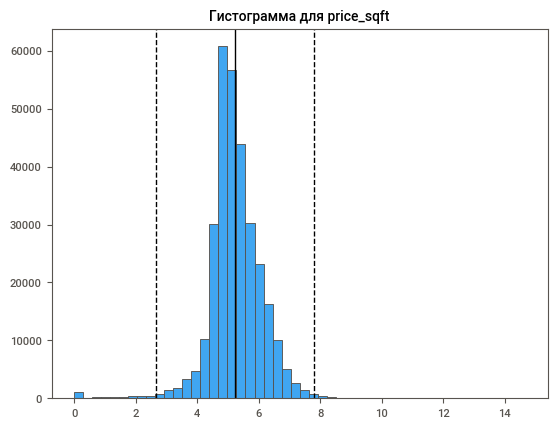

In [ ]:
# Задаем границы отклонений в сигмах и признак
left = 3
right = 3
feat = 'price_sqft'
# Добавляем одноименный признак с флагом отклонений
df['outliers_price_sqft'] = 0

# Определяем выборосы с помощью написанной функции
outliers, cleaned = outliers_z_score(df=df, feature=feat,
                                     log_scale=True,
                                     left=left, right=right)

# Выводим результат работы на дисплей и устанавливаем флаги в признаке
print(f'Число выбросов по методу z-отклонений для {feat}: {outliers.shape[0]}')
print(f'Результирующее число записей для {feat}: {cleaned.shape[0]}')
df.loc[outliers.index, 'outliers_price_sqft'] = 1

# Отобразим гистограмму
draw_hist(df, feat, left, right)

Число выбросов по методу z-отклонений для sqft: 2244
Результирующее число записей для sqft: 317018


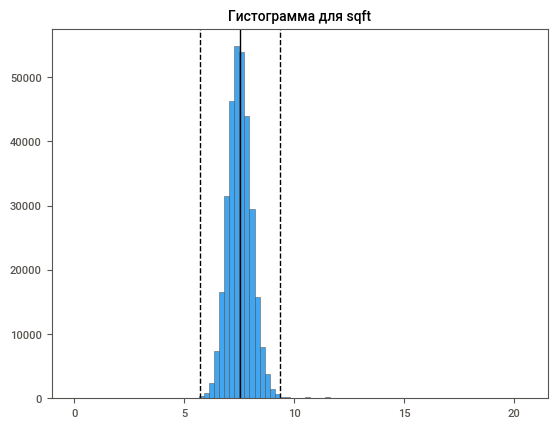

In [ ]:
# Задаем границы отклонений в сигмах и признак
left = 3
right = 3
feat = 'sqft'
# Добавляем одноименный признак с флагом отклонений
df['outliers_sqft'] = 0

# Определяем выборосы с помощью написанной функции
outliers, cleaned = outliers_z_score(df=df, feature=feat,
                                     log_scale=True,
                                     left=left, right=right)

# Выводим результат работы на дисплей и устанавливаем флаги в признаке
print(f'Число выбросов по методу z-отклонений для {feat}: {outliers.shape[0]}')
print(f'Результирующее число записей для {feat}: {cleaned.shape[0]}')
df.loc[outliers.index, 'outliers_sqft'] = 1

# Отобразим гистограмму
draw_hist(df, feat, left, right, bins=90)

In [ ]:
# Объединяем все флаги выбросов по трем признакам в один
df['total_outliers'] = df['outliers'] + df['outliers_sqft'] + df ['outliers_price_sqft']
print('Всего к выбросам отнесено записей:', df[df['total_outliers'] > 0].shape[0])

Всего к выбросам отнесено записей: 22000


Число выбросов по методу z-отклонений для sqft_dif: 3086
Результирующее число записей для sqft_dif: 302875


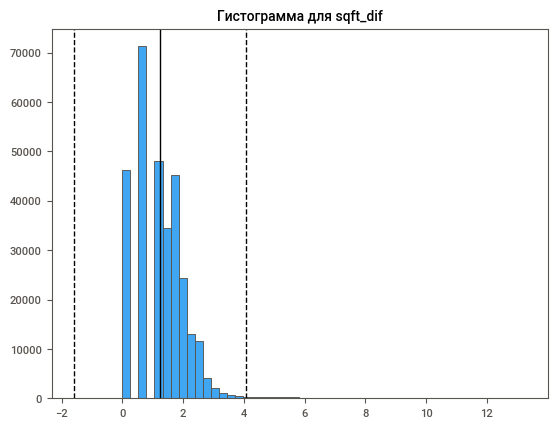

In [ ]:
# Задаем границы отклонений в сигмах и признак
left = 3
right = 3
feat = 'sqft_dif'

# Определяем выборосы с помощью написанной функции
outliers, cleaned = outliers_z_score(df=df, feature=feat,
                                     log_scale=True,
                                     left=left, right=right)

# Выводим результат работы на экран (признак с флагами не создавали)
print(f'Число выбросов по методу z-отклонений для {feat}: {outliers.shape[0]}')
print(f'Результирующее число записей для {feat}: {cleaned.shape[0]}')

# Отобразим гистограмму
draw_hist(df, feat, left, right, log_scale=True)

Сравним разницу между вычисленным значением площади и тем, что было изначальна в датафрейме - **sqft_dif**, которая распределилась по типам недвижимости.

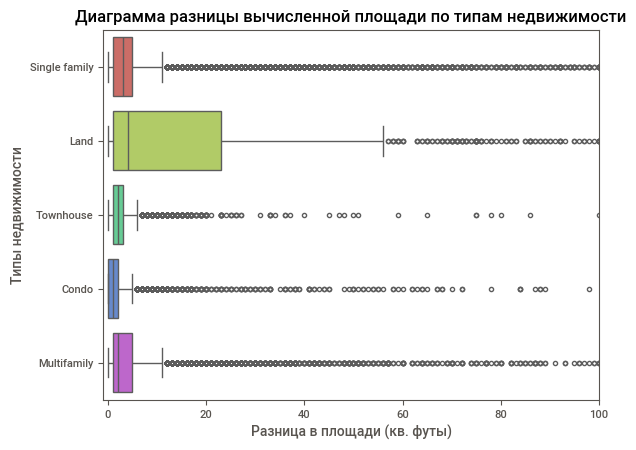

In [ ]:
# Построим коробчатую диаграмму
boxplot = sns.boxplot(
    data = df,
    x = 'sqft_dif',
    y = 'propertyType',
    palette = 'hls'
);
boxplot.set(xlim=(-1, 100)); # ограничим диапазон из-за выбросов
boxplot.set_title('Диаграмма разницы вычисленной площади по типам недвижимости');
boxplot.set_xlabel('Разница в площади (кв. футы)');
boxplot.set_ylabel('Типы недвижимости');

Самое большое значение 1.5 межквартильных размаха приходится на тип **Land** - в районе 60 кв. футов. Примем за выбросы все значения разницы выше этого. Прверим какое количество записей по одну и другую границу и сравним какой процент из них входит в определённые нами выбросы по другим признакам.

In [ ]:
print('Записей с разницей выше 60 кв. футов:', df[df['sqft_dif'] > 60].shape[0])
print('Записей с разницей меньше или равно 60 кв. футов:', df[df['sqft_dif'] <= 60].shape[0])

dif_in_out = round(df[(df['sqft_dif'] > 60) & (df['total_outliers'] > 0)].shape[0] / df[df['total_outliers'] > 0].shape[0] * 100)

print(f'Доля записей с разницей выше 60 кв. футов в выбросах: {dif_in_out}%')

Записей с разницей выше 60 кв. футов: 2998
Записей с разницей меньше или равно 60 кв. футов: 302963
Доля записей с разницей выше 60 кв. футов в выбросах: 11%


В отобранные выбросы по признака **sqft** и **price_sqft** попали 11% записей, где разница между расчетной и исходной площадью превышает 60 ув. футов. Таким образом, выбросы в **sqft_dif** - можно считать погрешностью в объёме всех выбросов. Поэтому специально удалять эти записи не будем, а произведём очистку датафрейма на основании их вхождения в список выбросов по трём признакам:
* исходная площадь (пропуски которые частично заполнили),
* цена за кв. фут,
* итоговая стоимость.

Так же в список на удаление добавим записи, у которых площадь равна или превышает стоимость - это не возможно, иначе означает, что квадратный фут стоит один доллар или меньше. Таких записей в датафрейме не много блее 800.

In [ ]:
# Формируем список на удаление: выбросы и неадекватная площадь
ind = set(df[df['total_outliers'] > 0].index)
ind.update(df[df['sqft'] >= df['target']].index)
df = df.drop(list(ind), axis=0)

# Удалим ненужные признаки
df = df.drop(['outliers','outliers_sqft', 'outliers_price_sqft',
              'total_outliers', 'true_sqft', 'sqft_dif'], axis=1)

# Проверим, сколько пропусков остается
print(f'Все еще остается {df.sqft.isna().sum()} пропуска в признаке sqft')
print(f'Это составляет {round(df.sqft.isna().sum()/df.shape[0]*100,2)}% датафрейма')

# Удаляем записи с оставшимися пропусками
df.dropna(axis=0, subset='sqft', inplace=True)
print('Эти записи удалены')

Все еще остается 44623 пропуска в признаке sqft
Это составляет 12.81% датафрейма
Эти записи удалены


Когда удалили выбросы, переходим к построению диаграммы зависимости стоимости недвижимости от её площади.

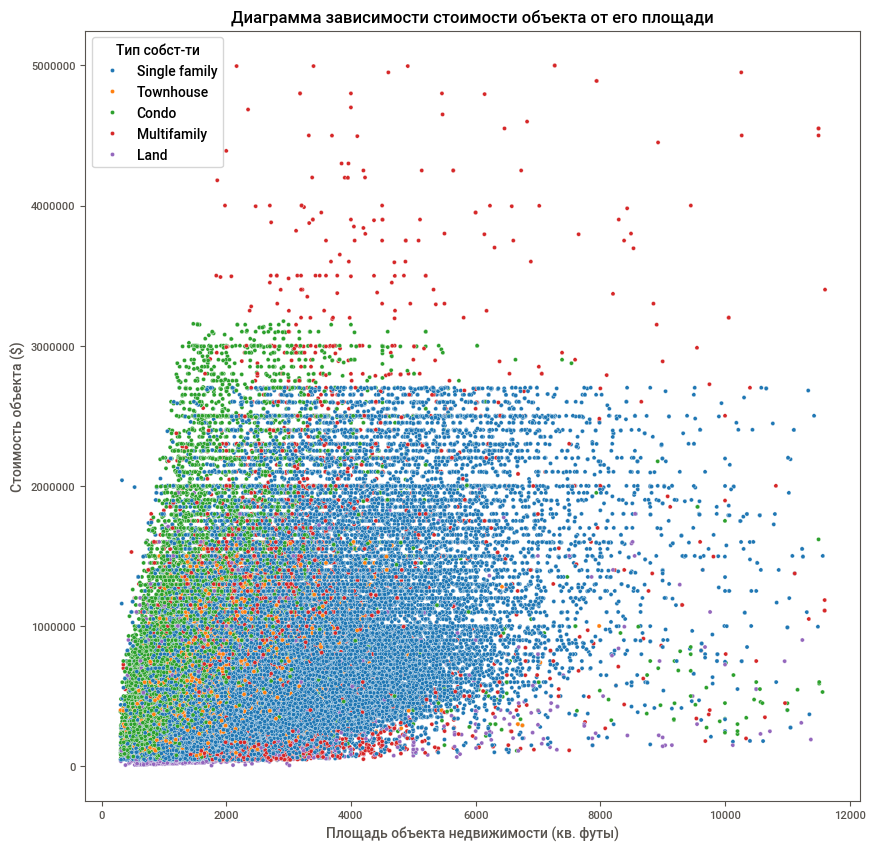

In [ ]:
# Построим диаграмму зависимости стоимости от площади
fig = plt.figure(figsize=(10, 10))
scatterplot = sns.scatterplot(
    data = df,
    x = 'sqft',
    y = 'target',
    hue = 'propertyType',
    palette = 'tab10'
);
scatterplot.set_title('Диаграмма зависимости стоимости объекта от его площади');
scatterplot.set_xlabel('Площадь объекта недвижимости (кв. футы)');
scatterplot.set_ylabel('Стоимость объекта ($)');
scatterplot.legend(title = 'Тип собст-ти');

После удаление выбросов, диаграмма не стала более информативной. Можно применить алгоритмы понижение размерности, но применим для обработки данных другой способ, и всё же попробуем уловить закономерности на этой диаграмме.

Ожидаемо, с увиличением площади растёт и цена, но есть большие по площади объекты, которые остаются дешовыми. Возможно это не популярые участки или оставшиеся выбросы, будем считать это особенность объектов.

Чётко просматриваются горизонтальные линии среди всех типов недвижимости. Заметное уменьшение объектов после 270-300 тыс.$ - в основном они принадлежат к типу многосемейных домов.

В распределении не просматривается строгая линейная зависимость, поэтому применении модели линейной регрессии будет не эффективвно для получения хороших результатов.

### 5.7. Обработка признака **school**.
В этих признаке содержится специализированный словарь данных о близлежащих школах:
*  рейтинг школы по десятибольной шкале,
* расстояние до школы в милях,
* классы школы (начальныеБ среднии, и др.),
* название школы.

Одним из вариантов это выделение типов школ по классам (подгоовительные, начальные, средние) и несколько признаков, а затем для каждого объекта недвижимости  заполнение этих признаков с помощью рейтинга и расстояния до школы, но поступим проще.

Владельцы недвижимости по возможности выбирают по близости школу с высоким рейтингом, а лутше несколько, проигнорируем возрастные классы и сосредоточимся на рейтинге и расстоянии до школы.

Чем выше рейтинг и чем ближе школа, тем предпочтительнее выбор. Поэтому выведем совокупный рейтинг в виде среднего арефметического рейтингов, делённого на расстояние. Таким образом, высокий рейтинг школы компенсирует большое расстояние до неё и школа с рейтингом ниже, но по близости также покажет высокий совокупный рейтинг.

В итоге совокупный рейтинг будет отражать, какое количество школ расположенно  по близости от объекта недвижимости. Поэтому, чтобы не терять эту информацию, выделим ещё один признак - количество школ. Это будет - длинна списка расстояний.

Напишем несколько функций для десериализации признака **schools**, для преобразования текстовых списков к числовым и для вычисления среднего арифметического нашего рейтинга.

In [ ]:
# Фнкция для десериализации признака school
def deserialize_school(s: str) -> pd.Series:
    """Функция возвращает значение словаря, который находитя
    в серелиазованном виде в строке s.

    Args:
        s (str): строка с сереализованным словарём

    Returns:
        pd.Series: список из значений словаря в виде объекта Series
    """
    # Десериализуем строку в словарь и сразу сохроним его единственноу значение
    result = eval(s)[0]

    # В единственном значении словаря хранится словарь из 3 элементов,
    # каждый из которых представлен списками
    # (за исключением второго - data, у которого два списка обёрнуты в словарь)
    # Вернём рейтинги и расстояние до школ.
    rating = result['rating']
    distance = result['data']['Distance']

    # Возвращаем списки в виде объекта Series
    return pd.Series([rating, distance])

In [ ]:
# Функция преобразования списка строк в список числовых значений
def clear_list(str_list) -> list:
    """Функция преобразует список строковых значений, в список числовых.
    Приэтом функция выделяет первое число в рейтинге (4/10 -> 4)
    и расстояние обозначенное с помощью 'm'

    Args:
        str_list (list): Список строковых значений
    Returns:
        list: Список значений преобразованных в числовой вид
    """
    # Скомпилируем паттерны для поиска в признаках rating и dist
    p_rat = re.compile('(\d+)/?')
    p_dis = re.compile('(\d+\.?\d*)\s*mi')

    if len(str_list) == 0: # если в ячейке пустой список
        result = np.NaN
    elif 'NR' in str_list: # если в списке содержится 'NR'
        result = [int(r) if r.isdigit() else np.NaN for r in str_list]
    elif len(list(filter(p_dis.search, str_list))) > 0: # если в списке содержится расстояние
        result = [float(p_dis.search(r).group(1)) if p_dis.search(r)\
                  else np.NaN for r in str_list]
    elif len(list(filter(p_rat.match, str_list))) > 0: # если в списке рейтинг со слэшами
        result = [int(p_rat.match(r).group(1)) if p_rat.match(r)\
                  else np.NaN for r in str_list]
    else:
        result = np.NaN # в крайнем случае вернем np.NaN

    # Возвращаем преобразованный список
    return result

In [ ]:
# Функция вычисления среднего арифметического списка
def mean_lists(rating: list, dist: list) -> float:
    """Функция вычисляет среднее арифметическое двух списков, состоящих
    из числовых значений. Вначале она делит рейтинги на расстояния,
    затем получившийся список частных преобразует в объект pd.Series
    и вычисляет среднее арифметическое.
    Перед делением функция заменяет нуливые расстояния на 0.1 (минимальное
    встречающее в датафрейме), чтобы избежать бесконечности (np.inf) в ответе.

    Args:
        rating (list): Список рейтингов школ
        dist (list): Списол расстояний до школ

    Returns:
        float: Средне-арифметический коэфициент
    """
    if type(rating) == list and type(dist) == list:
        # Нулевые расстояния заменим на минимальные, чтобы избежать inf
        dist = list(map(lambda x: 0.1 if x==0 else x, dist))
        mult = list(np.divide(rating, dist)) # делим рейтинг на расстояние
        result = pd.Series(mult).mean() # вычисляем среднее арифмитическое
    else:
        result = np.NaN # если на вход поданы не списки, вернем np.NaN

    # Возвращаем результат работы функции
    return result

In [ ]:
# Десериализуем признак schools
df[['sch_rating', 'sch_dist']] = df['schools'].apply(deserialize_school)

# Генерируем два новых признака с рейтингами и расстояниями до школ
df['sch_rating'] = df['sch_rating'].apply(clear_list)
df['sch_dist'] = df['sch_dist'].apply(clear_list)

# Вычисляем совокупный рейтинг
df['sch_rat_dist'] = df[['sch_rating', 'sch_dist']]\
                     .apply(lambda x: mean_lists(*x), axis=1).round()

# Сохраняем в отдельный признак количество школ
try:
    df['sch_number'] = df['sch_dist']\
                   .apply(lambda x: len(x) if x is not np.NaN else np.NaN)
except: # после чтения из файла список хранится как строка, что вызывает ошибку
    df['sch_number'] = df['sch_dist']\
                      .apply(lambda x: len(eval(x)) if x is not np.NaN else np.NaN)

In [ ]:
# Посмотрим на описание созданного нами признака совокупного рейтинга
df['sch_rat_dist'].describe()

,sch_rat_dist
count,300681.000000
mean,6.025688
std,6.560195
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,333.000000


In [ ]:
# Также посмотрим на количество школ, которые распологаются по близости домов
df['sch_number'].describe()

,sch_number
count,301388.000000
mean,4.180445
std,4.430283
min,1.000000
25%,3.000000
50%,3.000000
75%,4.000000
max,65.000000


В итоге, медианный рейтинг равен примерно 4 единицам, а топ-10 представлен всеми значениями от1 до 10 включительно, ноль не входит, это наталкивает на то, что родителям приходится еждить до школ.

Встречаются аномальные значения до 333. Есть объекты недвижимости где школа удалена на сотни и тысячи миль, возможно школа в другом городе или штате, на это указали родители.  

Что касаемо количества школ, то родители могут выбирать из 3-4 школ, но есть случаи когда в районе находится 65 школ, вопрос расстояния до них.

На основании этого, не будем удалять записи по причине аномального большого рейтинга школы или их количества. Вот с пустыми значениями (их около 500), поступим как делали с другими признаками - заполним пропуски медианной, характерной для типа недвижимости, логично что школы, для квартир в городах, должны быть ближе чем для частных домов в не больших городах.  


In [ ]:
# Вычислим медиану совокупного рейтинга для каждого из типов жилья
proper_sch_rat_med = df.groupby('propertyType')['sch_rat_dist'].median()
# Вычислим медиану количества школ для каждого из типов жилья
proper_sch_num_med = df.groupby('propertyType')['sch_number'].median()

# Запускаем цикл по всем типам недвижимости
for p in proper_sch_rat_med.index:
    mask1 = df['propertyType'] == p # маска по типу недвижимости
    mask2 = df['sch_rat_dist'].isna() == True # маска по пропускам в sch_rat_dist
    mask3 = df['sch_number'].isna() == True # маска по пропускам в sch_number
    ind = df[mask1 & mask2]['sch_rat_dist'].index # сохраняем индекс
    df.loc[ind, 'sch_rat_dist'] = proper_sch_rat_med[p] # присваиваем медиану рейтингу

    ind = df[mask1 & mask3]['sch_number'].index # сохраняем индекс
    df.loc[ind, 'sch_number'] = proper_sch_num_med[p] # присваиваем медиану кол-ву школ

# Проверяем результаты заполнения
print('Осталось пропущенных значений в признаке sch_rat_dist:',
      df['sch_rat_dist'].isna().sum())
print('Осталось пропущенных значений в признаке sch_number:',
      df['sch_number'].isna().sum())

# Удаляем ненужные больше признаки
df = df.drop(['schools', 'sch_rating', 'sch_dist'], axis=1)

Осталось пропущенных значений в признаке sch_rat_dist: 0
Осталось пропущенных значений в признаке sch_number: 0


### 5.8. Генерация столица штата - **state_cap**
Ранее выдвинули гипотизу, что стоимость недвижимости в столицах штатов, может отличаться от разных городов. Для проверки создадим новый признак. Для этого скачаем список всех штатов с их аббревиатурами и столицпми и добавим к датафрейму. Выставим флаг для определения расположен ли объект недвижимости в столийе штата или нет и просмотрим на результаты.

In [ ]:
# Определяем адрес страницы с сокращениями штатов и выполняем GET-запрос
url = 'https://bigdave44.com/features/the-mine/us-states-abbreviations-capitals-nicknames/'
# url = 'https://bigdave44.com/features/the-mine/us-states-abbreviations-capitals-nicknames/'
response = requests.get(url)
if response.status_code != 200:
    print(f'Ошибка парсинга сайта {url}: {response.status_code}')
# Создаём объект BeautifulSoup, указывая html-парсер
page = BeautifulSoup(response.text, 'html.parser')
# Ищем на странице все строки с названием, аббревиатурой и столицей штата
raw_data = page.find_all('td')
# Из строк формируем список в формате: штат, аббревиатура, столица
states_cap = [r_d.text for r_d in raw_data][4:203]

# Фомируем датафрем из названий аббревиатур штатов и столиц
cap_df = pd.DataFrame(list(zip(states_cap[1::4],
                               states_cap[2::4])),
                      columns = ['state', 'capital'])
# Переводим все столицы в нижний регистр (как в датафрейме)
cap_df['capital'] = cap_df['capital'].str.lower()

# Добавляем получившийся датафрейм к основному
df = pd.merge(
    left = df,
    right = cap_df,
    on = 'state',
    how = 'left'
)

In [ ]:
# Генерируем признак нахождения в столице штата
df['in_st_capital'] = df[['city', 'capital']]\
                      .apply(lambda x: 1 if x.city == x.capital else 0, axis=1)

# Проверим, сколько объектов расположены в столицах штатов
obj = df['in_st_capital'].sum()
shr = round(obj / df.shape[0] * 100)
print(f'В столицах расположено {obj} объектов, что составляет {shr}% от датафрейма.')

# Удаляем ненужный столбец и чистим память
df = df.drop('capital', axis=1)
del url, response, page, raw_data, states_cap, cap_df, obj, shr

В столицах расположено 23844 объектов, что составляет 8% от датафрейма.


Доля объектов в столицах штатов невелика и больше похожа на погрешность. Посмотрим как этот признак влияет на стоимость недвижимости.

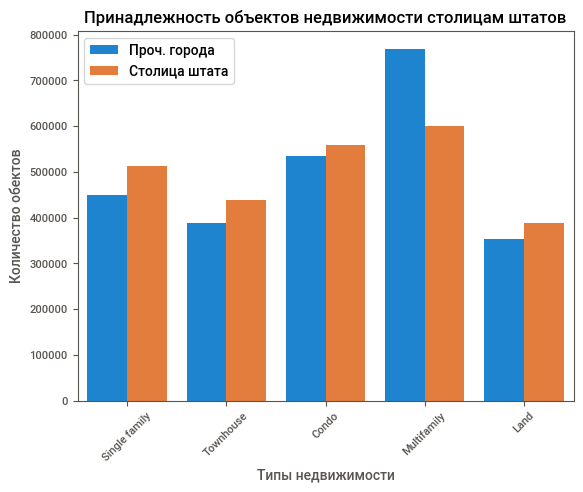

In [ ]:
# Посмотрим на гипотезу
barplot = sns.barplot(
    data = df,
    x = 'propertyType',
    y = 'target',
    hue = 'in_st_capital',
    errorbar = None
);
barplot.set_title('Принадлежность объектов недвижимости столицам штатов');
barplot.set_xlabel('Типы недвижимости');
barplot.set_ylabel('Количество обектов');
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45);
barplot.legend(labels=['Проч. города', 'Столица штата']);

На диаграмме просматривается, что почти все объекты недвижимости, кроме многосемейных домов, чаще распологаются в столицах штатов, но превышение незначительное.

В первых итерациях работы над проектом, когда не удаляли большого количества выбросовпри обработке признака **target** - в пункте 3.11. картина была диаметрально противоположной - почти все объекты (за исключением **Land**) находились вне столиц штатов (та диаграмма не сохранилась).

Рассмотривая эту диаграммы видим, что тренда по жизни в столицах штатов или за их пределами выявить не удалось.

В итоге, данный признак не будет существенно влиять на качество модели.

### 5.9. Кодирование признаков.
На этом завершим с обработкой и исследовании данных, можно було бы построить дополнительные диаграммы, но не факт, что такие гипотизы повлияют на результат.

Преходим к подготовке данных и подаче на вход моделям обучения. Начнём с кодирования признаков.

Первым делом удалим не нужные больше признаки. Затем категориальные преобразуем в числовые:
* где в ручную заменим бинарные значения на 1 и 0,
* в остальных случаях воспользуемся кодировщиками.

In [ ]:
# Удаляем ненужные признаки
df = df.drop(['street', 'homeFacts', 'city', 'price_sqft'], axis=1)

# Кодируем признаки с бинарными значениями
df['heating'] = df['heating'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)
df['cooling'] = df['cooling'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)
df['parking'] = df['parking'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)

# Удаляем записи с оставшимися пропусками
df.dropna(inplace = True)

# Отобразим кол-во уникальных значений для выбора метода кодировки
display('Количество уникальных значений в категориальных признаках:',
        df.select_dtypes(include='object').nunique())

'Количество уникальных значений в категориальных признаках:'

,0
status,5
propertyType,5
state,33
stories,4


In [ ]:
# Создаем список признаков для одиночного кодирования
oh_cols = ['status', 'propertyType', 'stories']
# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.OneHotEncoder(cols=oh_cols, use_cat_names=True)
encoded_data = encoder.fit_transform(df[oh_cols])
# Присоединяем к датафрейму закодированные признаки
df = pd.concat([df, encoded_data], axis=1)

# Создаем объект одиночного кодирования и выполняем кодирование
encoder = ce.BinaryEncoder(cols=['state'])
encoded_data = encoder.fit_transform(df[['state']])
# Присоединяем к датафрейму закодированные признаки
df = pd.concat([df, encoded_data], axis=1)

# Удалим исходные признаки и выведем размер датафрейма
df = df.drop(['status', 'propertyType', 'stories', 'state'], axis=1)
print('Размер получившегося датафрейма:', df.shape)

Размер получившегося датафрейма: (303835, 31)


### 5.10. Оценка мультиколлинеарности признаков.
Проверим нет ли сильной связи между признаками в датафрейме по методу Пирсона.

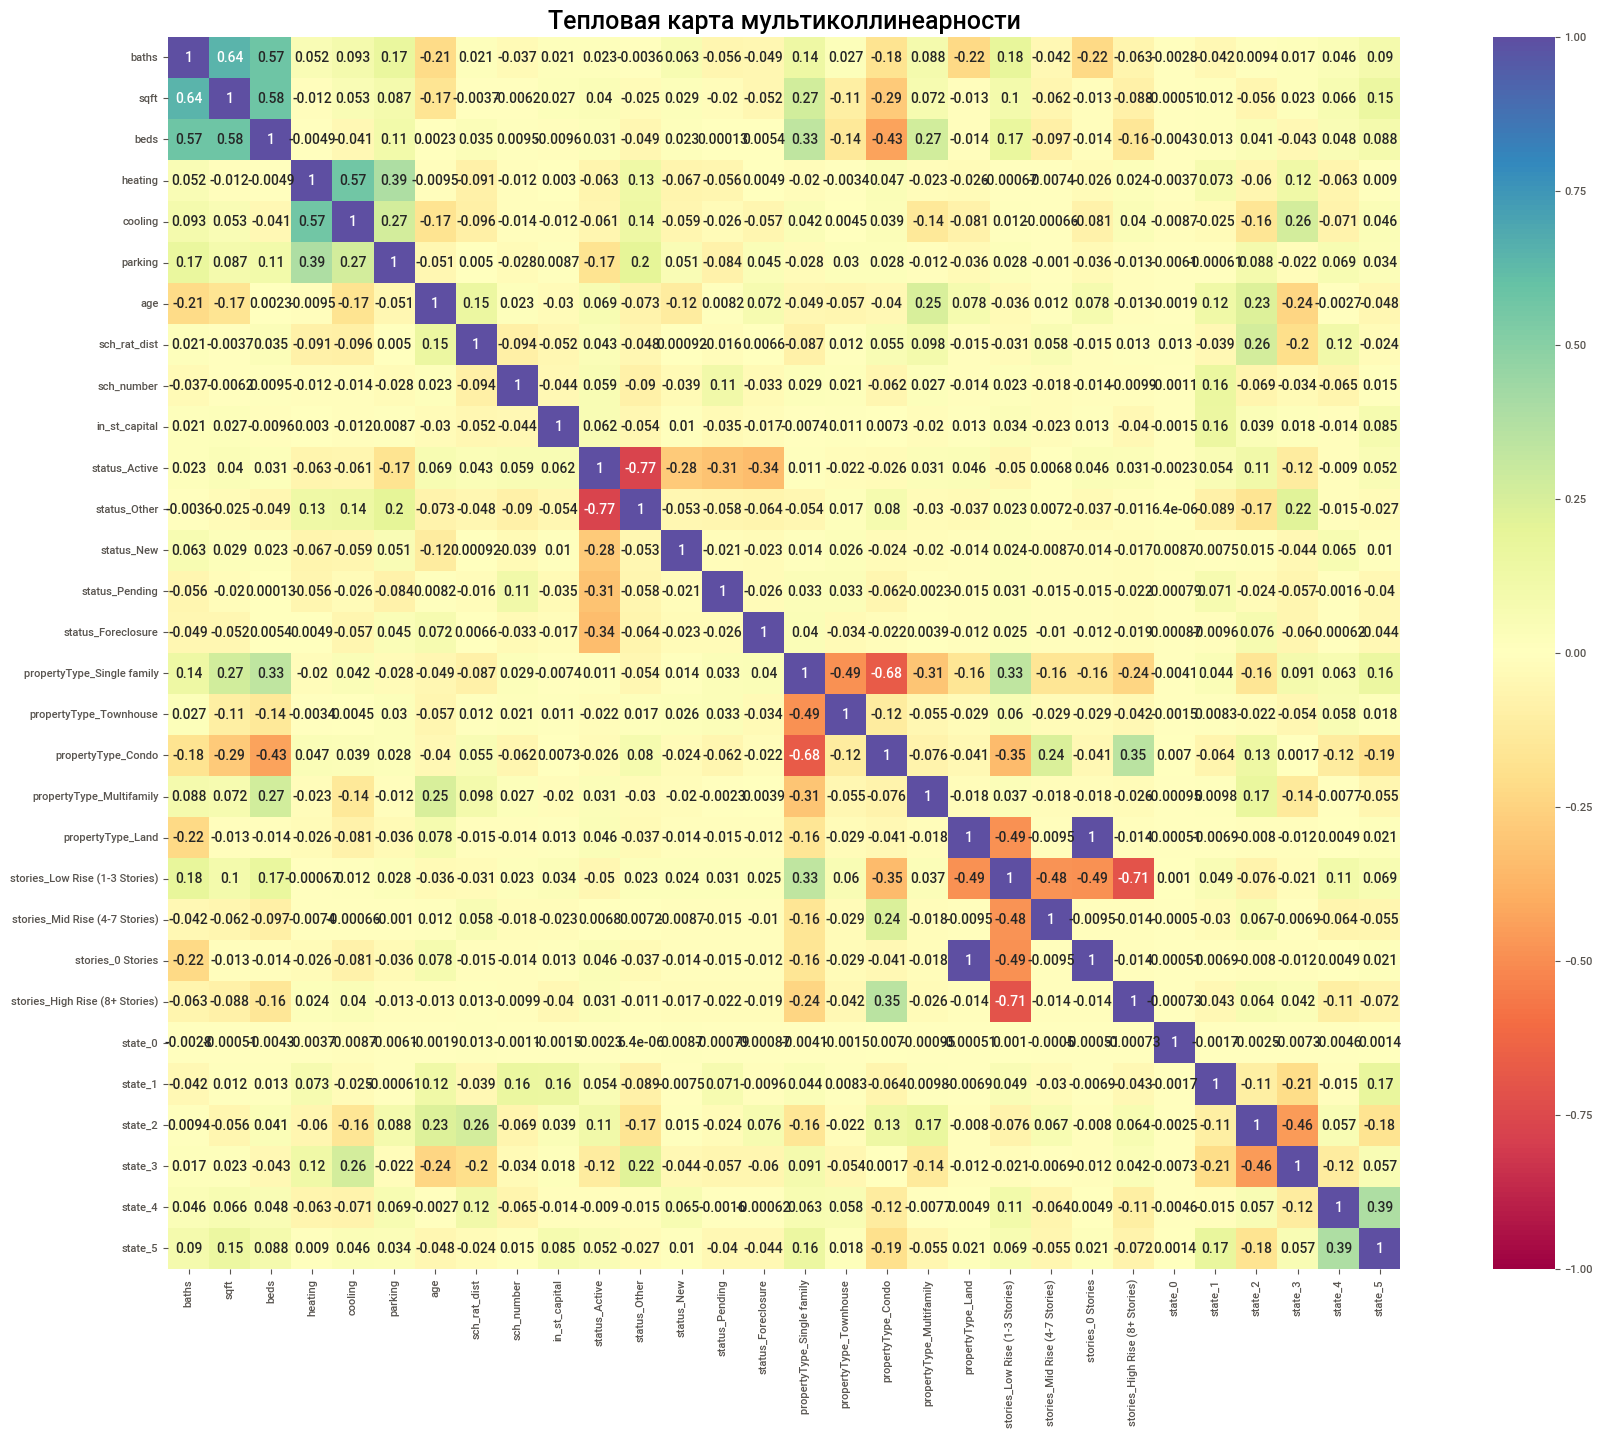

In [ ]:
# Построим тепловую карту мультиколлинеарности
fig = plt.figure(figsize=(20, 14))
heatmap = sns.heatmap(
    data = df.drop('target', axis=1).corr(method='pearson'),
    annot = True,
    fmt = '.2g',
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap= 'Spectral',
    square = True
);
heatmap.set_title('Тепловая карта мультиколлинеарности', fontsize=18);

Просматривается абсолютная связь признаков - **propertyType_Land** и **stories_0 Storiws**. Почему так - на этапе очистки присвоили данному типу недвижимости категорию нуливых этажей.

Так как недвижимость с нуливой этажностью  несуществует (это только участки земли) целесообразно избавится от признака - **stories_0 Stories**. Все остальные оставим.

Ожидаемая связь между площадью строения и количеством ванных комнат и спален. Никаких манипуляций с этими признаками проводить не будем.

Перед удалением **stiries_0 Stories** - проведём несколько тестов на оценку значимости признаков.

### 5.11. Оценка значимости и отбор признаков.
Первоначально с помощью **SelectKBest** - отберём 20 лутших признаков из 29. Затем проведём **хи-тест** и тест **ANOVA** для категориальных и непрерывных признаков.

Это позволит принять взвешенное решение, какие признаки удалять, а какие оставить в итоговых выборках.

По итогу этого шага разделим датафрейм на тренировочные и тестовые выборки и векторы ответов для подачи на вход модели.

Отбор лутших признаков с помощью - **SelectKBest**

In [ ]:
# Создаем объект класса SelectKBest
kbest = SelectKBest(score_func=f_regression, k=20)

# Подгоняем его под данные и получаем список лучших 20 признаков
kbest.fit(df.drop('target', axis=1), df['target'])
kbest_columns = kbest.get_feature_names_out()

# Посмотрим, какие признаки не вошли в число лучших
display('Не вошли в число лучших признаков:',
        set(df.drop('target', axis=1).columns).difference(set(kbest_columns)))

'Не вошли в число лучших признаков:'

{'age',
 'cooling',
 'in_st_capital',
 'propertyType_Land',
 'state_0',
 'status_New',
 'status_Other',
 'status_Pending',
 'stories_0 Stories',
 'stories_Mid Rise (4-7 Stories)'}

Метод **SelectKBest** - подтвердил, что нужно избавиться от - **propertyType_Land** и **stories_0 Stories**.

Так же в число лутших не вошел сгенерированный  - **n_st_capital**.

Проведём дополнительные тесты перед принятием решений.

In [ ]:
# Разделим все признаки на два списка: категориальные и непрерывные
cat_cols = ['baths', 'beds', 'heating','cooling', 'parking',
            'in_st_capital', 'status_Active', 'status_Other',
            'status_New', 'status_Pending', 'status_Foreclosure',
            'propertyType_Single family', 'propertyType_Townhouse',
            'propertyType_Condo', 'propertyType_Multifamily', 'propertyType_Land',
            'stories_Low Rise (1-3 Stories)', 'stories_Mid Rise (4-7 Stories)',
            'stories_0 Stories', 'stories_High Rise (8+ Stories)', 'state_0',
            'state_1', 'state_2', 'state_3', 'state_4', 'state_5']

num_cols = ['sqft', 'age', 'sch_rat_dist', 'sch_number']

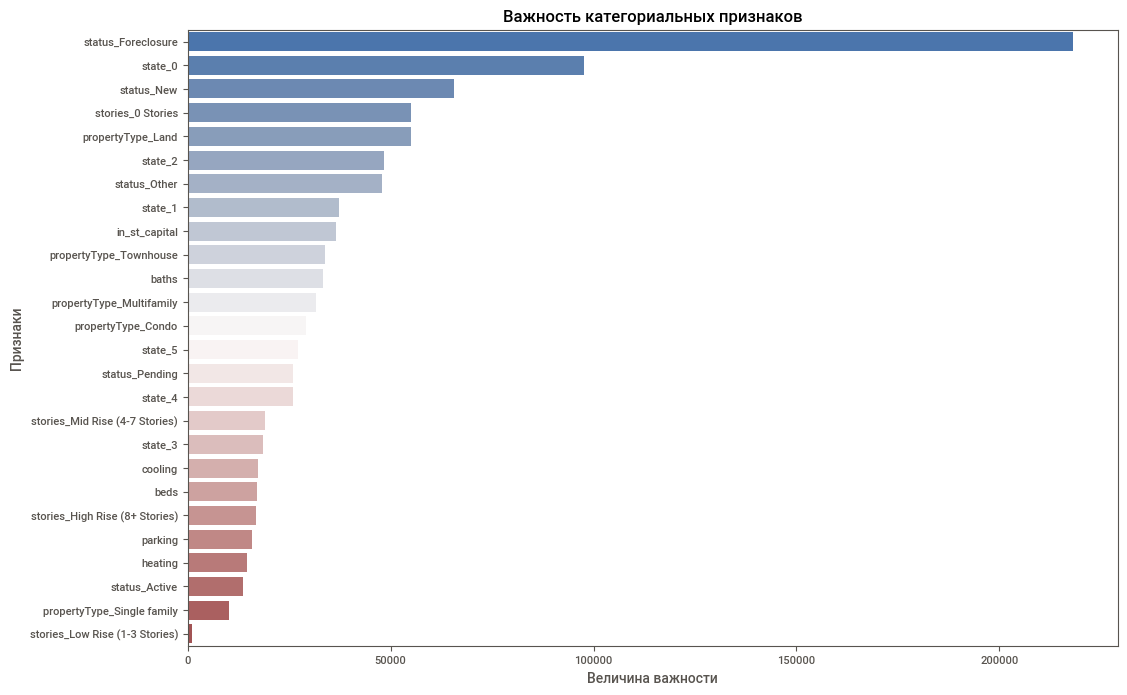

In [ ]:
# Сделаем тест хи-квадрат и выведем его результаты
imp_cat = pd.Series(chi2(df[cat_cols], df.target)[0], index=cat_cols)
imp_cat = imp_cat.sort_values(ascending=False)

fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data = imp_cat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность категориальных признаков', fontsize = 12);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

В результате **хи-тест** - расположил признаки **propertyType_Land** и **stories_0_Stories** на 5 и 4 местах, а **in_st_capital** выше середины рейтинга важности.

Их влияние на результат подтвердили попытки улутшения **baseline-результата** - с помощью линейной регресии при параметрах по умолчанию: ***(удаление признаков storiesType_Stories и in_st_copital - првило бы к ухудшению значений метрикю Эти шаги не представленны в ноутбуке, но их значение оказало влияние на решение не удалять эти признаки).***

Наибольшей важностью  у статуса продаваемой недвижимости является **stastus_Foreclosure** (это - продажа недвижимости в результате вернувшейся к кредитору из за не уплаты ипотеки и вероятно продаётся по сниженной ценеБ чем и пользуется юольшей популярностью).


Тест **ANOVA** - для непрерывных признаков

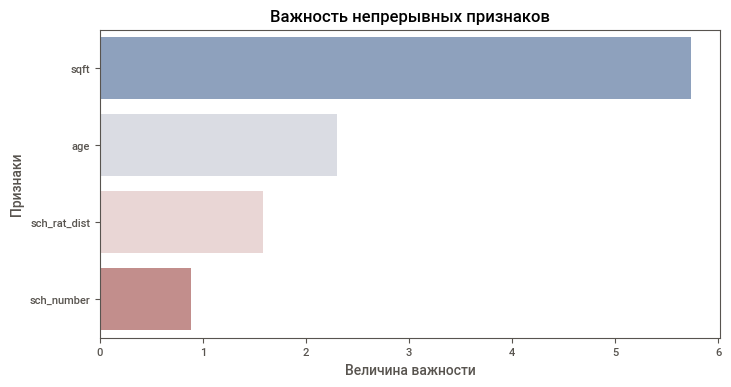

In [ ]:
# Сделаем тест ANOVA и выведем его результаты
imp_num = pd.Series(f_classif(df[num_cols], df.target)[0], index = num_cols)
imp_num = imp_num.sort_values(ascending=False)

fig = plt.figure(figsize=(8, 4))
barplot = sns.barplot(
    data = imp_num.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность непрерывных признаков', fontsize = 12);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

По результатам теста  **ANOVA** - площадь недвижимости является наиболее важным признаком среди остальных непрерывных с точки зрения влияния на стоимость объектов.

Удалённость, количество школ по близости и их рейтинг оказались мене значимы,  чем год постройки и/или обновления объекта.

Проведя тесты разделим датафрейм на обочающие и тестовые выборки (пред возможной нормализацией).

In [ ]:
# Разделяем датафрейм и готовим выборки
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

# Проверим размерности
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# (212684, 30) (91151, 30) (212684,) (91151,)

(212684, 30) (91151, 30) (212684,) (91151,)


### 5.12. Нормализация и стандартизация
Эксперементы показали, что нормализация и стондартизация наших данных не дают прироста метрик, но даже несколько ухудшают её. Поэтому обернём код в функции, чтобы при прогоне программы он не исполнялся, если только функции специально не будут вызванны. Такое решение предредставляется наиболее правильным, чем закоментировать код.

In [ ]:
def mm_scaler(X_train: pd.DataFrame = X_train,
              X_test: pd.DataFrame = X_test) -> tuple:
    """Функция нормализует выборки с помощью MinMaxScaler.

    Args:
        X_train (pd.DataFrame): тренировочная выборка, по умолчанию = X_train
        X_test (pd.DataFrame): тествая выборка, по умолчанию = X_test

    Returns:
        tuple (pd.DataFrame): кортеж из двух нормализованных выборок
    """

    # Составим список признаков для нормализации
    col_names = list(X_train.columns)

    # Создаем объект класса MinMaxScaler
    mm_scaler = MinMaxScaler()

    # Подгоняем нормализатор под тренировочную выборку
    mm_scaler.fit(X_train)

    # Нормализуем обе выборки
    X_train_scaled = mm_scaler.transform(X_train)
    X_test_scaled = mm_scaler.transform(X_test)

    # Преобразуем нормализованные выборки обратно в датафреймы
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

    # Возвращаем нормализованные выборки
    return X_train_scaled, X_test_scaled

In [ ]:
def s_scaler(X_train: pd.DataFrame = X_train,
             X_test: pd.DataFrame = X_test) -> tuple:
    """Функция стандартизирует выборки с помощью StandardScaler.

    Args:
        X_train (pd.DataFrame): тренировочная выборка, по ум. = X_train
        X_test (pd.DataFrame): тествая выборка, по ум. = X_test

    Returns:
        tuple (pd.DataFrame): кортеж из двух нормализованных выборок
    """

    # Составим список признаков, которые будем стандартизировать
    col_names = list(X_train.columns)

    # Инициализируем стандартизатор StandardScaler
    s_scaler = StandardScaler()

    # Подгоняем стандартизатор под тренировочную выборку
    s_scaler.fit(X_train)

    # Стандартизуем обе выборки
    X_train_scaled = s_scaler.transform(X_train)
    X_test_scaled = s_scaler.transform(X_test)

    # Преобразуем стандартизованные выборки обратно в датафреймы
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

    # Возвращаем нормализованные выборки
    return X_train_scaled, X_test_scaled

In [ ]:
def r_scaler(X_train: pd.DataFrame = X_train,
             X_test: pd.DataFrame = X_test) -> tuple:
    """Функция нормализует выборки с помощью RobustScaler.

    Args:
        X_train (pd.DataFrame): тренировочная выборка, по ум. = X_train
        X_test (pd.DataFrame): тествая выборка, по ум. = X_test

    Returns:
        tuple (pd.DataFrame): кортеж из двух нормализованных выборок
    """

    # Составим список признаков для нормализации
    col_names = list(X_train.columns)

    # Инициализируем нормализатор RobustScaler
    r_scaler = RobustScaler()

    # Подгоняем нормализатор под тренировочную выборку
    r_scaler.fit(X_train)

    # Нормализуем обе выборки
    X_train_scaled = r_scaler.transform(X_train)
    X_test_scaled = r_scaler.transform(X_test)

    # Преобразуем стандартизованные выборки обратно в датафреймы
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)

    # Возвращаем нормализованные выборки
    return X_train_scaled, X_test_scaled

### 6. Решение задачи регрессии **(Modeling)**
В данном разделе применим различные модели машинного обучения с целью предсказания стоимости недвижимости. Будем обучать модели от простых к более сложным:
- LinearRregression + PolynomialFeatures,  
- DecisionTreeRegressor,  
- RandomForestRegressor,  
- GradientBoostingRegressor,  
- StackingRegressor,  
- CatBoostRegressor.  

Подбор гиперпараметров осуществим с помощью:
- RandomizedSearchCV,  
- Optuna.

В оконцовке сведём значения метрик в таблицу и выберем модель, которая лутше всех справилась с поставленной задачей.

Начнём с улутшения **baseline-результата**. Для частоты эксперимента применим модель линейной регрессии, как и в **baseline-решении.**

### 6.1. Улутшение **baseline-результата**
Проверим на сколько разведовательный анализ оказался полезен в предсказании результата.

In [ ]:
# Обучим модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Выполним предсказание и выведем результат
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Выведем значеня метрик с помощью написанной функции
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)


MAE на тренировочоной выборке: 203494.35
MAPE на тренировочной выборке: 61.56
r2 на тренировочоной выборке: 0.46

MAE на тестовой выборке: 202873.74
MAPE на тестовой выборке: 61.2
r2 на тестовой выборке: 0.46


#### **Выводы по улутшению baseline**
Напомним, что сразу после предварительной обработки модель показала **MAPE = 84.96%, R2 = 0.25 и обсалютную ошибку в $250тыс.**

Гнерирование результатов (в том числе с помощью десериализации) дополнительная обработка и очистка уже имевшихся принесли почти двоекратное улутшение целевой метрики **R2 - до 0.46** и сниженеие обсолютной ошибки почти на **$50тыс**.

Также приблизились к показателям **CatBoostRegressor (MAPE = 52%, R2 = 0.57, MAE = $173тыс)**.

Снова озвучим две прописные истины в **Data Science** обуславливающие высокие результаты:
- качественная обработка данных, которая может компенсировать простоту модели,
- прдвинутые модели, которые могут справится с даже с плохо подготовленными данными.

Что удаётся достичь при сочитании этих двух факторов, увидим ниже.

### 6.2. Линейная регрессия с полиномиальными признаками
Сгенерируем полиномиальные признаки 2-го(второго) порядка, чтобы проверить, сможет  ли модель линейной регрессии лутше уловить закономерности в данных.

In [ ]:
# Создаем объект класса PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

# Генерируем полиномиальные признаки
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Обучим модель линейной регрессии на полиномиальных признаках
poly_model = LinearRegression()
%time poly_model.fit(X_train_poly, y_train)

# Выполним предсказание и выведем результат
y_train_pred = poly_model.predict(X_train_poly)
y_test_pred = poly_model.predict(X_test_poly)

# Выведем значеня метрик с помощью написанной функции
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: user 23.3 s, sys: 806 ms, total: 24.1 s
Wall time: 16.2 s
MAE на тренировочоной выборке: 173764.12
MAPE на тренировочной выборке: 49.67
r2 на тренировочоной выборке: 0.58

MAE на тестовой выборке: 174528.93
MAPE на тестовой выборке: 49.65
r2 на тестовой выборке: 0.47


**Выводы по полиномиальной регрессии**
Полиномиальная регрессия 2-го порядка как и ожидалось улутшила метрики линейной регрессии.

Значительное снижение МАРЕ и МАЕ, но незначительном улутшении R2.

Прейдём к более чуствительным методам.

### 6.2. Решающее дерево
Известно, что на эфективность работы модели оказывают влияние ее параметры, например: глубина дерева - **max_depth**.

Посмотрим на код, который в позволит в ручную перебрать несколько значений глубины и на графике отобразить изменения метрик качаства.

Далее на графиках определим оптимальную глубину дерева.

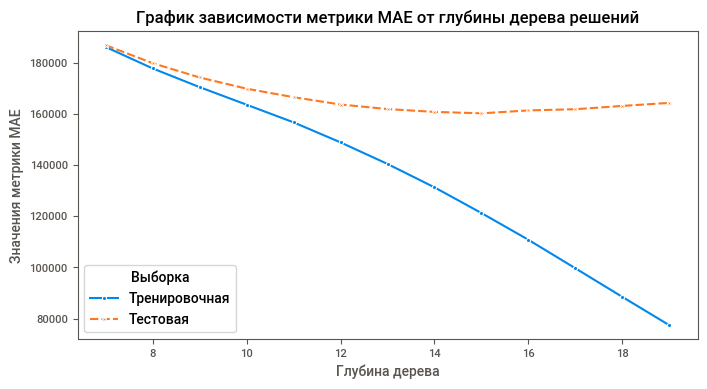

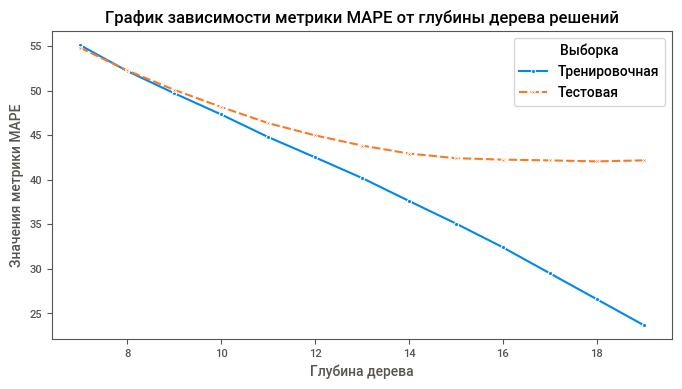

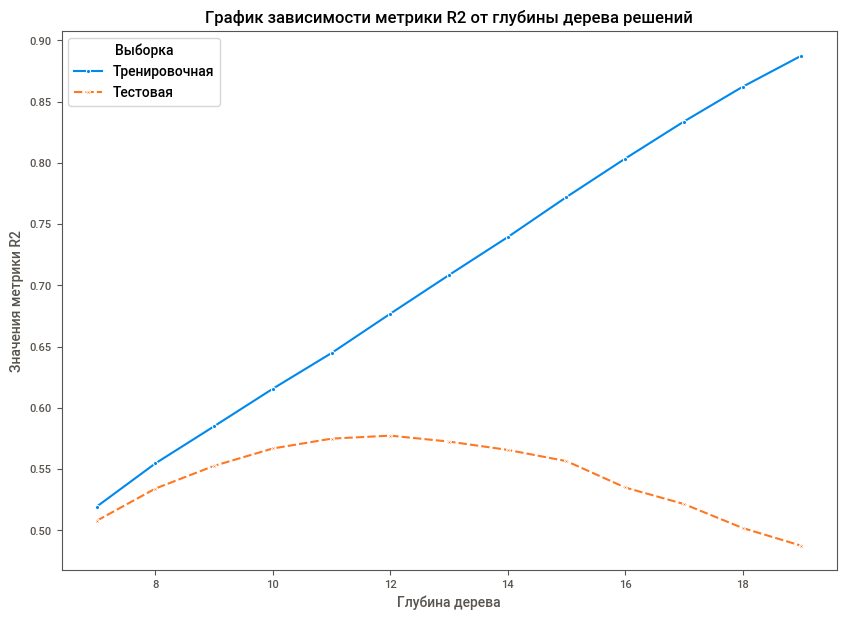

In [ ]:
# Подготовим списки с глубиной дерева и для значений метрики
depths = list(np.arange(7, 20))
mae_train_score = []
mae_test_score = []
mape_train_score = []
mape_test_score = []
r2_train_score = []
r2_test_score = []

# Обучим модель с каждым значением глубины дерева и сохраним результаты
for d in depths:
    # Строим и обучаем модель дерева решений
    tree_reg = DecisionTreeRegressor(
        max_depth = d,
        random_state = 42)

    # Обучаем модель
    tree_reg.fit(X_train, y_train)

    # Выполняем предсказание
    y_train_pred = tree_reg.predict(X_train)
    y_test_pred = tree_reg.predict(X_test)

    # Вычисляем метрики качества
    mae_train, mape_train, r2_train, mae_test, mape_test, r2_test\
        = show_metrics(y_train, y_train_pred, y_test, y_test_pred, show = False)

    # Добавим значения метрик в списки
    mae_train_score.append(mae_train)
    mae_test_score.append(mae_test)
    mape_train_score.append(mape_train)
    mape_test_score.append(mape_test)
    r2_train_score.append(r2_train)
    r2_test_score.append(r2_test)


# Преобразуем получившиеся списки в датафреймы
mae_df = pd.DataFrame(
    data = {'Тренировочная': mae_train_score,
            'Тестовая': mae_test_score},
    index = depths)

mape_df = pd.DataFrame(
    data = {'Тренировочная': mape_train_score,
            'Тестовая': mape_test_score},
    index = depths)

r2_df = pd.DataFrame(
    data = {'Тренировочная': r2_train_score,
            'Тестовая': r2_test_score},
    index = depths)

# Построим линейный график зависимости MAE
fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(
    data = mae_df,
    dashes = True,
    markers = True
);
lineplot.set_title('График зависимости метрики MAE от глубины дерева решений');
lineplot.set_ylabel('Значения метрики MAE');
lineplot.set_xlabel('Глубина дерева');
lineplot.legend(title ='Выборка');

# Построим линейный график зависимости MAPE
fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(
    data = mape_df,
    dashes = True,
    markers = True
);
lineplot.set_title('График зависимости метрики MAPE от глубины дерева решений');
lineplot.set_ylabel('Значения метрики MAPE');
lineplot.set_xlabel('Глубина дерева');
lineplot.legend(title ='Выборка');

# Построим линейный график зависимости R2
fig = plt.figure(figsize=(8, 4))
lineplot = sns.lineplot(
    data = r2_df,
    dashes = True,
    markers = True
);
lineplot.set_title('График зависимости метрики R2 от глубины дерева решений');
lineplot.set_ylabel('Значения метрики R2');
lineplot.set_xlabel('Глубина дерева');
lineplot.legend(title ='Выборка');

Видно на графике зависимости **МАЕ,** оптимальной глубиной определяется 15, после чего метрика на тестовой выборке начинает рoсти, а на тренировочной выборке продолжает снижатся. Это говорит о переобучении модели.

Если оптимизировать метрику **МАРЕ,** то  наиманьшее значение наблюдается при глубине 18.

Метрика **R2** перестаёт улутшаться после глубины 12.

По показателям в зависимости от задачи, можно выбрать разную глубину.

Можно изменять параметр минимального количества листьев в узле дерева **min_samples_leaf** , также  влияя на результат.

Давайтее обучим дерево с максимальной глубиной 15 и минимальным количеством листьев 10.

In [ ]:
# Код для просмотра значений метрик при оптимальной глубине 15 и количестве листьев 10
opt_d=15
print('MAE:', mae_test_score[depths.index(opt_d)])
print('MAPE:', mape_test_score[depths.index(opt_d)])
print('R2:', r2_test_score[depths.index(opt_d)])

MAE: 160206.34806170836
MAPE: 42.42745355358867
R2: 0.556550543300558


Зафиксируем, что на глубине 15 сейчас на тестовых выборках они равны:
* MAE: 160206. 83
* MAPE: 42. 42%
* R2: 0. 56

In [ ]:
# Смотрим и обучаем модел дерева решений
tree_reg = DecisionTreeRegressor(
    max_depth = 15,
    min_samples_leaf = 10,
    random_state = 42)

# Обучаем модель
%time tree_reg.fit(X_train, y_train)

# Выполняем предсказание
y_train_pred = tree_reg.predict(X_train)
y_test_pred = tree_reg.predict(X_test)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: user 2.13 s, sys: 18.3 ms, total: 2.15 s
Wall time: 2.37 s
MAE на тренировочоной выборке: 140895.94
MAPE на тренировочной выборке: 38.44
r2 на тренировочоной выборке: 0.7

MAE на тестовой выборке: 159515.63
MAPE на тестовой выборке: 42.37
r2 на тестовой выборке: 0.59


**Выводы по молели решающего дерева:**

Благодаря введению дополнительного параметра модели - минимального количества листьев, удалось улутшитить две из трёх метрик:

**МАРЕ** несколько ухудшилась, поскольку глубина дерева 15 не была для неё оптимальной, так же и для **R2**, но тут дополнительный параметр невелировал неоптимальное значение глубины.

Перейдём к более сложным моделям, где сможем провести подбор гиперпараметров в автоматическом режиме.

### 6.3. Случайный лес и оптпмизация гиперпараметров

Посмотрим на возможности случайного леса. И если с решаюшим деревом вручную подбирали параметры, на этот раз воспользуемся алгоритмом **RandomizedSearchCV**  

In [ ]:
# Создаем сетку перебираемых параметров
param_distributions = {
    'n_estimators': [100, 150, 200],
    'max_depth': np.arange(11, 18, 2),
    'min_samples_leaf': [5, 10, 15]
}

# Создаем модель RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator = RandomForestRegressor(
        n_jobs = -1,
        warm_start = True,
        random_state = 42),
    param_distributions = param_distributions,
    cv = 2,
    scoring = 'r2',
    return_train_score = False,
    n_jobs = -1,
    verbose = 1
)

# Обучим модель
%time rand_search.fit(X_train, y_train)

# Сделаем предсказания
y_train_pred = rand_search.predict(X_train)
y_test_pred = rand_search.predict(X_test)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
CPU times: user 4min 13s, sys: 3.54 s, total: 4min 16s
Wall time: 26min 40s
MAE на тренировочоной выборке: 127992.58
MAPE на тренировочной выборке: 36.33
r2 на тренировочоной выборке: 0.76

MAE на тестовой выборке: 146241.17
MAPE на тестовой выборке: 40.15
r2 на тестовой выборке: 0.66


In [ ]:
# Выведем подобранные значения гиперпараметров, использованные для прогноза
print('Наилучшие значения гиперпараметров:', rand_search.best_params_)

Наилучшие значения гиперпараметров: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_depth': 17}


**Выводы по модели случайного леса**

Более сложная модел - лутшие результаты и решение. В том чтисле и благодаря и подбору алгоритма подбора оптимальных гиперпараметров.

Отметим, что начинает играть роль фоктор времени обучения модели, в данном случае решающее влияние оказал агоритм пусть и случайного, но перебора гиперпараметров.

Видим как это становится важным при больших датафреймах.

Зафиксируем оптимаальные гиперпараметры - они пригодятся в модели стекинга ниже.

### 6.4. Градиентный бустинг над деревьями решений

Напоминаем, что градиентный бустинг исползует относительно слабые модели, которые последовательно пытаются улутшить ошибку предыдущих. В градиентном бустинге базовой моделью являются деревья решений.

По предыдущим решениям, решающее дерево **проигрывает** случайному лесу.

Посмотрим , что можно получить с помощью бустинга.

In [ ]:
# Строим модель градиентного бустинга
boo_reg = GradientBoostingRegressor(
    learning_rate = 0.1,
    n_estimators = 100,
    max_depth = 15,
    min_samples_split = 20,
    random_state = 42
)

# Обучаем модель
%time boo_reg.fit(X_train, y_train)

# Выполняем предсказание
y_train_pred = boo_reg.predict(X_train)
y_test_pred = boo_reg.predict(X_test)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: user 3min 6s, sys: 223 ms, total: 3min 6s
Wall time: 3min 7s
MAE на тренировочоной выборке: 83747.56
MAPE на тренировочной выборке: 24.32
r2 на тренировочоной выборке: 0.9

MAE на тестовой выборке: 136095.35
MAPE на тестовой выборке: 36.12
r2 на тестовой выборке: 0.69


**Выводы по модели градиентного бустинга**

Последовательное уменьшение ошибки меньшим количеством деревьев, дало лутшие результаты, чем большее число деревьев в случайном лесу: **R2 = 0/69, MAPE = 36%.**

Есть опасение, что модель могла переобучиться, демонстрируя высокий показатель **R2 = 0.9** на тренировочной выборке, но поскольку две другие выборки не спустились до нуля, исключим это опасение.

Заметим, когда использовались более широкие границы в методе Z-отклонений **(3 почти для всех типов недвижимости)** при выявлении выбросов в признаке **target**, удалось получить максимальное значение **R2 = 0.7** на тестовой выборке, но при этом **МАРЕ** упала до 40%. Зто значит, что модель хотя и лутше уловила зависимости в данных, но не удалённые выбросы спровацировали рост ошибки.

Минимальное значение **MAE**, которого удалось достичь на тестовой выборке, составило **33% при R2 = 0.68**, но параметры отбора данных не сохранились.

Получив высокие результаты, узнаем какие признаки из нашего датафрейма оказались наиболее значимы.

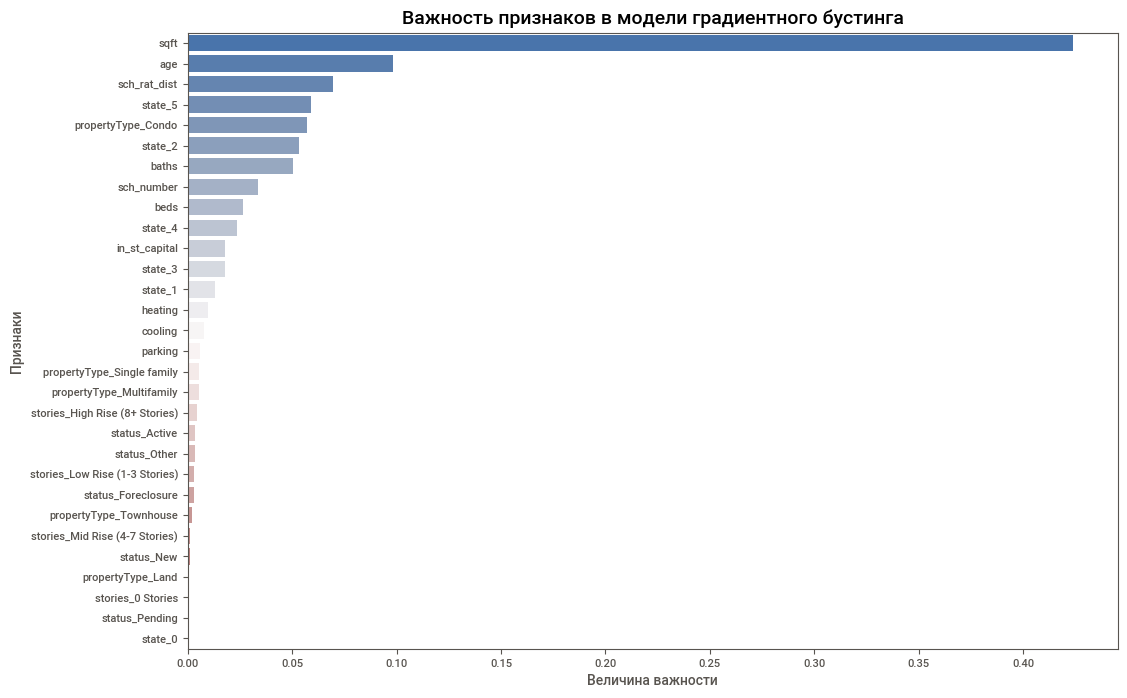

In [ ]:
# Преобразуем массив важности признаков в градиентном бустинге в объект Series
gb_feat = pd.Series(boo_reg.feature_importances_,
                    index=X_train.columns).sort_values(ascending=False)

# Построим диаграмму, иллюстрирующую важность признаков в модели
fig = plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data = gb_feat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность признаков в модели градиентного бустинга', fontsize = 14);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

Площадь объекта недвижимости **sgft** стала самым важным признаком, а признак **status_Foreclosure** который был определён тестом **хи-квадрат** как наиболее важным срели категориальных признаков, очень сильно опустился в рейтинге.  

На результаты градиентного бустинга не повлияло бы, если бы мы удалили признаки **propertyType_Land** и **stories_0 Stories**, на которые указывал **SelectKBest**, они находятся в самом низу по величине вахности.

Важным фактором является возраст  недвижимости, и неожиданно что, количетво ванных комнат иноересует больше, чем количество спален.

Между ванными и спальнями расположился признак количества школ в окрестности. А вот их совокупный рейтинг и расстояние до них - на 3-м месте. Даже признак расположения в столице штата, несмотря на наши предположения, оказался в верхней части рейтинга. Таким образом, наши усилия, затраченные на генерацию данных признаков на этапе EDA окупились!

Попробуем теперь еще улучшить наши результаты с использованием метода оптимизации гиперпараметров.

### 6.5. Стeкинг моделей
Попробуем объединить усилия трёх моделий при помощи стекинга и посмотрим удасться ли дбиться более лутших результатов, чем при их индивидуальном применении.

Напоминание: в стекинге модели обучается независимо друг от друга, а их предсказания служат для обучения метамодели.

Обучим модели с их оптимальными гиперпараматрами.

In [ ]:
# Создаем список моделей для стекинга с подобранными ранее параметрами
estimators = [
    ('dt', DecisionTreeRegressor(
        max_depth = 15,
        min_samples_leaf = 10,
        random_state = 42)
    ),
    ('rf', RandomForestRegressor(
        n_estimators = 150,
        max_depth = 17,
        min_samples_leaf = 5,
        n_jobs = -1,
        warm_start = True,
        random_state = 42)
    ),
    ('gb', GradientBoostingRegressor(
        learning_rate = 0.1,
        n_estimators = 100,
        max_depth = 15,
        min_samples_split = 20,
        random_state = 42)
    )
]

# Создаем объект класса стекинг
stack_reg = StackingRegressor(
    estimators = estimators,
    final_estimator = RandomForestRegressor(
        n_estimators = 150,
        max_depth = 17,
        min_samples_leaf = 5,
        n_jobs = -1,
        warm_start = True,
        random_state = 42),
    cv = 2,
    n_jobs = -1,
    verbose = 5
)

# Обучаем модель
%time stack_reg.fit(X_train, y_train)

# Делаем предсказание
y_train_pred = stack_reg.predict(X_train)
y_test_pred = stack_reg.predict(X_test)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: user 3min 52s, sys: 3.36 s, total: 3min 55s
Wall time: 13min 52s
MAE на тренировочоной выборке: 95217.5
MAPE на тренировочной выборке: 26.36
r2 на тренировочоной выборке: 0.86

MAE на тестовой выборке: 137888.78
MAPE на тестовой выборке: 36.4
r2 на тестовой выборке: 0.68


**Выводы по модели стекинга**

Три независимые модели (включая наиболее успешную - градиетный бустинг) не смогли улутшить достигнутые показатели.
* МАЕ - ухудшилась на $2 тыс.
* МАРЕ - осталась на том же уровне.
* R2 - снизилась на одну сотую.

Дело не в том, что решение было не за лучшей по результатам предыдущих экспериметов моделью градиентнго бустинга. Назначение метамоделью случайного леса принесло немногим более лучшие результаты, чем когда метамоделью был градиентный бустинг ( этот эксперимент был проведён, но не сохранён в ноутбуке) .

На анонсированной ранее модели - **CatBoostRegressor** просмотрим, как покажут показатели на качественно подготовленных данных.

### 6.6. CatBoostRegressor and Optuna
Воспользуемся CatBoostRegressor, которую применили на этапе **baseline-решения**.

На этот раз подберём параметры модели и проведём эту операцию на библиотеке **Optuna**.

In [ ]:
# Создадим функцию расчета целевой метрики
def optuna_rf(trial,
              cv: int = 3,
              X: pd.DataFrame = X_train,
              y: pd.Series = y_train) -> float:
    """Функция получает объект trial, выборки и другие параметры и возвращает
    значение целевой метрики для модели CatBoostRegressor.

    Args:
        trial : объект Optuna.trial для сохранения результатов оптимизации
        cv (int, optional): кол-во фолдов для кросс-валидации; по умолчанию = 3
        X (pd.DataFrame, optional): обучабщая выборка; по умолчанию = X_train
        y (pd.Series, optional): вектор ответов; по умолчанию = y_train

    Returns:
        float: значение целевой метрики
    """

    # Задаем пространство поиска гиперпараметров
    iterations = trial.suggest_int('iterations', 20, 50, 10)
    depth = trial.suggest_int('depth', 11, 15, 2)
    learning_rate = trial.suggest_float('learning_rate', 0.3, 1.0, step=0.1)

    # Cоздаем модель CatBoostRegressor
    model = CatBoostRegressor(
        iterations = iterations,
        depth = depth,
        learning_rate = learning_rate,
        loss_function = 'RMSE',
        random_state = 42,
        thread_count = -1,
        boosting_type = 'Plain',
        verbose = False
    )

    # Готовим выборки для подачи в модель в виде класса Pool
    train_pool = Pool(X, y)

    # Обучаем модель с помощью кросс-валидации
    model.fit(train_pool)
    score = cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=-1).mean()

    # Возвращаем значение метрики
    return score

In [ ]:
# Создаем объект исследования study для подбора гиперпараметров
study = optuna.create_study(study_name='CatBoostRegressor', direction='maximize')

# Выполняем оптимизацию гиперпараметров 10 раз
%time study.optimize(optuna_rf, n_trials=10)


[I 2024-09-05 21:31:01,040] A new study created in memory with name: CatBoostRegressor
[I 2024-09-05 21:33:56,351] Trial 0 finished with value: 0.646899965880388 and parameters: {'iterations': 50, 'depth': 15, 'learning_rate': 0.7}. Best is trial 0 with value: 0.646899965880388.
[I 2024-09-05 21:35:41,033] Trial 1 finished with value: 0.6550419211591633 and parameters: {'iterations': 30, 'depth': 15, 'learning_rate': 0.6000000000000001}. Best is trial 1 with value: 0.6550419211591633.
[I 2024-09-05 21:36:00,583] Trial 2 finished with value: 0.6358473440657283 and parameters: {'iterations': 20, 'depth': 13, 'learning_rate': 0.9000000000000001}. Best is trial 1 with value: 0.6550419211591633.
[I 2024-09-05 21:36:29,490] Trial 3 finished with value: 0.6282371040176269 and parameters: {'iterations': 30, 'depth': 13, 'learning_rate': 1.0}. Best is trial 1 with value: 0.6550419211591633.
[I 2024-09-05 21:38:44,821] Trial 4 finished with value: 0.6390987854337036 and parameters: {'iterations'

CPU times: user 3min 48s, sys: 1min 16s, total: 5min 4s
Wall time: 12min 10s


In [ ]:
# Продолжим подбор гиперпараметров: добавим еще 10 итераций
%time study.optimize(optuna_rf, n_trials=10)


[I 2024-09-05 21:46:23,184] Trial 10 finished with value: 0.6569498802251313 and parameters: {'iterations': 40, 'depth': 11, 'learning_rate': 0.3}. Best is trial 5 with value: 0.6576911947649493.
[I 2024-09-05 21:46:40,118] Trial 11 finished with value: 0.6569498802251313 and parameters: {'iterations': 40, 'depth': 11, 'learning_rate': 0.3}. Best is trial 5 with value: 0.6576911947649493.
[I 2024-09-05 21:46:57,117] Trial 12 finished with value: 0.6565542265891136 and parameters: {'iterations': 40, 'depth': 11, 'learning_rate': 0.5}. Best is trial 5 with value: 0.6576911947649493.
[I 2024-09-05 21:47:19,968] Trial 13 finished with value: 0.660653041814082 and parameters: {'iterations': 50, 'depth': 11, 'learning_rate': 0.4}. Best is trial 13 with value: 0.660653041814082.
[I 2024-09-05 21:47:39,657] Trial 14 finished with value: 0.6599094401802001 and parameters: {'iterations': 50, 'depth': 11, 'learning_rate': 0.5}. Best is trial 13 with value: 0.660653041814082.
[I 2024-09-05 21:48:0

CPU times: user 1min 59s, sys: 2.56 s, total: 2min 2s
Wall time: 4min 32s


In [ ]:
# Выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров:', study.best_params)
print('r2 на тренировочной выборке:', round(study.best_value, 2))


Наилучшие значения гиперпараметров: {'iterations': 50, 'depth': 13, 'learning_rate': 0.4}
r2 на тренировочной выборке: 0.67


In [ ]:
# Для тестовой выборки обучим модель с наилучшими параметрами и выведем результаты
cat_boo_reg = CatBoostRegressor(**study.best_params,
                                thread_count = -1,
                                boosting_type = 'Plain',
                                verbose = False,
                                random_state = 42)

# Готовим выборки для подачи в модель в виде класса Pool
train_pool = Pool(X_train,
                  y_train)
test_pool = Pool(X_test)

# Обучаем модель
%time cat_boo_reg.fit(train_pool)

# Делаем предсказание
y_train_pred = cat_boo_reg.predict(train_pool)
y_test_pred = cat_boo_reg.predict(test_pool)

# Вычисляем метрики качества
_ = show_metrics(y_train, y_train_pred, y_test, y_test_pred)

CPU times: user 18.5 s, sys: 203 ms, total: 18.7 s
Wall time: 12.1 s
MAE на тренировочоной выборке: 131074.86
MAPE на тренировочной выборке: 35.88
r2 на тренировочоной выборке: 0.74

MAE на тестовой выборке: 143885.39
MAPE на тестовой выборке: 38.3
r2 на тестовой выборке: 0.67


**Выводы по модели CatBoostRegressor**

Несмотря на многообещающие результаты модели в baseline-решении, хорошо обработанные нами данные с многоэтапным подбором параметров с помощью Optuna (большая часть экспериментов не вошла в ноутбук, поскольку мы последовательно избавлялись от малозначимых параметров модели, оставив в итоге подобр только тех, которые вносят наибольший вклад) не принесли ожидаемого сверх-улучшения метрик.

Полученные крайние значения несколько уступают модели градиентного бустинга. Но всё же модель CatBoostRegressor обучается быстрее градиентного бустинга и показывает хорошие результаты на плохо подготовленных данных.

Возможно мы раскрыли не весе возможности заложенные в данной библиотеке, перебрав с помощью сильного метода небольшую долю параметров.

Посмотрим, как походил подбор гиперпараметров библиотекой Optuna и какие из них стали наиболее значимы для целевой метрики.

In [ ]:
# Построим график оптимизации метрики R@
optuna.visualization.plot_optimization_history(study, target_name='R2')

In [ ]:
# Построим диаграмму важности гиперпараметров
optuna.visualization.plot_param_importances(study, target_name='R2')

In [ ]:
# Построим тепловые карты влияния гиперпараметров на метрику R2
optuna.visualization.plot_contour(study, params=['iterations', 'depth', 'learning_rate'],
                                  target_name='R2')

Применение  библиотеки **Optuna** показало, что продолжать оптимизацию гиперпараметров после первых 10-й итерации улутшения не произошло.

Возможно это дело в млаом количестве оптимизируемых гиперпараметрах и их диапозоне значений, а возможно и в качестве данных, которые не позволяют показать лутшие результаты.

Однако ниодна модель не правзошла значение R**2 = 0.7**

Посмотрим на значимость признаков в модели **CatBoostRegressor**

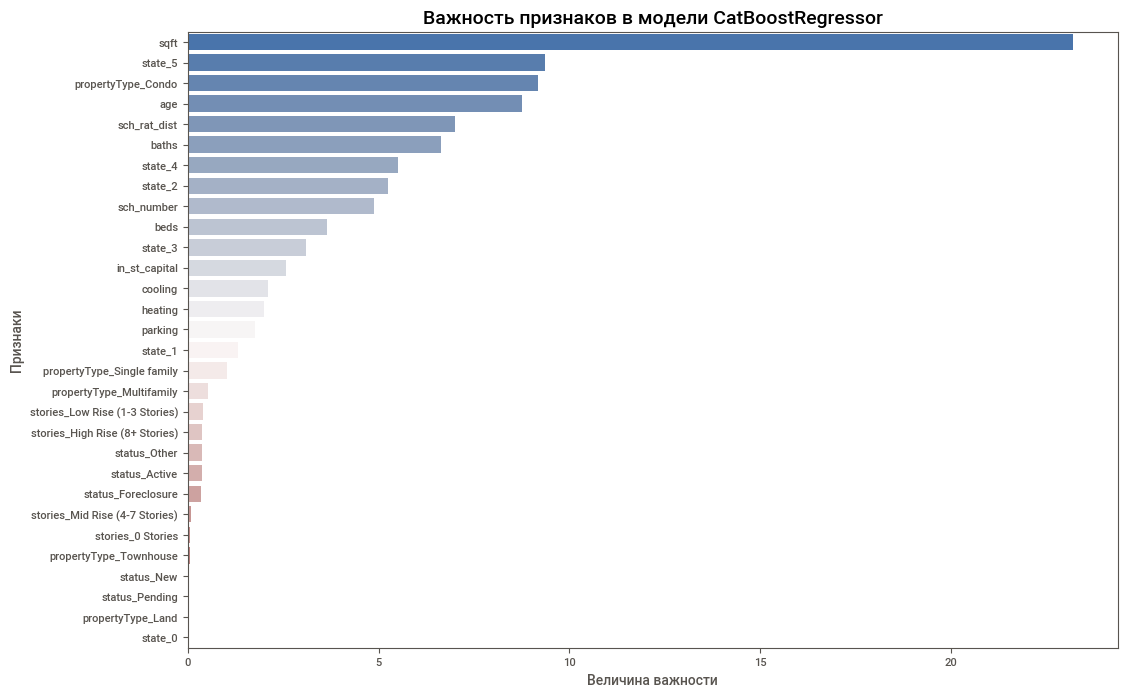

In [ ]:
# Преобразуем массив важности признаков в градиентном бустинге в объект Series
cat_bst_feat = pd.Series(cat_boo_reg.get_feature_importance(),
                         index=X_train.columns).sort_values(ascending=False)

# Построим диаграмму, иллюстрирующую важность признаков в модели
fig = plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data = cat_bst_feat.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность признаков в модели CatBoostRegressor', fontsize = 14);
barplot.set_xlabel('Величина важности');
barplot.set_ylabel('Признаки');

Значимостью признаков в целом похожая с той лишь разницей, что признак "sqft" не имеет такого явного отрыва от остальных, как в модели градиентного бустинга. Убывание значимости происходит плавнее, и признаки имеют бОльшую значимость, чем в другой модели.

> **Общий вывод по 6-му разделу (Evaluation):**
>
> Сведём в таблицу все полученные результаты, чтобы оценить эффективность применённых моделей.  


| Модель | R2 | MAPE | MAE |  
|---|---:|---:|---:|   
| LinearRegression | 0.46 | 61.20  | 202873.48 |  
| PolynomialRegression | 0.47 | 49.65 | 174529.22  |  
| DecisionTreeRegressor | 0.59 | 42.37 | 159516.00 |  
| RandomForestRegressor | 0.67 | 38.95 | 143491.40 |  
| **GradientBoostingRegressor** | **0.69** | **36.06** | **135979.72** |  
| StackingRegressor | 0.68 | 36.31 | 137896.81 |  
| CatBoostRegressor | 0.68 | 37.54 | 141990.89 |  

> Таблица показывает, как с возрастанием сложности моделей и алгоритмов растут и результаты. Пик пришелся на модель градиентного бустинга, поэтому её будем использовать в прадакшене на следующем этапе.
>
> На этом завершим этап решения задачи регрессии.

### 7. Подготовка модели к продакшену (Preperation for deployment)
С помощью библиотеки Pickle мы сериализуем обученную модель градиентного бустинга и сохраним ее в файл. Его останется только открыть и развернуть на сервере, чтобы выполнять прогнозы стоимости недвижимости.

Для проверки корректности работы модели, развернутой на сервере, ниже приводится предсказание на тестовом наборе (состоящем из одной записи из выборки X_test). Точно такой же набор будет подан на сервер клиентским приложением. Ответ должен совпасть.

Важное замечание: при подаче тестового набора в модель, развернутую на сервере возникает предупреждение о том, что данные представлены вектором, а модель обучена на DataFrame с названиями столбцов. Для устранения этого некритичного, но неприятного предупреждения мы заново обучили модель градиентного бустинга на значениях (values) тренировочной выборки (не показано в ноутбуке). В будущих проектах этому стоит уделять внимание сразу.

In [ ]:
# Производим сериализацию модели и сохраняем ее в файл формата pkl
with open(DATA_DIR+'p8model.pkl', 'wb') as output:
    pickle.dump(boo_reg, output)

In [ ]:
# Задаем тестовый набор
test_data = [2,1820,3,1,0,1,4,7,3,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1]
test_data = np.array(test_data).reshape(1, -1) # преобразуем в датафрейм

# Выполняем предсказание с помощью обученной модели
prediction = boo_reg.predict(test_data)

# Выводим результат на экран для проверки при запуске на сервере
print('Такое предсказание должен вернуть сервер:', round(prediction[0]))

Такое предсказание должен вернуть сервер: 435037


### 8. Выводы по проекту.
1. В проекте пройдены все этапы модели **CRoss Industry Standard Process for Data Mining (CRISP-DM) – стандарт, описывающий общие процессы и подходы к аналитике данных, используемые в промышленных data-mining проектах независимо от конкретной задачи и индустрии.** Подготовили продакшен модели на сервере.

2. Движение по модели **CRISP-DM** показывает, что получив первые результаты моделирования, возвращались к предыдущим этапам очистки и подготовки данных, создавали новые, изменяли критерии фильтрации записей и отбора признаков. Это позволило достичь более высоких результатов.

3. В качестве возможных шагов для повышения качества моделирования (как предполагали с самого начала на различных этапах), стоит уделить больше времени подготовке данных, например:
* разделить на большее колличество категорий - типы недвижимости,
* выделить ценовые котегории недвижимости,
* применить алгоритмы кластеризации для выделения групп жилья по другим критериям,
* дополнительно проработать признак со школами,
* добавить в датафрейм новые данные, например на основании признака **street** (близость магазинов, автозаправок, мест развлечений, парковых зон, шумных автострад, аэропортов, вредных производств и т.д.)

4. Можно применить не задействованные алгоритмы и методы обработк данных, а также другие модели машинного обучения, включая нейронные сети и использование инструментов проведения экспериментов непример - **CometML**, чтобы не терять параметры, приводящие к лучшим результатам.

5. Все стоящие задачи выполнены. Несмотря на результаты, которые еще можно было бы улучшить, проект можно считать успешно завершенным. В проекте применены большинство знаний и навыков, полученных при обучении на курсе **Data Science**.